# Chapter 1: The contrast-dependence of spatial frequency tuning
Here, we'll organize (better than has been organized in the predecesor notebooks [descrAnalysisV1-allExps, V1_clustering, and descrAnalysisLGN]) the analysis for chapter 1 of my thesis.

Last access (y.m.d): 22.06.08   
Last update (y.m.d): 22.06.02  

### Table of contents

- Initialize  
- Gather data
- Distribution of tuning measures **(0)**
  - model free measures  
  - comparison with derived measures  
  - comparison with Cavanuagh, other datasets  
- Tuning shifts with contrast **(1)**
  - Characteristic frequency, i.e. $f_c$
  - Bandwidth
  - sf70
- Shifts with contrast, refined view  **(2)**
  - Trajectory of metric (usually $f_c$) against contrast
      - Violinplot of distr. of bootstrap slopes ($\delta(x)$ across contrast) per cell
      - Plot distribution of fit slope across cells
  - Scatter plot of sf70 - high contrast to {1/3rd contrast, low contrast)
- Mechanism (DoG analysis) **(3)**
    - i.e. Sach plot

## Initialize

In [1946]:
import pandas as pd
import pdb
import warnings
warnings.filterwarnings(action='once')

import numpy as np
import os
import helper_fcns as hf
# import model_responses as mr
import scipy.stats as ss
import scipy.odr.odrpack as odrpack
from scipy.stats.mstats import gmean
from scipy.stats import ks_2samp, kstest, linregress
import itertools
import autoreload
from IPython.core.display import display, HTML, Image

import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('https://raw.githubusercontent.com/paul-levy/SF_diversity/master/paul_plt_style.mplstyle');
import matplotlib.cm as cm
import matplotlib.backends.backend_pdf as pltSave
%matplotlib inline
plt.style.use('https://raw.githubusercontent.com/paul-levy/SF_diversity/master/paul_plt_style.mplstyle');

base_dir = os.getcwd() + '/';


In [1947]:
# Before any plotting, fix plotting paramaters
plt.style.use('https://raw.githubusercontent.com/paul-levy/SF_diversity/master/paul_plt_style.mplstyle');
from matplotlib import rcParams
rcParams['font.size'] = 20;
rcParams['pdf.fonttype'] = 42 # should be 42, but there are kerning issues                                                                                                                                                                                                    
rcParams['ps.fonttype'] = 42 # should be 42, but there are kerning issues                                                                                                                                                                                                     

rcParams['lines.linewidth'] = 2.5;
rcParams['lines.markeredgewidth'] = 0; # no edge, since weird tings happen then
rcParams['axes.linewidth'] = 1.5;
rcParams['lines.markersize'] = 5;

rcParams['xtick.major.size'] = 15
rcParams['xtick.minor.size'] = 8
rcParams['ytick.major.size'] = 15
rcParams['ytick.minor.size'] = 8

rcParams['xtick.major.width'] = 5
rcParams['xtick.minor.width'] = 2
rcParams['ytick.major.width'] = 5
rcParams['ytick.minor.width'] = 2

rcParams['font.family'] = 'DejaVu Sans'
rcParams['font.style'] = 'oblique';
rcParams['font.size'] = 20;

## Gather data

Now, let's create a large list which will combine data/fits/analyses from all cells for all of the above experiments. For each cell, let's keep track of:
* "meta" parameters:
    * which experiment directory
    * which dataList, fitList, descrFit, rvcFit
    * which cell number within those lists
    * which experiment index?
    * which stimulus values (i.e. dispersions, sfs, contrasts)
* inferred parameters:
    * prefSf (for all conditions), along with % var explained
    * c50 (again, for all conditions)
* model parameters
    * fit parameters, loss value for weighted and flat

In [1948]:
# whichArea = 'V1' ; # 'LGN' or 'V1'
whichArea = 'LGN'; # 'LGN' or 'V1'
wMods = 0 if whichArea == 'V1' else 0; # if wMods 
wModStr = '_wMods' if wMods else ''

cut_by_slope = 0; # if cut_by_slope, we cut all cells that will not meet the #of conditions for cFreq slope-fitting;
# --- otherwise, we just make sure that there's at least one condition above threshold...
need_for_slope = 3 if whichArea=='LGN' else 3; # if X, then we need X contrast conditions to fit a slope
# need_for_slope = 3 if whichArea=='LGN' else 2; # if X, then we need X contrast conditions to fit a slope

toGroup = 'simple' if whichArea == 'V1' else 'triType'; # triType is 'magno', 'parvo', 'other'

fitBase = '220531'; # descriptive fits (rvc,SF tuning)
# fitBase = '220511'; # descriptive fits (rvc,SF tuning)
# fitBase = '220219'; # descriptive fits (rvc,SF tuning)
# fitBase = '210914'; # descriptive fits (rvc,SF tuning)
#fitBase = '210503'; # descriptive fits (rvc,SF tuning)
fitBaseMod = '210331'; # model fits

if whichArea == 'LGN':
    thresh = 0;
#     thresh = 65;
    suffix = '%s%s_220608_vT%02d_dvT%02d' % (whichArea, wModStr, thresh, thresh)
#     suffix = '%s%s_220531_vT%02d_dvT%02d' % (whichArea, wModStr, thresh, thresh)
#     suffix = '%s%s_220526_vT%02d_dvT%02d' % (whichArea, wModStr, thresh, thresh)
#     suffix = '%s%sphAdv_220512_vT%02d_dvT%02d' % (whichArea, wModStr, thresh, thresh)
else:
    thresh = 70;
    suffix = '%s%s_220323_vT%02d_dvT%02d' % (whichArea, wModStr, thresh, thresh)
# suffix = '%s%s_210826_vT60_dvT60' % (whichArea, wModStr)

# suffix = 'V1_wMods_210429_vT70_dvT60'
# suffix = 'V1_take2_210331_vT70_dvT60'
# suffix = 'V1_210331_vT70_dvT60'
# suffix = 'V1_200609_vT70_dvT60'
try:
    jointList = hf.np_smart_load(base_dir + 'jointList_%s.npy' % suffix)
    if jointList == []:
        jointList = np.load(base_dir + 'jointList_%s.npy' % suffix, allow_pickle=True);
except: # if it wasn't pickled, then we'll need to just load without the .item which is implicit in hf.np_smart_load
    jointList = np.load(base_dir + 'jointList_%s.npy' % suffix, allow_pickle=True);
#     jointList = np.load(base_dir + 'jointList_%s.npy' % suffix);

slope_spec = '_slp%02d' % need_for_slope if cut_by_slope==1 else '';

saveName = 'figures/reports/ch1/%s%s/' % (suffix, slope_spec) # for one save name for all figures
save_loc = base_dir + saveName;

#### Trim the jointList on some criteria?

In [1949]:
# A: must have at least one single grating tuning curve which has non-nan varExpl (i.e. > VarExplThresh) 
# altA: single grating tuning curve at high contrast must have non-nan varExpl (i.e. > varExplThresh) 
# --- for the diff-of-gauss tuning fit

# Get the keys as ints for easy indexing
keysAsInts = np.array([int(x) for x in jointList.keys()])

prevCells = len(jointList)
if cut_by_slope:
    critA = np.where([np.sum(~np.isnan(jointList[x]['metrics']['dog_varExpl'][0])) >= need_for_slope for x in sorted(jointList.keys())])[0]
else:
    critA = np.where([len(np.where(~np.isnan(jointList[x]['metrics']['dog_varExpl'][0,-1]))[0]) > 0 for x in sorted(jointList.keys())])[0]
# critA = np.where([len(np.where(~np.isnan(jointList[x]['metrics']['sfVarExpl'][0,:]))[0]) > 0 for x in sorted(jointList.keys())])[0]


jointListTrim = {key: jointList[keysAsInts[key]] for key in critA}
jointList = jointListTrim

remCells = len(jointList)

nCut = prevCells-remCells

print('We cut %d cells (%.2f%% of the original %d)' % (nCut, 100*nCut/prevCells, prevCells))

# also get the keys as ints for easy indexing
keysAsInts = np.array([int(x) for x in jointList.keys()])

We cut 0 cells (0.00% of the original 115)


<string>:6: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.


Now, put this list of dictionaries into a pandas dataframe for better plotting (hacky)

- First, create a pandas data frame
- Then, json "normalize" each top-level dictionary (e.g. metadata) into it's own dataframe
- Finally, combine _those_ dataframes into one

In [1950]:
ohno = pd.DataFrame.from_dict(jointList) #, orient='index')

meta = pd.json_normalize([ohno[x]['metadata'] for x in sorted(ohno.keys())])
metr = pd.json_normalize([ohno[x]['metrics'] for x in sorted(ohno.keys())])
modl = pd.json_normalize([ohno[x]['model'] for x in sorted(ohno.keys())])
# supr = pd.json_normalize([ohno[x]['superpos'] for x in sorted(ohno.keys())])
basc = pd.json_normalize([ohno[x]['basics'] for x in sorted(ohno.keys())])

mega = pd.concat((meta, metr, modl, basc), axis=1)

In [1951]:
colors = [];

# classify as simple or complex [FOR USE WITH V1]
simple = mega['f1f0_ratio'] > 1
msk = np.copy(simple)
simple[~msk] = 'complex'
simple[msk] = 'simple'
mega['simple'] = simple

if whichArea == 'LGN':
    cellTypes = mega['cellType'];
    non_mp = np.logical_and(~(cellTypes=='parvo'), ~(cellTypes=='magno'))
    cellTypes[non_mp] = 'other'
    
    mega['triType'] = cellTypes;
    
# get color scheme
cnt = 0;
grp_names = [];
for nm, group in mega.groupby(toGroup):
    cnt += 1;
    grp_names.append(nm)
    
# colors = cm.viridis(np.linspace(0.15, 0.95, cnt))
colors = sns.color_palette('colorblind', n_colors=cnt-1)
colors.append((0,0,0)); # add black!

alph= 0.8/cnt
alphHist = 1; # the bins are non-overlapping now, so no need for transparency

/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


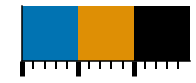

In [1952]:
sns.palplot(colors)

## 00. Set any overall parameters
For example, are we getting descr fits or DoG fits?

In [1953]:
isDog = 1; # 0 if descr; 1 if DoG
dog_suffix = 'dog_' if isDog else '';
dog_suffix_sv = '_dog' if isDog else '';
dog_suffix_plt = 'dog ' if isDog else ''

## 0. Distribution of tuning measures


/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


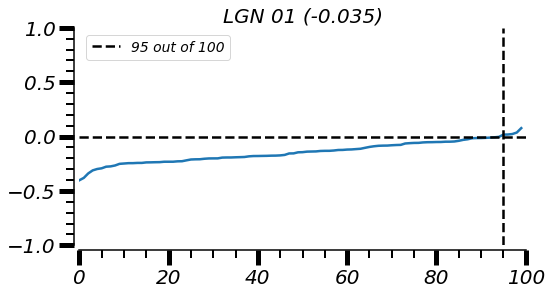

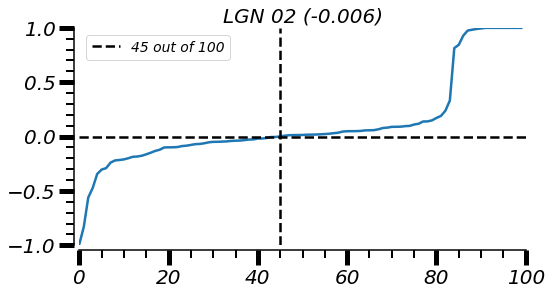

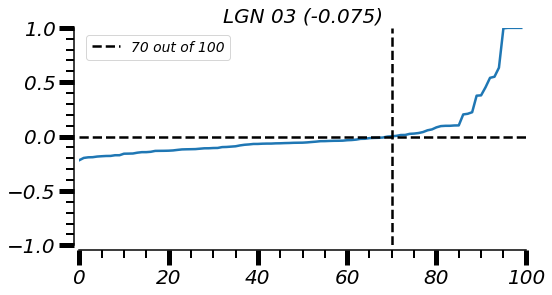

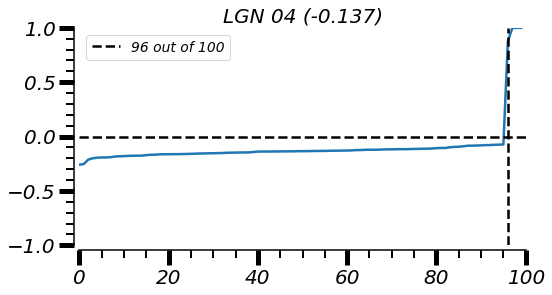

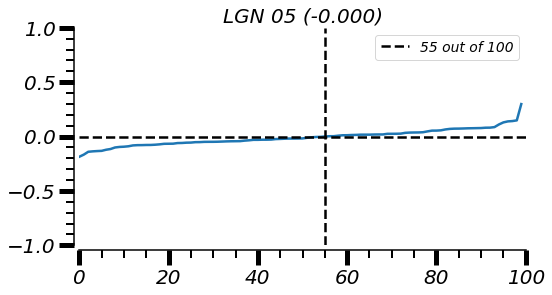

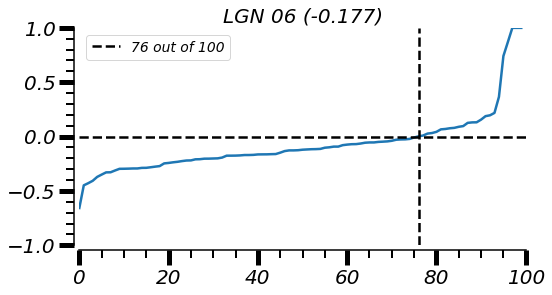

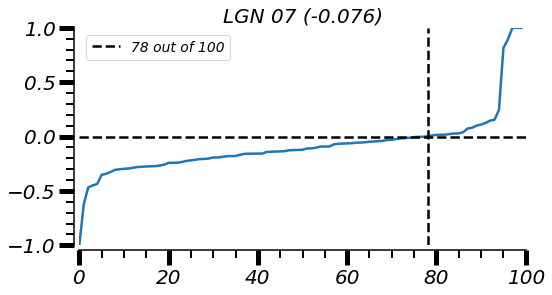

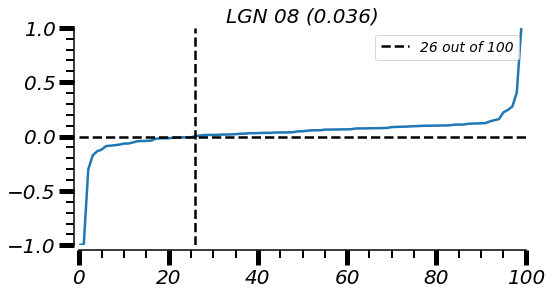

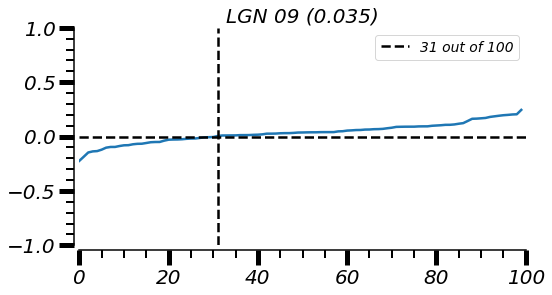

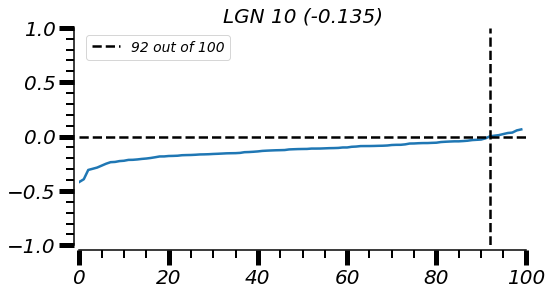

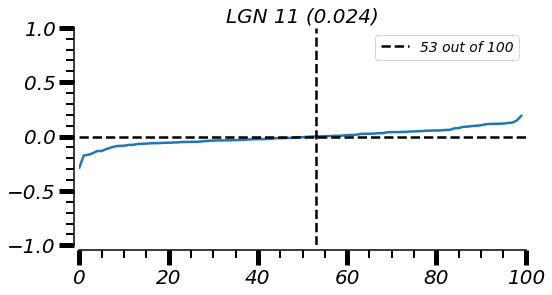

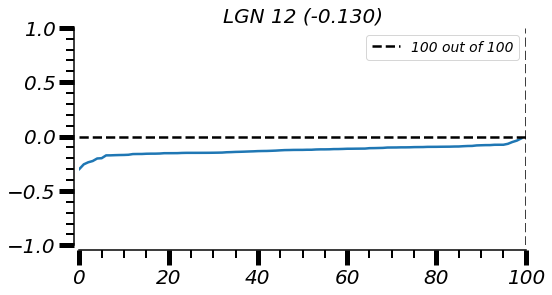

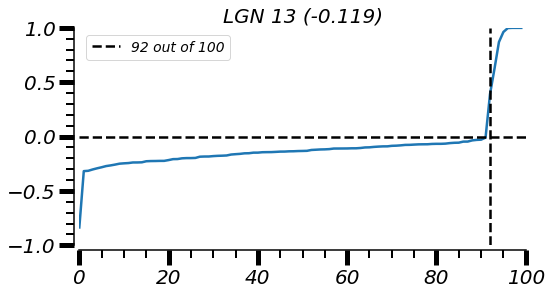

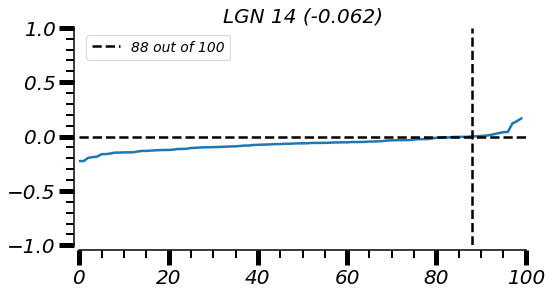

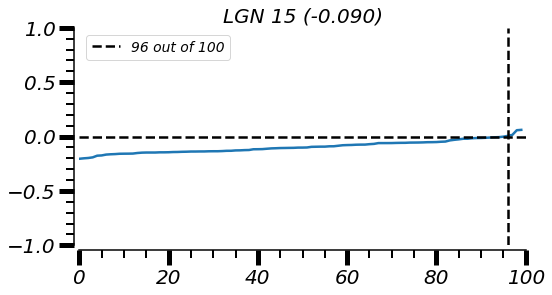

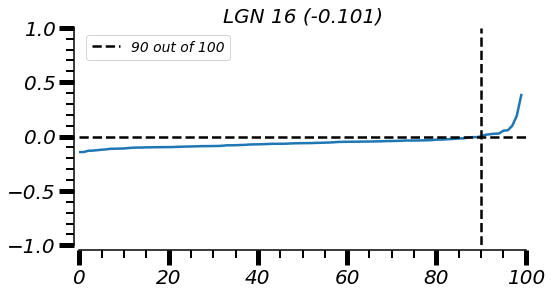

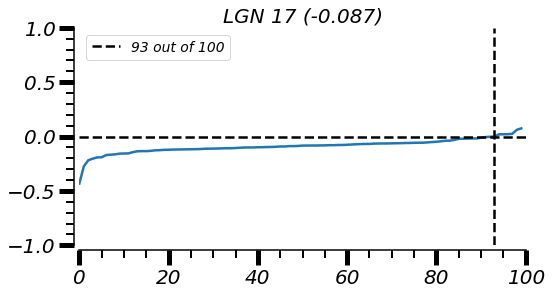

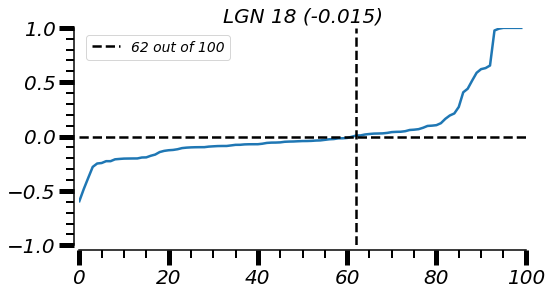

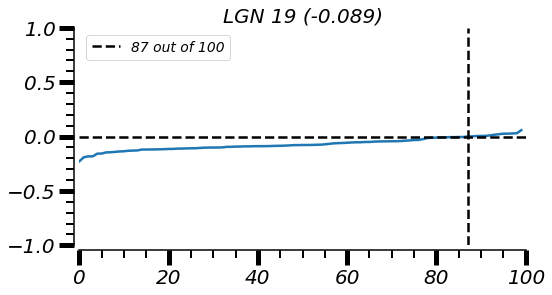

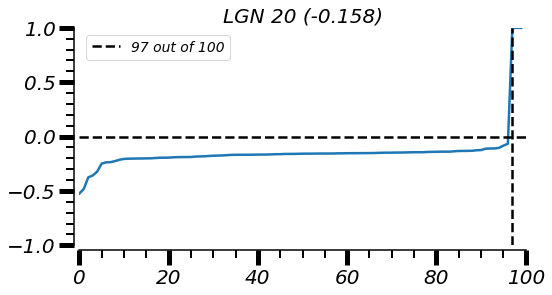

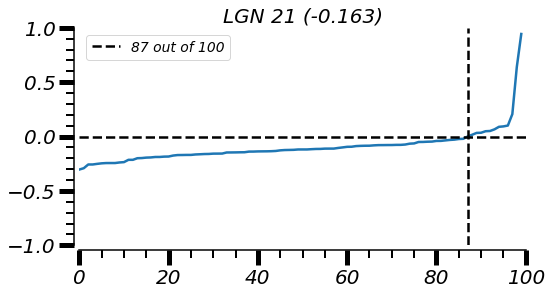

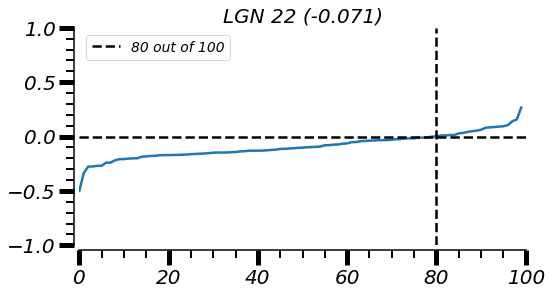

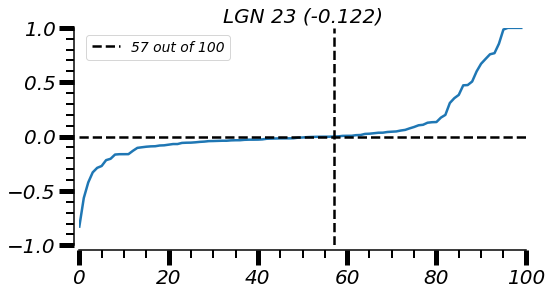

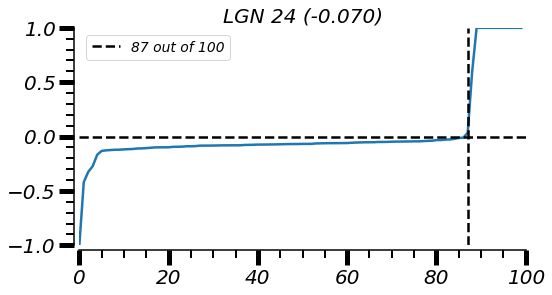

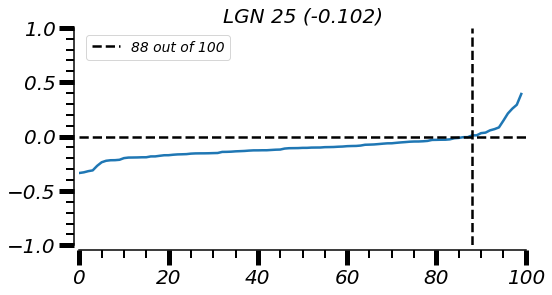

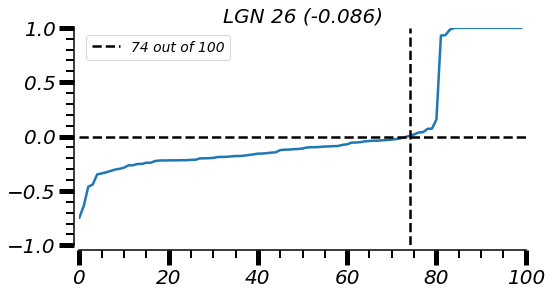

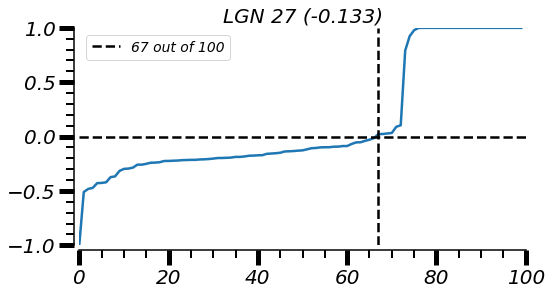

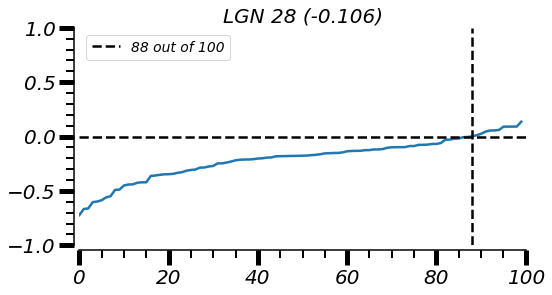

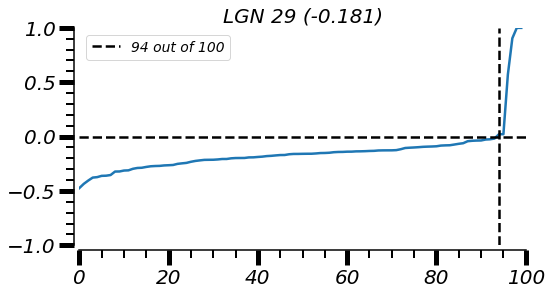

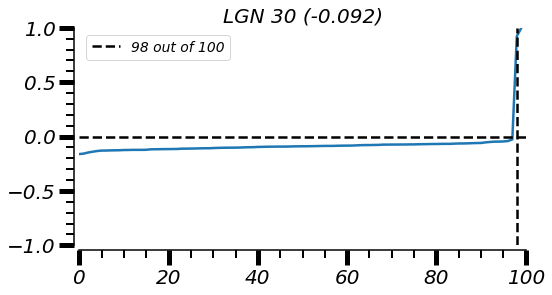

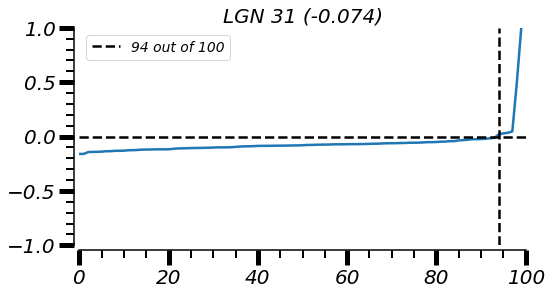

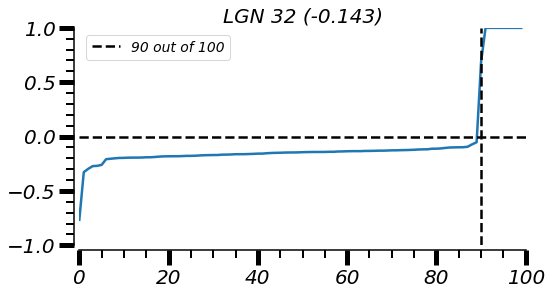

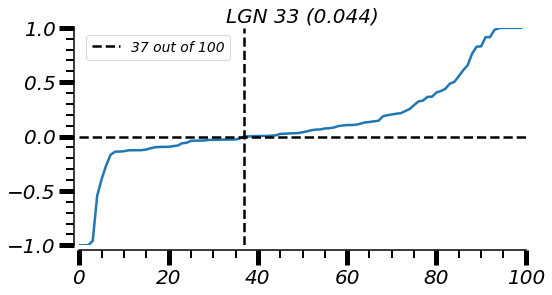

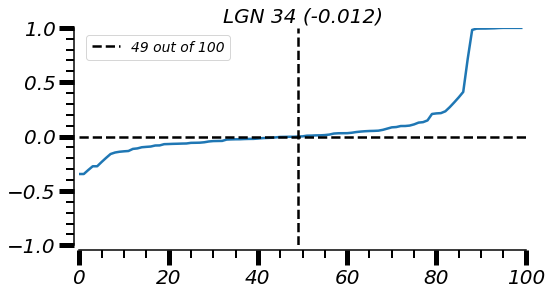

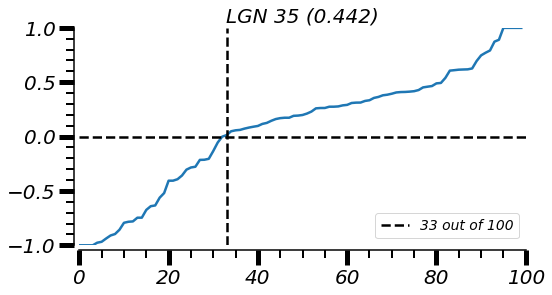

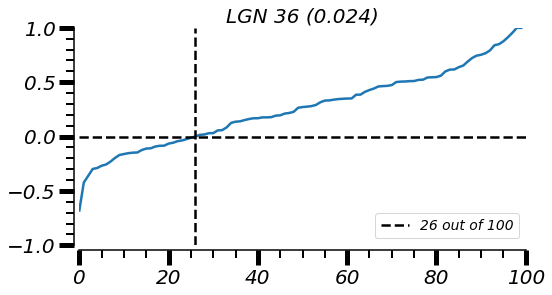

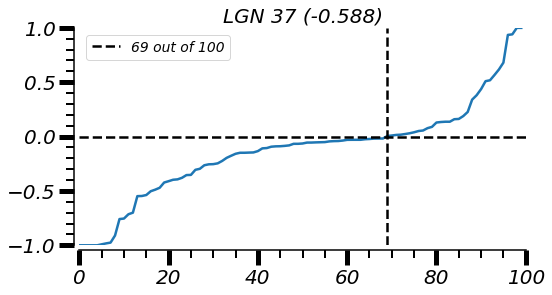

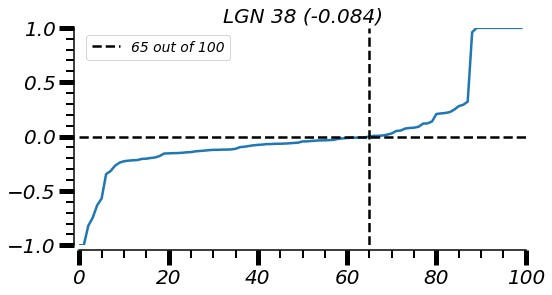

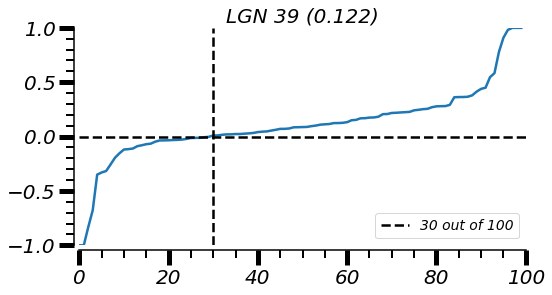

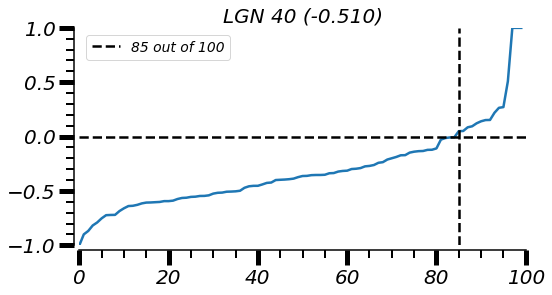

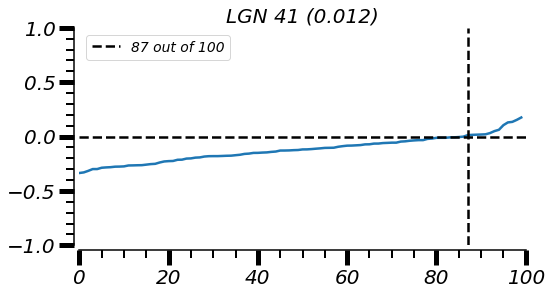

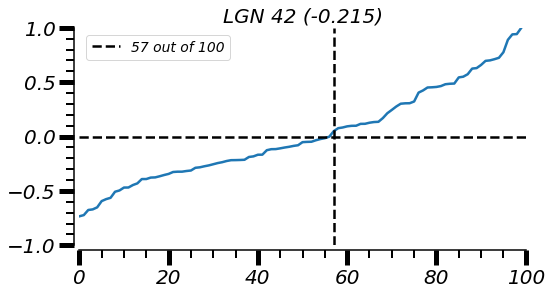

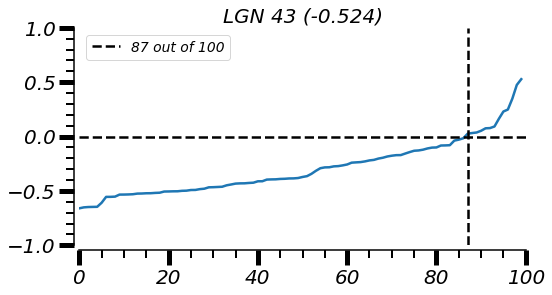

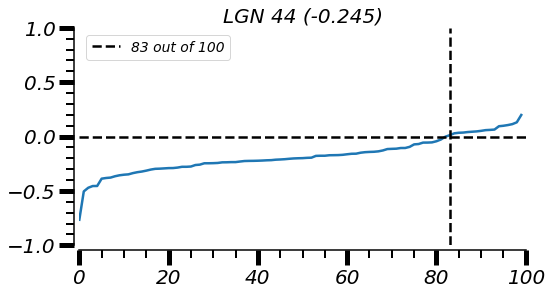

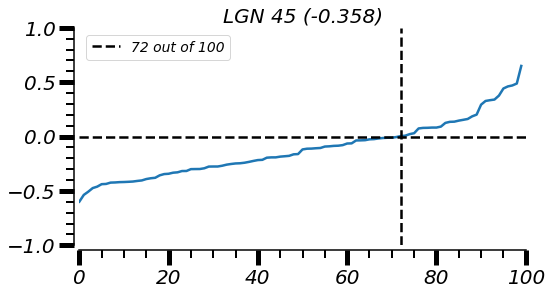

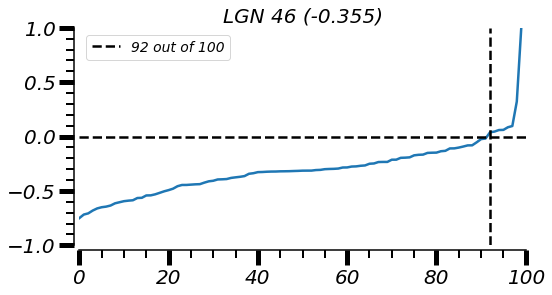

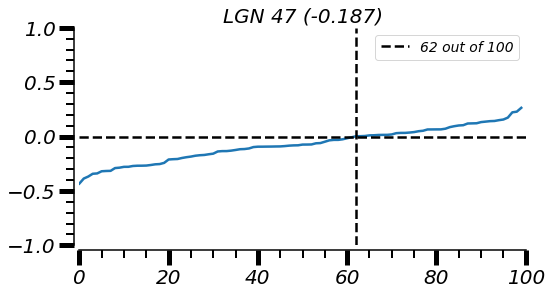

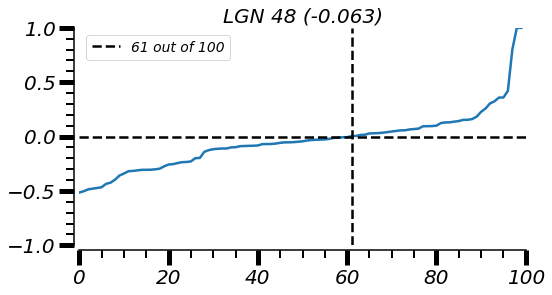

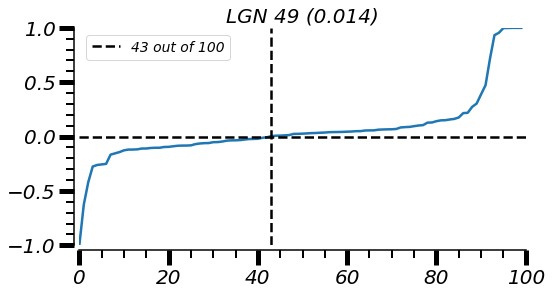

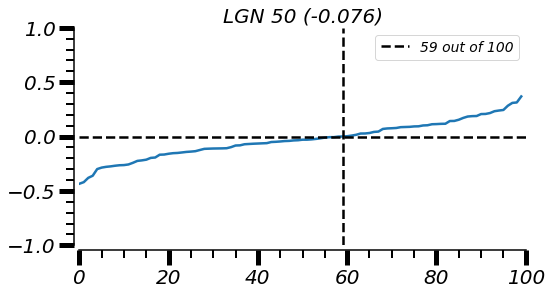

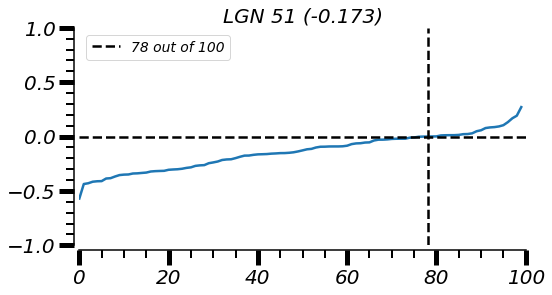

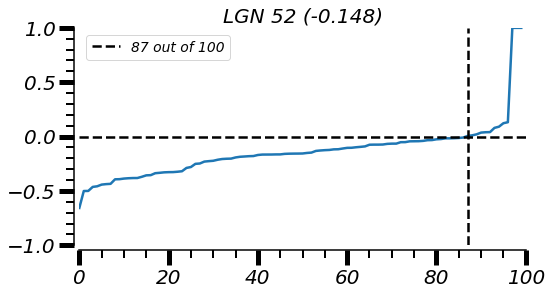

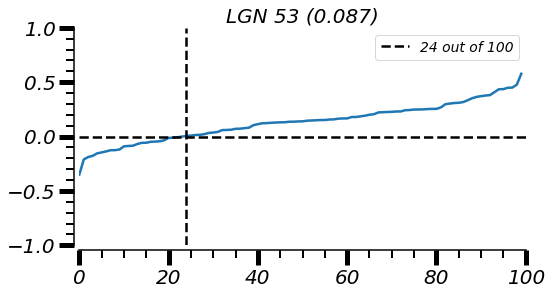

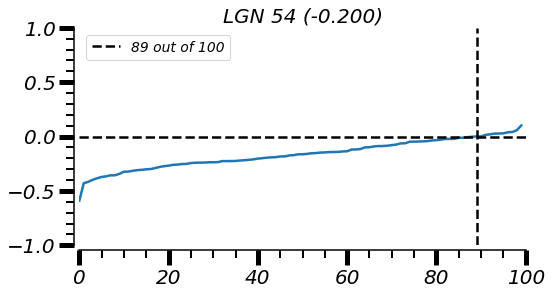

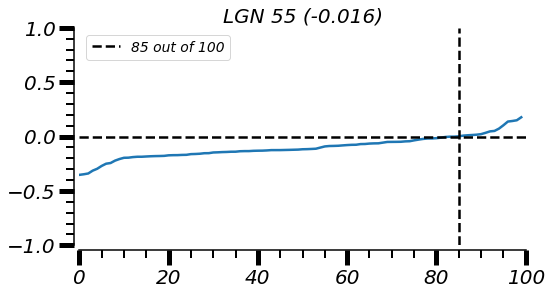

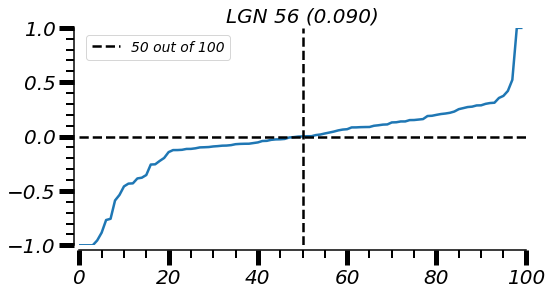

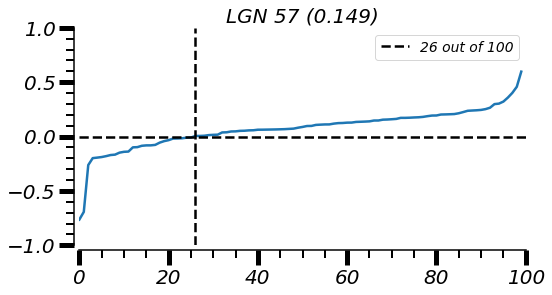

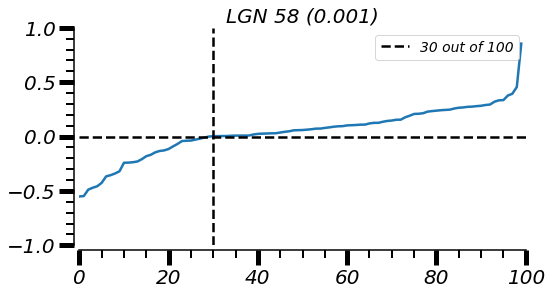

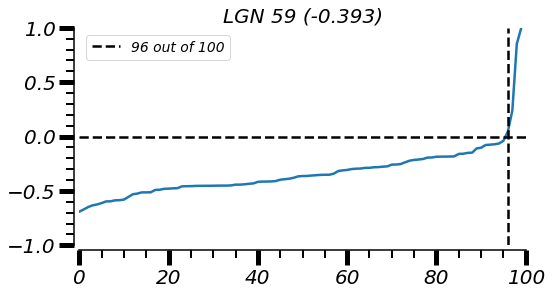

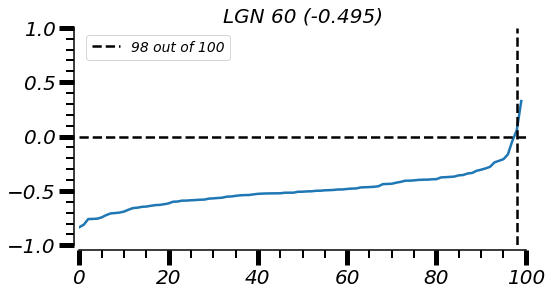

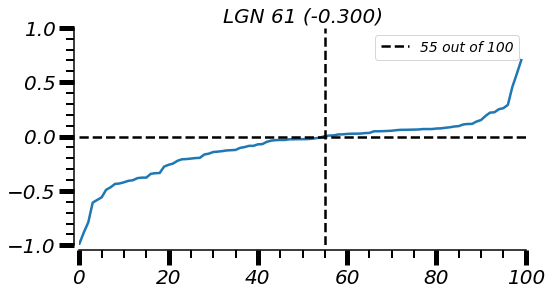

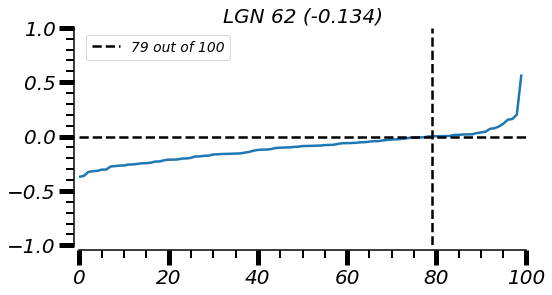

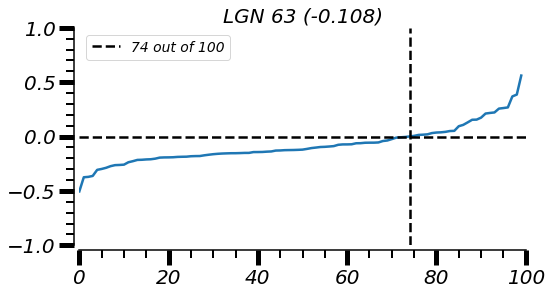

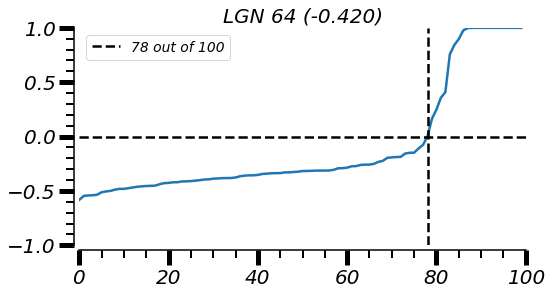

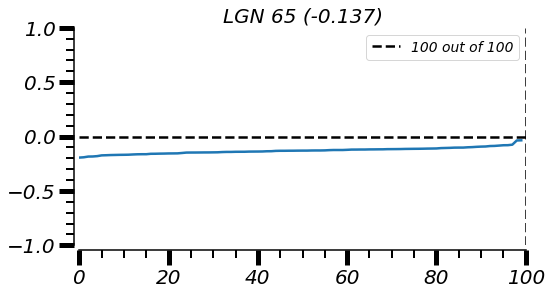

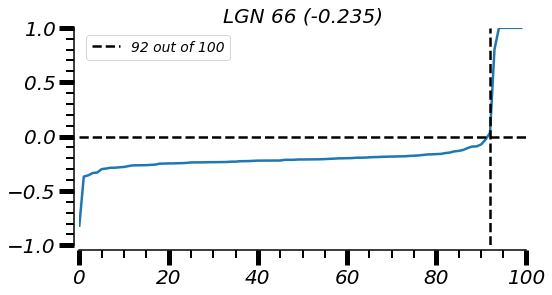

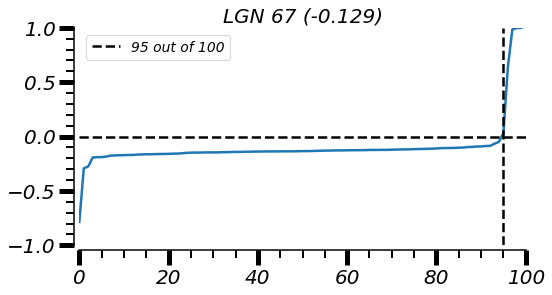

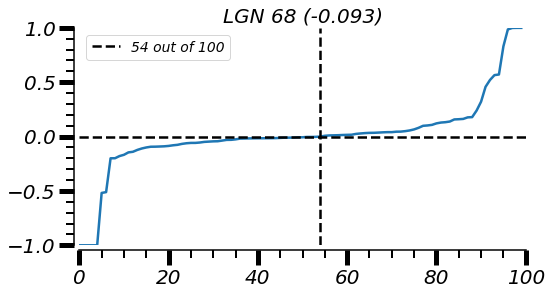

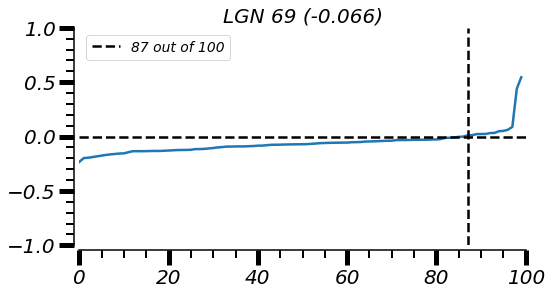

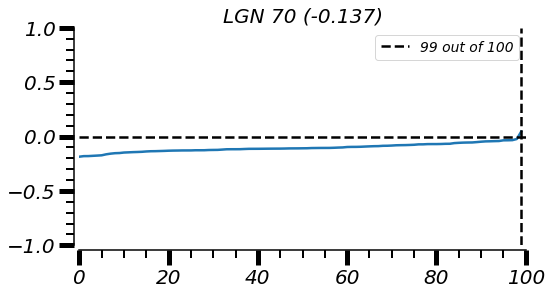

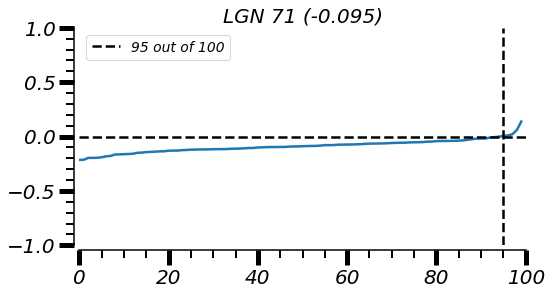

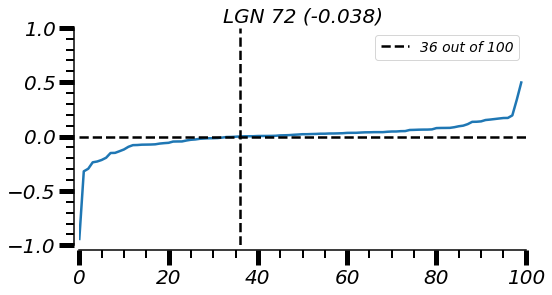

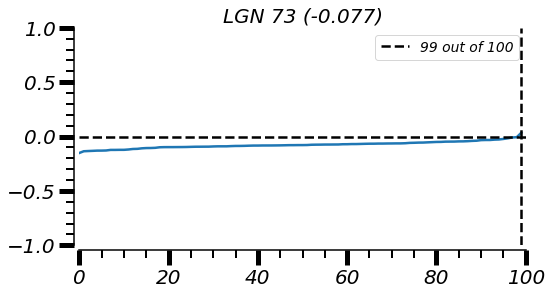

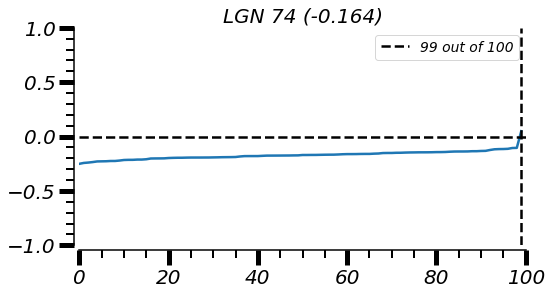

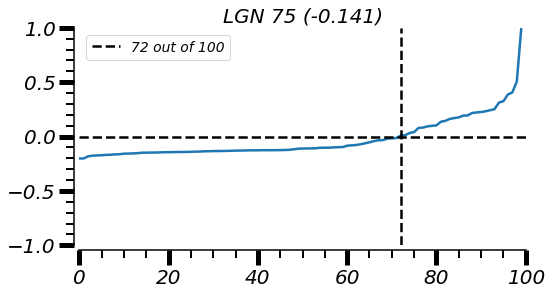

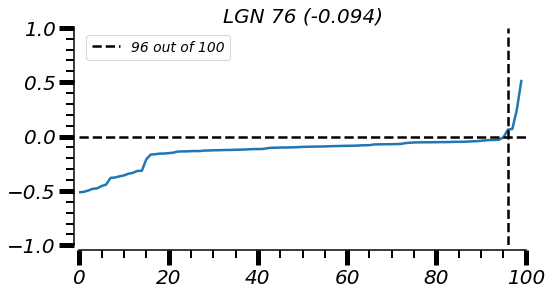

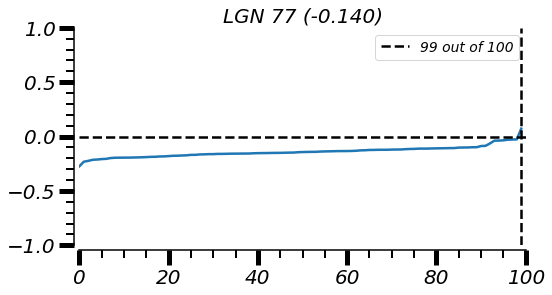

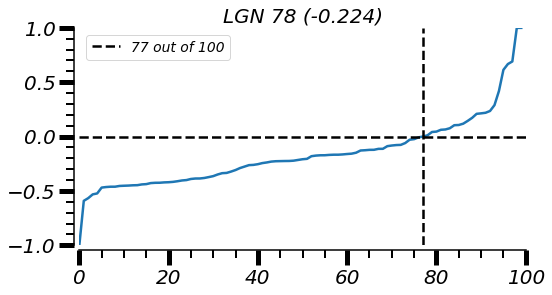

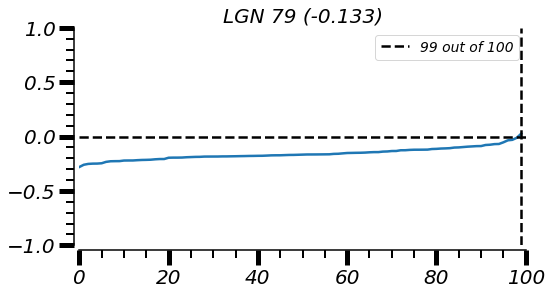

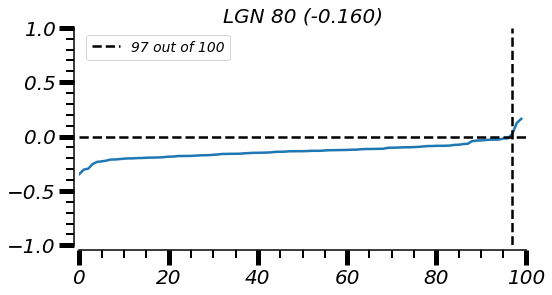

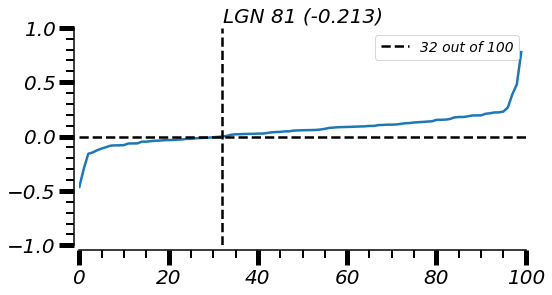

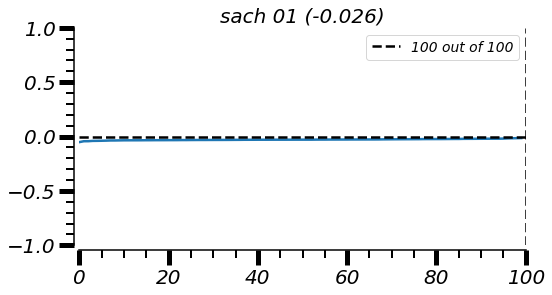

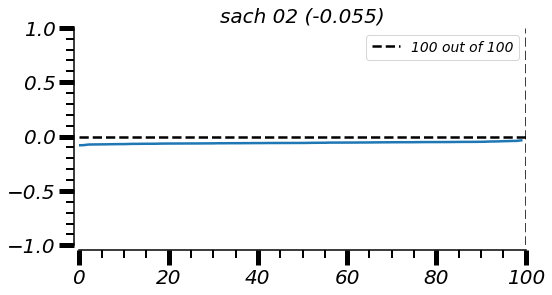

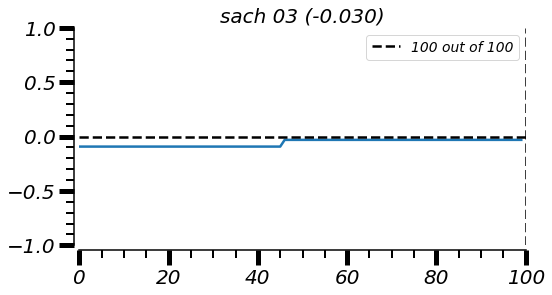

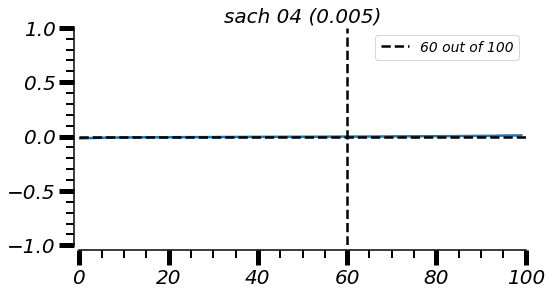

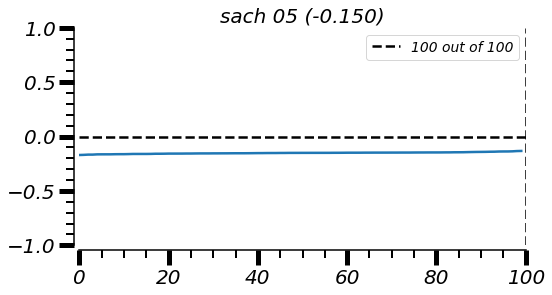

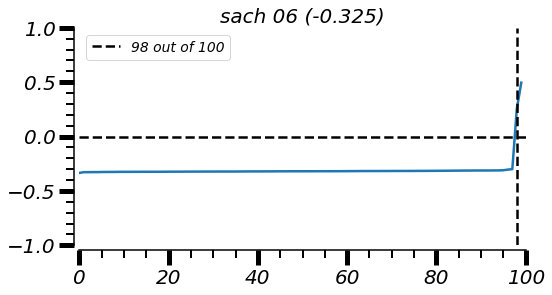

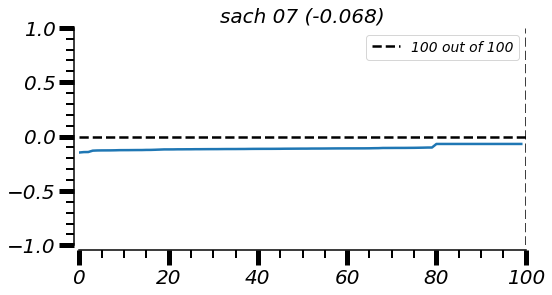

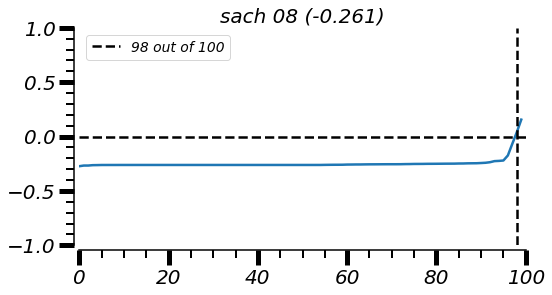

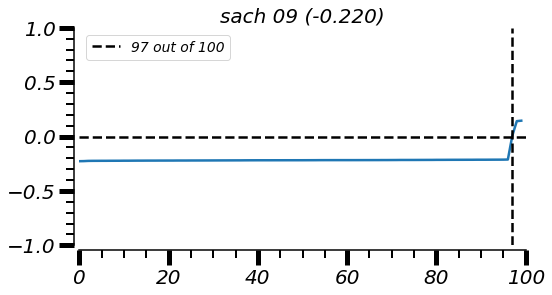

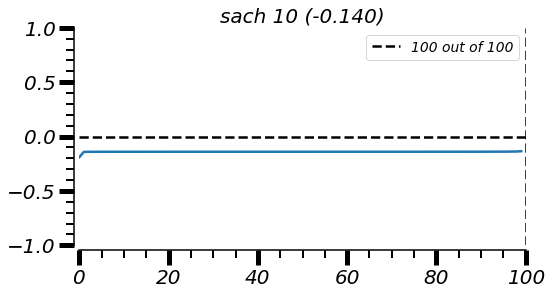

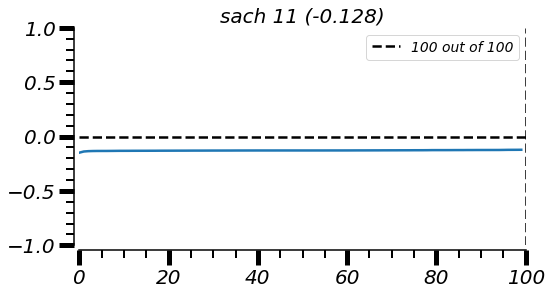

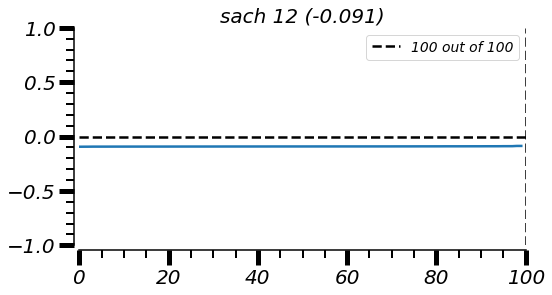

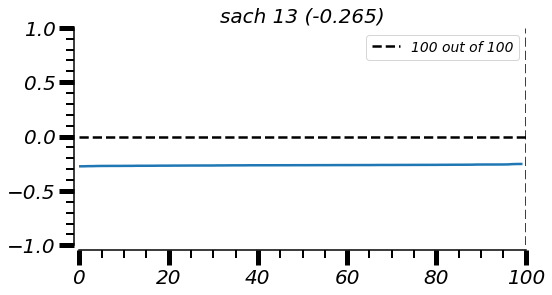

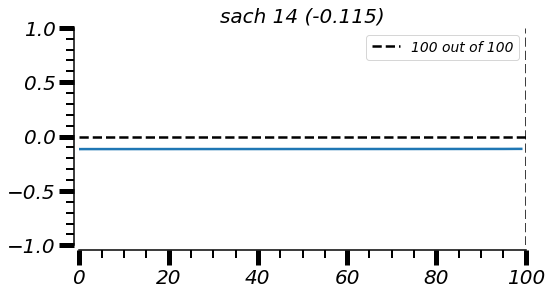

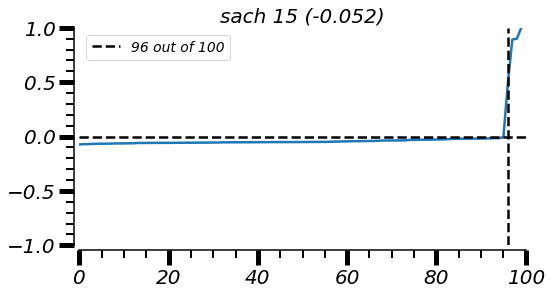

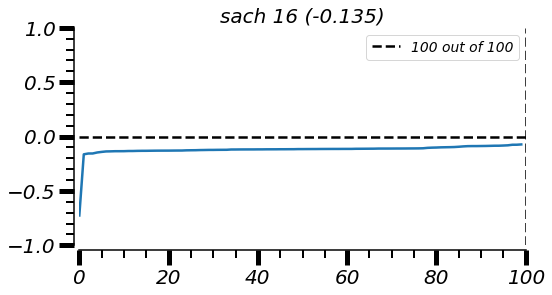

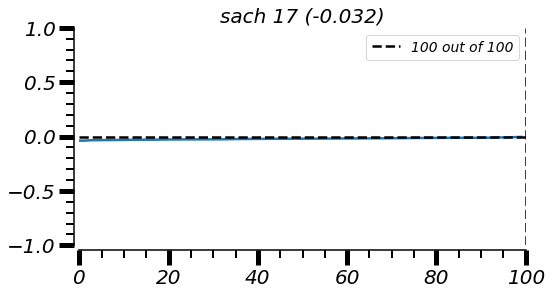

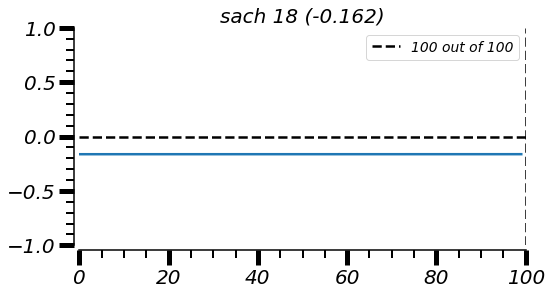

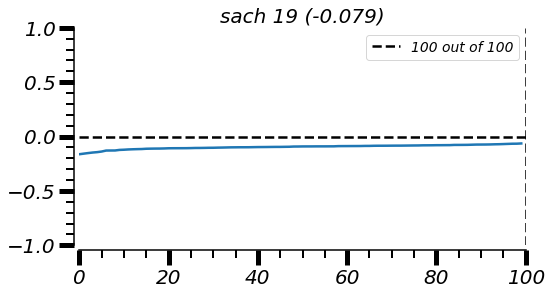

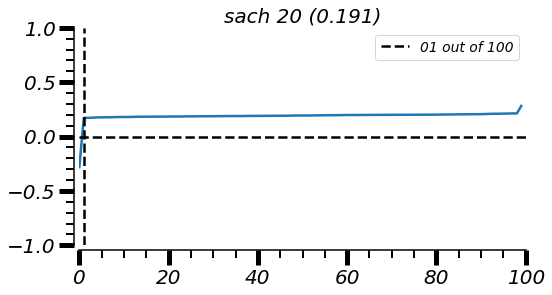

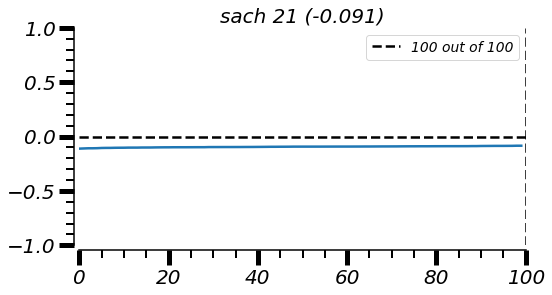

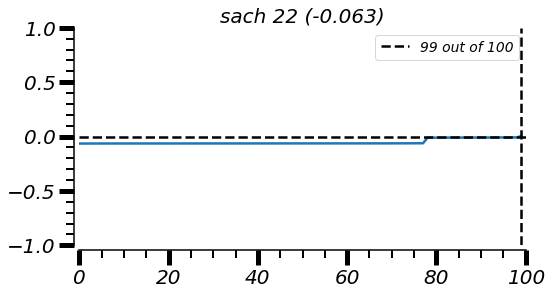

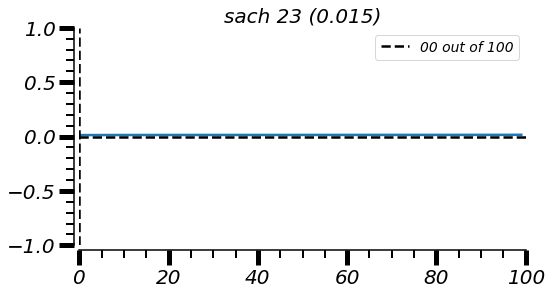

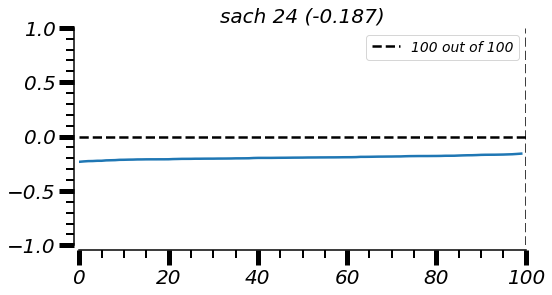

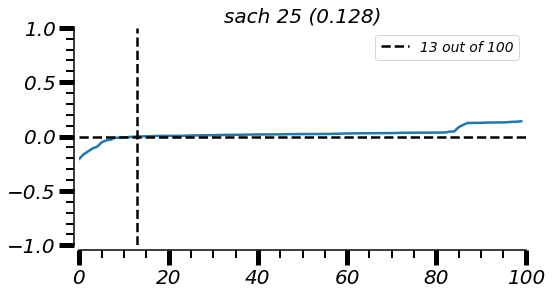

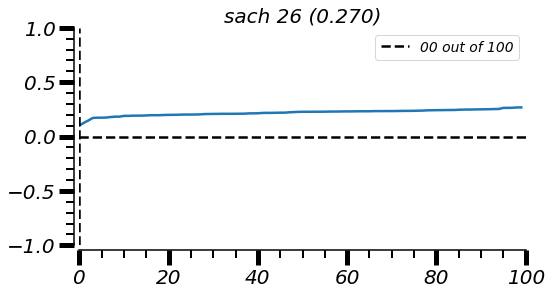

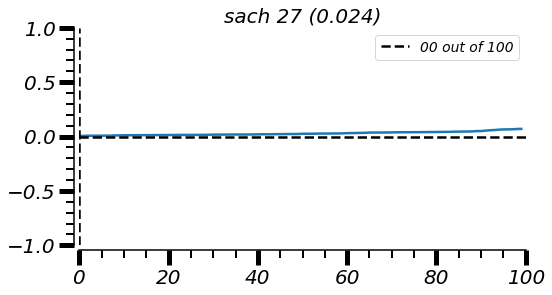

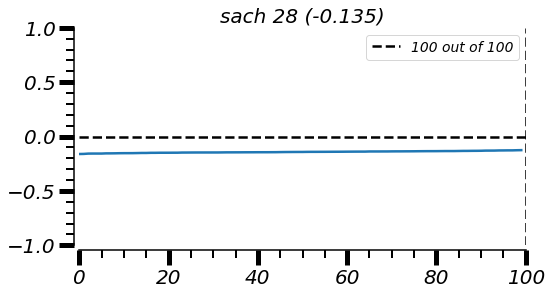

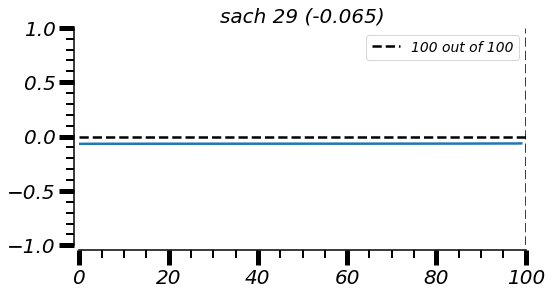

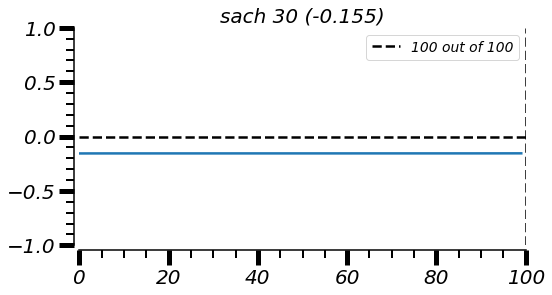

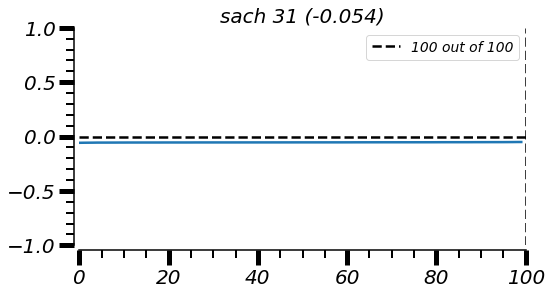

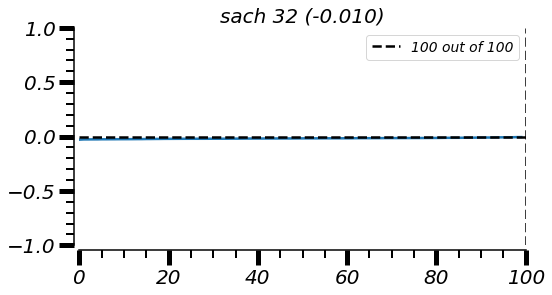

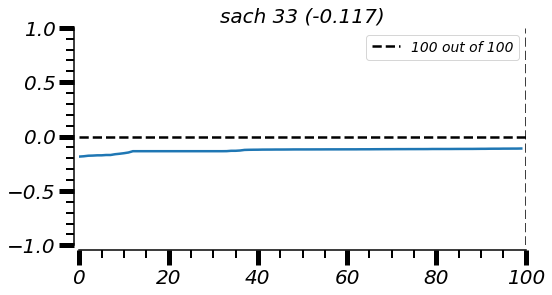

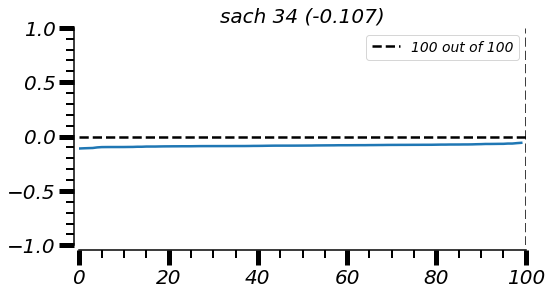

In [2007]:
for cl in range(len(jointList)):
    plt.figure(figsize=(8,4))
    og_slp = jointList[cl]['metrics']['dog_mod_slope'];
    slps = jointList[cl]['metrics']['boot_dog_mod_slope'];
    plt.plot(sorted(slps))
    n_lt0 = len(slps)-np.sum(slps>0);
    plt.axvline(n_lt0, color='k', linestyle='--', label='%02d out of %02d' % (n_lt0, len(slps)))
    plt.axhline(0, color='k', linestyle='--')
    plt.legend(fontsize='x-small');
    expdir = jointList[cl]['metadata']['fullPath'].split('/')[-3]
    cn = jointList[cl]['metadata']['cellNum']
    plt.title('%s %02d (%.3f)' % (expdir, cn, og_slp))
    plt.xlim([0,len(slps)]);
    plt.ylim([-1, 1])
    sns.despine(offset=5)

In [1957]:
jointList[5]['metrics']['dog_mod_slope']

-0.1774672

In [1956]:
jointList[5]['metrics'].keys()

dict_keys(['sfVar', 'sfCom', 'boot_sfCom_mn', 'boot_sfCom_md', 'boot_sfCom_std', 'boot_sfCom_stdLog', 'sfComCut', 'bw_sigma', 'lsfv', 'bwHalf', 'boot_bwHalf_mn', 'boot_bwHalf_md', 'boot_bwHalf_std', 'boot_bwHalf_stdLog', 'dog_bwHalf', 'boot_dog_bwHalf_mn', 'boot_dog_bwHalf_md', 'boot_dog_bwHalf_std', 'boot_dog_bwHalf_stdLog', 'bw34', 'boot_bw34_mn', 'boot_bw34_md', 'boot_bw34_std', 'boot_bw34_stdLog', 'dog_bw34', 'boot_dog_bw34_mn', 'boot_dog_bw34_md', 'boot_dog_bw34_std', 'boot_dog_bw34_stdLog', 'pSf', 'boot_pSf_mn', 'boot_pSf_md', 'boot_pSf_std', 'boot_pSf_stdLog', 'dog_pSf', 'boot_dog_pSf_mn', 'boot_dog_pSf_md', 'boot_dog_pSf_std', 'boot_dog_pSf_stdLog', 'sf70', 'boot_sf70_mn', 'boot_sf70_md', 'boot_sf70_std', 'boot_sf70_stdLog', 'dog_sf70', 'boot_dog_sf70_mn', 'boot_dog_sf70_md', 'boot_dog_sf70_std', 'boot_dog_sf70_stdLog', 'dog_charFreq', 'boot_dog_charFreq_mn', 'boot_dog_charFreq_md', 'boot_dog_charFreq_std', 'boot_dog_charFreq_stdLog', 'sfE', 'dog_sfE', 'sfVarExpl', 'dog_varExpl

In [1909]:
com, _ = hf.jl_get_metric_byCon(jointList, 'sfCom', conVal=1.0, disp=0, valIsFrac=True)
var, _ = hf.jl_get_metric_byCon(jointList, 'sfVar', conVal=1.0, disp=0, valIsFrac=True)

pSf, _ = hf.jl_get_metric_byCon(jointList, 'boot_%spSf_mn' % dog_suffix, conVal=1.0, disp=0, valIsFrac=True)
pSf_stdLog, _ = hf.jl_get_metric_byCon(jointList, 'boot_%spSf_stdLog' % dog_suffix, conVal=1.0, disp=0, valIsFrac=True)
# sf70
sf70, _ = hf.jl_get_metric_byCon(jointList, 'boot_%ssf70_mn' % dog_suffix, conVal=1.0, disp=0, valIsFrac=True)
sf70_stdLog, _ = hf.jl_get_metric_byCon(jointList, 'boot_%ssf70_stdLog' % dog_suffix, conVal=1.0,
                                        disp=0, valIsFrac=True)
sf70_third, _ = hf.jl_get_metric_byCon(jointList, 'boot_%ssf70_mn' % dog_suffix, conVal=0.33, conTol=0.065,
                                       disp=0, valIsFrac=True)
sf70_stdLog_third, _ = hf.jl_get_metric_byCon(jointList, 'boot_%ssf70_stdLog' % dog_suffix, conTol=0.065,
                                              conVal=0.33, disp=0, valIsFrac=True)
# charFreq
cFreq, _ = hf.jl_get_metric_byCon(jointList, 'boot_dog_charFreq_mn', conVal=1.0, disp=0, valIsFrac=True)
cFreq_stdLog, _ = hf.jl_get_metric_byCon(jointList, 'boot_dog_charFreq_stdLog', conVal=1.0,
                                        disp=0, valIsFrac=True)
cFreq_third, _ = hf.jl_get_metric_byCon(jointList, 'boot_dog_charFreq_mn', conVal=0.33, conTol=0.065,
                                       disp=0, valIsFrac=True)
cFreq_stdLog_third, _ = hf.jl_get_metric_byCon(jointList, 'boot_dog_charFreq_stdLog', conTol=0.065,
                                              conVal=0.33, disp=0, valIsFrac=True)
# bwHalf
bwHalf, _ = hf.jl_get_metric_byCon(jointList, 'boot_%sbwHalf_mn' % dog_suffix, conVal=1.0, disp=0, valIsFrac=True)
bwHalf_std, _ = hf.jl_get_metric_byCon(jointList, 'boot_%sbwHalf_std' % dog_suffix, conVal=1.0, disp=0, valIsFrac=True)
bwHalf_third, _ = hf.jl_get_metric_byCon(jointList, 'boot_%sbwHalf_mn' % dog_suffix, conVal=0.33, disp=0, 
                                         valIsFrac=True, conTol=0.065)

mega['com_h'] = com
mega['var_h'] = com

mega['pSf_mn'] = pSf
mega['pSf_stdLog'] = pSf_stdLog
mega['sf70_mn'] = sf70
mega['sf70_stdLog'] = sf70_stdLog
mega['sf70_mn_third'] = sf70_third
mega['sf70_stdLog_third'] = sf70_stdLog_third
mega['charFreq_mn'] = cFreq
mega['charFreq_stdLog'] = cFreq_stdLog
mega['charFreq_mn_third'] = cFreq_third
mega['charFreq_stdLog_third'] = cFreq_stdLog_third
mega['bwHalf_mn'] = bwHalf
mega['bwHalf_std'] = bwHalf_std
mega['bwHalf_mn_third'] = bwHalf_third

if whichArea == 'LGN':
    mega['conGain_max'] = np.array([np.nanmax(mega['conGain'][x][0]) for x in mega['conGain'].keys()])

In [1910]:
# simple lin. regression
def fn(B, x):
    return B[0]*x + B[1]
linear = odrpack.Model(fn)

In [1911]:
highSf, compSf, compCons = hf.jl_get_metric_highComp(jointList, 'boot_%ssf70_values' % dog_suffix, 0, 1);

##### Show that pSf and sf70 {and then charFreq} are correlated

Beta: [0.20500566 0.45719055]
Beta Std Error: [0.02539142 0.02678626]
Beta Covariance: [[3.06367380e-06 2.47381481e-06]
 [2.47381481e-06 3.40951591e-06]]
Residual Variance: 210.44154633949145
Inverse Condition #: 0.318467164689541
Reason(s) for Halting:
  Sum of squares convergence


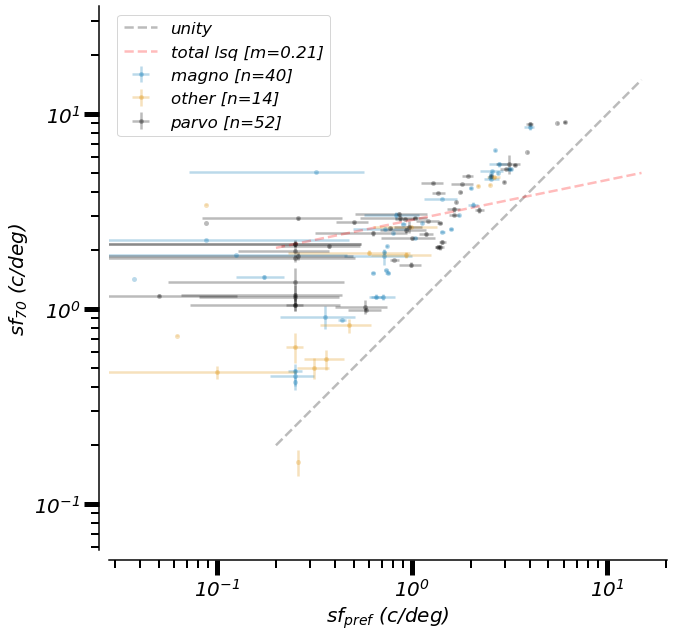

In [1912]:
saveName = '00_00_pSf_sf70_con%s.pdf' % dog_suffix_sv

non_nan = np.logical_and(~np.isnan(pSf), ~np.isnan(sf70));

pSf_stdLog[pSf_stdLog==0] = 1e-3
sf70_stdLog[sf70_stdLog==0] = 1e-3

mydata = odrpack.RealData(np.log10(pSf[non_nan]), np.log10(sf70[non_nan]), 
                          sx=pSf_stdLog[non_nan], sy=sf70_stdLog[non_nan])

# initial guess via simple correlation (ignoring errors)
init_guess = np.polyfit(np.log10(pSf[non_nan]), np.log10(sf70[non_nan]), deg=1)

myodr = odrpack.ODR(mydata, linear, beta0=np.flip(init_guess), iprint=2)
myodr.set_iprint(init=2, iter=2, final=2)
myoutput = myodr.run()
myoutput.pprint()


plt.figure(figsize=(10, 10));

grouped = mega.groupby(toGroup)

for (name, group), clr in zip(grouped, colors):
    ok = np.logical_and(~np.isnan(group['pSf_mn']), ~np.isnan(group['sf70_mn']));
    plt.errorbar(group['pSf_mn'], group['sf70_mn'], yerr=group['sf70_stdLog'], xerr=group['pSf_stdLog'], 
                 fmt='o', color=clr, alpha=alph, label='%s [n=%d]' % (name, len(ok)))

### Plot unity line, model; set up legend
plt.xscale('log')
plt.yscale('log')
plt.plot([2e-1, 1.5e1], [2e-1, 1.5e1], 'k--', alpha=alph, label='unity');
plt.axis('equal')

xvals = np.geomspace(2e-1, 1.5e1, 100)
plt.plot(xvals, np.power(10, fn(myoutput.beta, np.log10(xvals))), 
         'r--', label=r'total lsq [m=%.2f]' % (myoutput.beta[0]), alpha=alph);
plt.legend(fontsize='small')
plt.xlabel(r'$sf_{pref}$ (c/deg)')
plt.ylabel(r'$sf_{70}$ (c/deg)')
# plt.plot(xvals, np.power(10, f(init_guess, np.log10(xvals))), 'r--', label='1d reg', alpha=0.3);

sns.despine(offset=10);

# now save
if not os.path.exists(save_loc):
    os.makedirs(save_loc)
pdfSv = pltSave.PdfPages(save_loc + saveName);
f = plt.gcf()
pdfSv.savefig(f) # only one figure here...
pdfSv.close()


Beta: [0.20474744 0.55745788]
Beta Std Error: [0.04369686 0.03359182]
Beta Covariance: [[1.19009363e-05 5.27737260e-06]
 [5.27737260e-06 7.03311373e-06]]
Residual Variance: 160.44246377647733
Inverse Condition #: 0.4899670823919045
Reason(s) for Halting:
  Sum of squares convergence


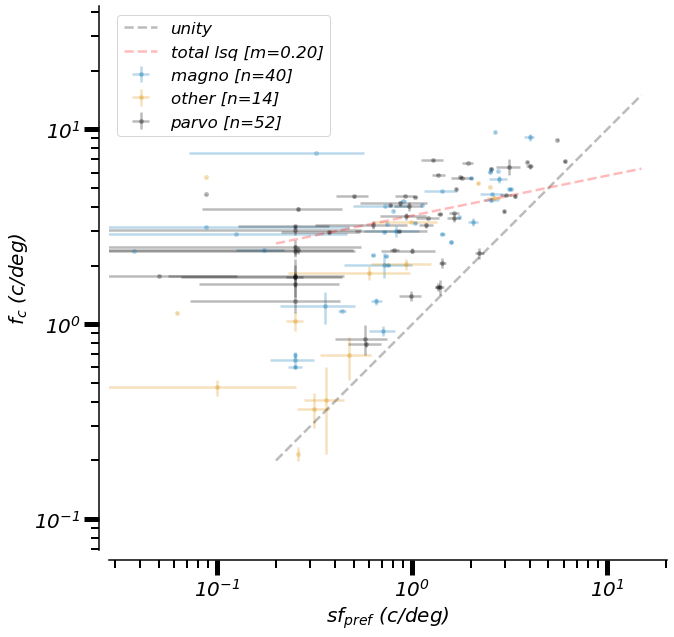

In [1913]:
saveName = '00_00alt_pSf_charFreq_con%s.pdf' % dog_suffix_sv

non_nan = np.logical_and(~np.isnan(pSf), ~np.isnan(sf70));

pSf_stdLog[pSf_stdLog==0] = 1e-3
sf70_stdLog[sf70_stdLog==0] = 1e-3

mydata = odrpack.RealData(np.log10(pSf[non_nan]), np.log10(cFreq[non_nan]), 
                          sx=pSf_stdLog[non_nan], sy=cFreq_stdLog[non_nan])

# initial guess via simple correlation (ignoring errors)
init_guess = np.polyfit(np.log10(pSf[non_nan]), np.log10(sf70[non_nan]), deg=1)

myodr = odrpack.ODR(mydata, linear, beta0=np.flip(init_guess), iprint=2)
myodr.set_iprint(init=2, iter=2, final=2)
myoutput = myodr.run()
myoutput.pprint()


plt.figure(figsize=(10, 10));

grouped = mega.groupby(toGroup)

for (name, group), clr in zip(grouped, colors):
    ok = np.logical_and(~np.isnan(group['pSf_mn']), ~np.isnan(group['charFreq_mn']));
    plt.errorbar(group['pSf_mn'], group['charFreq_mn'], yerr=group['charFreq_stdLog'], xerr=group['pSf_stdLog'], 
                 fmt='o', color=clr, alpha=alph, label='%s [n=%d]' % (name, len(ok)))

### Plot unity line, model; set up legend
plt.xscale('log')
plt.yscale('log')
plt.plot([2e-1, 1.5e1], [2e-1, 1.5e1], 'k--', alpha=alph, label='unity');
plt.axis('equal')

xvals = np.geomspace(2e-1, 1.5e1, 100)
plt.plot(xvals, np.power(10, fn(myoutput.beta, np.log10(xvals))), 
         'r--', label=r'total lsq [m=%.2f]' % (myoutput.beta[0]), alpha=alph);
plt.legend(fontsize='small')
plt.xlabel(r'$sf_{pref}$ (c/deg)')
plt.ylabel(r'$f_{c}$ (c/deg)')
# plt.plot(xvals, np.power(10, f(init_guess, np.log10(xvals))), 'r--', label='1d reg', alpha=0.3);

sns.despine(offset=10);

# now save
if not os.path.exists(save_loc):
    os.makedirs(save_loc)
pdfSv = pltSave.PdfPages(save_loc + saveName);
f = plt.gcf()
pdfSv.savefig(f) # only one figure here...
pdfSv.close()


##### Plot distribution of sf70 at highContrast

In [1914]:
sf70bins = np.linspace(-2, 4, 13)

In [1915]:
def bin_offsets(nBins, width):
    if np.mod(nBins,2) == 0: # i.e. even # of bins
        return width*np.linspace(-0.5-(nBins/2-1), 0.5+(nBins/2-1), nBins)
    else: # i.e. odd # of bins
        return width*np.linspace(-np.floor(nBins/2), np.floor(nBins/2), nBins)

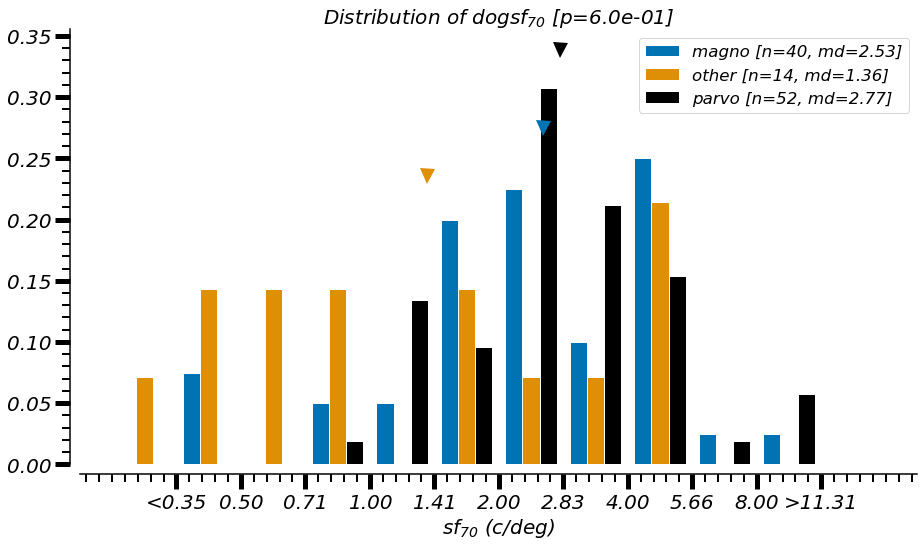

In [1916]:
maxCon = 1; # max con...
# maxCon = 0; # then we do 1/3 of max

lbl = '' if maxCon else '_third'

saveName = '00_01_sf70%s%s.pdf' % (lbl, dog_suffix_sv)

plt.figure(figsize=(15, 8));

grouped = mega.groupby(toGroup)

# gather and calculate
bins = sf70bins
stepSize = (bins[-1] - bins[0])/(len(bins)-1);
binPlotLocs = bins[1:] - 0.5*stepSize;
clipLow, clipHigh = bins[1]-0.5*stepSize, bins[-2]+0.5*stepSize;

tickVals = np.linspace(bins[1], bins[-2], len(bins)-2)

to_comp = [];

width = 0.8*stepSize/cnt;
offsets = bin_offsets(cnt, width);

for (name, group), clr, widOffset in zip(grouped, colors, offsets):
    clipped = [np.clip(np.log2(x), clipLow, clipHigh) for x in hf.nan_rm(group['sf70_mn%s' % lbl])];
    vals, _ = np.histogram(clipped, bins=bins)
    vals_norm = vals/np.sum(vals)

    # calculate
    # nSF = [len(x) for x in psfs_clipped]
    mdn = np.nanmedian(group['sf70_mn%s' % lbl]);
    # mnSF = [np.nanmean(x) for x in psfs];
    # gmnSF = [gmean(hf.nan_rm(x)) for x in psfs];

    plt.plot(np.log2(mdn), 1.1*np.max(vals_norm), 'v', color=clr, markersize=15)
    
    plt.bar(binPlotLocs+widOffset, vals_norm, width=width, align='center', color=clr,
            label='%s [n=%d, md=%.2f]' % (name, np.sum(vals), mdn), alpha=alphHist);
    tickStrs = ['%.2f' % np.power(2, x) for x in tickVals];
    tickStrs[0] = '<%s' % tickStrs[0];
    tickStrs[-1] = '>%s' % tickStrs[-1];
    plt.xticks(tickVals, tickStrs);
    
    if len(grouped) > 2: # i.e. it's LGN...
        if name == 'other':
            continue;
        to_comp.append(hf.nan_rm(group['sf70_mn%s' % lbl]))
    else:
        to_comp.append(hf.nan_rm(group['sf70_mn%s' % lbl]))
    
plt.xlabel(r'$sf_{70}$ (c/deg)');
ttest = ss.ttest_ind(*to_comp);
plt.title(r'Distribution of $%ssf_{70}$ [p=%.1e]' % (dog_suffix_plt, ttest.pvalue))#' [%s] (%s, n=%d, median=%.2f, mn=%.2f, gmn=%.2f)' % (fitStr[i], whichArea, nSF[i], medianSF[i], mnSF[i], gmnSF[i]));
plt.legend(fontsize='small')

sns.despine(offset=10);

# now save
if not os.path.exists(save_loc):
    os.makedirs(save_loc)
pdfSv = pltSave.PdfPages(save_loc + saveName);
f = plt.gcf()
pdfSv.savefig(f) # only one figure here...
pdfSv.close()


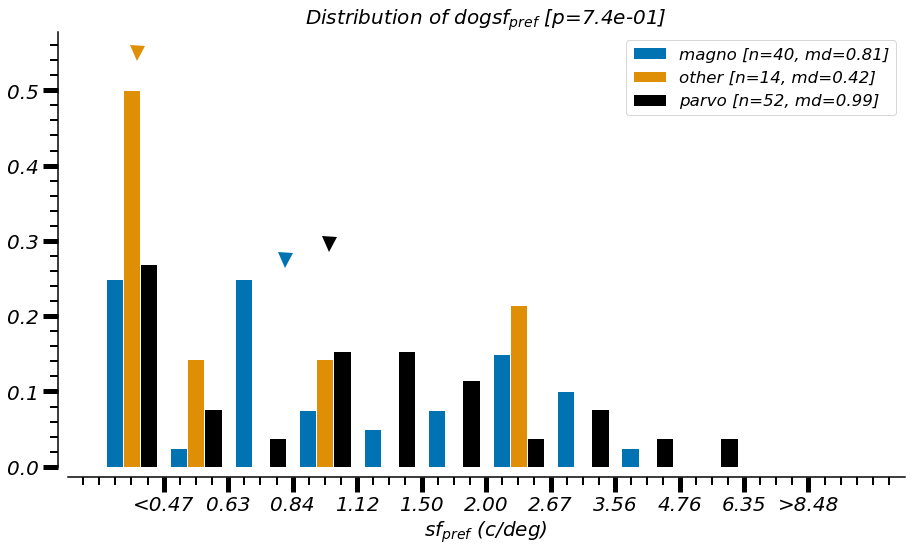

In [1917]:
saveName = '00_01alt_pSf_highCon%s.pdf' % dog_suffix_sv

plt.figure(figsize=(15, 8));

grouped = mega.groupby(toGroup)

# gather and calculate
pSfBins = np.linspace(-1.5, 3.5, 13);
bins = pSfBins#sf70bins
stepSize = (bins[-1] - bins[0])/(len(bins)-1);
binPlotLocs = bins[1:] - 0.5*stepSize;
clipLow, clipHigh = bins[1]-0.5*stepSize, bins[-2]+0.5*stepSize;

tickVals = np.linspace(bins[1], bins[-2], len(bins)-2)

to_comp = [];

width = 0.8*stepSize/cnt;
offsets = bin_offsets(cnt, width);

for (name, group), clr, widOffset in zip(grouped, colors, offsets):
    clipped = [np.clip(np.log2(x), clipLow, clipHigh) for x in hf.nan_rm(group['pSf_mn'])];
    vals, _ = np.histogram(clipped, bins=bins)
    vals_norm = vals/np.sum(vals)

    # calculate
    # nSF = [len(x) for x in psfs_clipped]
    mdn = np.nanmedian(group['pSf_mn']);
    # mnSF = [np.nanmean(x) for x in psfs];
    # gmnSF = [gmean(hf.nan_rm(x)) for x in psfs];

    plt.plot(np.log2(mdn), 1.1*np.max(vals_norm), 'v', color=clr, markersize=15)
    
    plt.bar(binPlotLocs+widOffset, vals_norm, width=width, align='center', color=clr,
            label='%s [n=%d, md=%.2f]' % (name, np.sum(vals), mdn), alpha=alphHist);
    tickStrs = ['%.2f' % np.power(2, x) for x in tickVals];
    tickStrs[0] = '<%s' % tickStrs[0];
    tickStrs[-1] = '>%s' % tickStrs[-1];
    plt.xticks(tickVals, tickStrs);
   
    if len(grouped) > 2: # i.e. it's LGN...
        if name == 'other':
            continue;
        to_comp.append(hf.nan_rm(group['pSf_mn']))
    else:
        to_comp.append(hf.nan_rm(group['pSf_mn']))
    
ttest = ss.ttest_ind(*to_comp);
plt.xlabel(r'$sf_{pref}$ (c/deg)');
plt.title(r'Distribution of $%ssf_{pref}$ [p=%.1e]' % (dog_suffix_plt, ttest.pvalue))#' [%s] (%s, n=%d, median=%.2f, mn=%.2f, gmn=%.2f)' % (fitStr[i], whichArea, nSF[i], medianSF[i], mnSF[i], gmnSF[i]));
plt.legend(fontsize='small')

sns.despine(offset=10);

# now save
if not os.path.exists(save_loc):
    os.makedirs(save_loc)
pdfSv = pltSave.PdfPages(save_loc + saveName);
f = plt.gcf()
pdfSv.savefig(f) # only one figure here...
pdfSv.close()


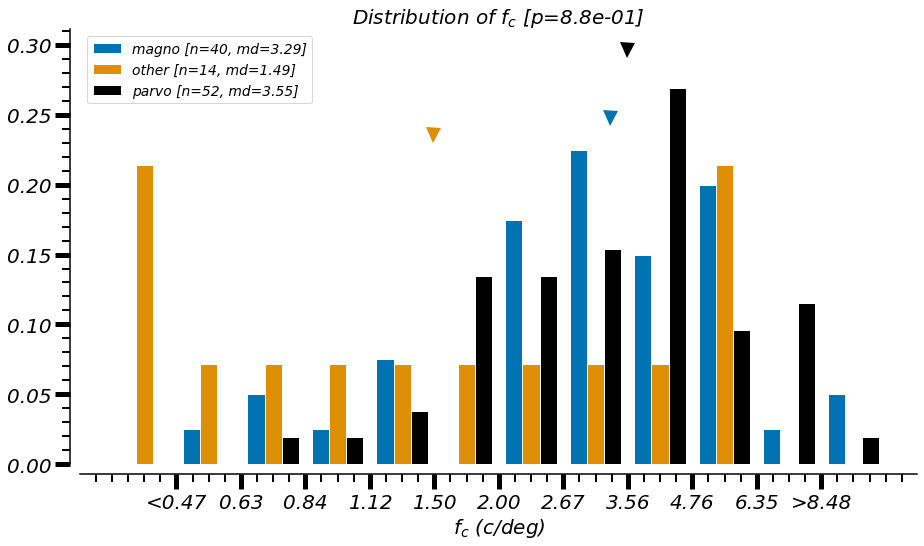

In [1918]:
saveName = '00_01alt_charFreq.pdf'

plt.figure(figsize=(15, 8));

grouped = mega.groupby(toGroup)

# gather and calculate
pSfBins = np.linspace(-1.5, 3.5, 13);
bins = pSfBins#sf70bins
stepSize = (bins[-1] - bins[0])/(len(bins)-1);
binPlotLocs = bins[1:] - 0.5*stepSize;
clipLow, clipHigh = bins[1]-0.5*stepSize, bins[-2]+0.5*stepSize;

tickVals = np.linspace(bins[1], bins[-2], len(bins)-2)

to_comp = [];

width = 0.8*stepSize/cnt;
offsets = bin_offsets(cnt, width);

for (name, group), clr, widOffset in zip(grouped, colors, offsets):
    clipped = [np.clip(np.log2(x), clipLow, clipHigh) for x in hf.nan_rm(group['charFreq_mn'])];
    vals, _ = np.histogram(clipped, bins=bins)
    vals_norm = vals/np.sum(vals)

    # calculate
    # nSF = [len(x) for x in psfs_clipped]
    mdn = np.nanmedian(group['charFreq_mn']);
    # mnSF = [np.nanmean(x) for x in psfs];
    # gmnSF = [gmean(hf.nan_rm(x)) for x in psfs];

    plt.plot(np.log2(mdn), 1.1*np.max(vals_norm), 'v', color=clr, markersize=15)
    
    plt.bar(binPlotLocs+widOffset, vals_norm, width=width, align='center', color=clr,
            label='%s [n=%d, md=%.2f]' % (name, np.sum(vals), mdn), alpha=alphHist);
    tickStrs = ['%.2f' % np.power(2, x) for x in tickVals];
    tickStrs[0] = '<%s' % tickStrs[0];
    tickStrs[-1] = '>%s' % tickStrs[-1];
    plt.xticks(tickVals, tickStrs);
   
    if len(grouped) > 2: # i.e. it's LGN...
        if name == 'other':
            continue;
        to_comp.append(hf.nan_rm(group['charFreq_mn']))
    else:
        to_comp.append(hf.nan_rm(group['charFreq_mn']))
    
ttest = ss.ttest_ind(*to_comp);
plt.xlabel(r'$f_c$ (c/deg)');
plt.title(r'Distribution of $f_c$ [p=%.1e]' % (ttest.pvalue))#' [%s] (%s, n=%d, median=%.2f, mn=%.2f, gmn=%.2f)' % (fitStr[i], whichArea, nSF[i], medianSF[i], mnSF[i], gmnSF[i]));
plt.legend(fontsize='x-small')

sns.despine(offset=10);

# now save
if not os.path.exists(save_loc):
    os.makedirs(save_loc)
pdfSv = pltSave.PdfPages(save_loc + saveName);
f = plt.gcf()
pdfSv.savefig(f) # only one figure here...
pdfSv.close()


##### Max. con gain (if LGN, only)

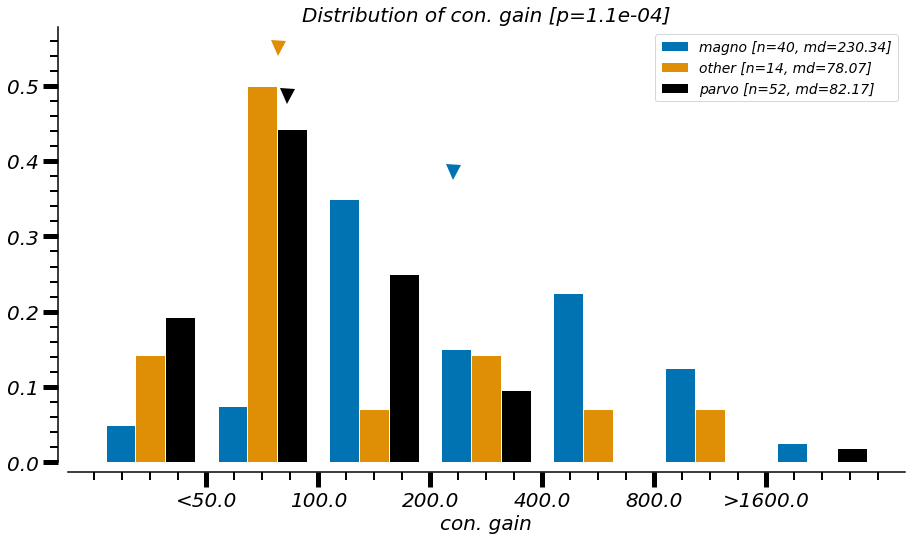

In [1919]:
if whichArea == 'LGN':
    
    nBins = 8
    conGain_bins = np.log10(np.geomspace(25, 25*np.power(2, nBins-1), nBins));
    
    saveName = '00_01alt_conGain.pdf'

    plt.figure(figsize=(15, 8));

    grouped = mega.groupby(toGroup)

    # gather and calculate
    bins = conGain_bins
    stepSize = (bins[-1] - bins[0])/(len(bins)-1);
    binPlotLocs = bins[1:] - 0.5*stepSize;
    clipLow, clipHigh = bins[1]-0.5*stepSize, bins[-2]+0.5*stepSize;

    tickVals = np.linspace(bins[1], bins[-2], len(bins)-2)

    to_comp = [];
    
    width = 0.8*stepSize/cnt;
    offsets = bin_offsets(cnt, width);
    
    for (name, group), clr, widOffset in zip(grouped, colors, offsets):
        clipped = [np.clip(np.log10(x), clipLow, clipHigh) for x in hf.nan_rm(group['conGain_max'])];
        vals, _ = np.histogram(clipped, bins=bins)
        vals_norm = vals/np.sum(vals)

        # calculate
        # nSF = [len(x) for x in psfs_clipped]
        mdn = np.nanmedian(group['conGain_max']);
        # mnSF = [np.nanmean(x) for x in psfs];
        # gmnSF = [gmean(hf.nan_rm(x)) for x in psfs];

        plt.plot(np.log10(mdn), 1.1*np.max(vals_norm), 'v', color=clr, markersize=15)

        plt.bar(binPlotLocs+widOffset, vals_norm, width=width, align='center', color=clr,
                label='%s [n=%d, md=%.2f]' % (name, np.sum(vals), mdn), alpha=alphHist);
        tickStrs = ['%.1f' % np.power(10, x) for x in tickVals];
        tickStrs[0] = '<%s' % tickStrs[0];
        tickStrs[-1] = '>%s' % tickStrs[-1];
        plt.xticks(tickVals, tickStrs);
        
        if len(grouped) > 2: # i.e. it's LGN...
            if name == 'other':
                continue;
            to_comp.append(hf.nan_rm(group['conGain_max']))
        else:
            to_comp.append(hf.nan_rm(group['conGain_max']))

    ttest = ss.ttest_ind(*to_comp);
    plt.xlabel('con. gain');
    plt.title('Distribution of con. gain [p=%.1e]' % ttest.pvalue)#' [%s] (%s, n=%d, median=%.2f, mn=%.2f, gmn=%.2f)' % (fitStr[i], whichArea, nSF[i], medianSF[i], mnSF[i], gmnSF[i]));
    plt.legend(fontsize='x-small')

    sns.despine(offset=10);

    # now save
    if not os.path.exists(save_loc):
        os.makedirs(save_loc)
    pdfSv = pltSave.PdfPages(save_loc + saveName);
    f = plt.gcf()
    pdfSv.savefig(f) # only one figure here...
    pdfSv.close()


##### Plot distribution of bwHalf at highContrast

In [1920]:
bwHalfbins = np.linspace(0, 6, 13);# np.linspace(0, 4, 13)

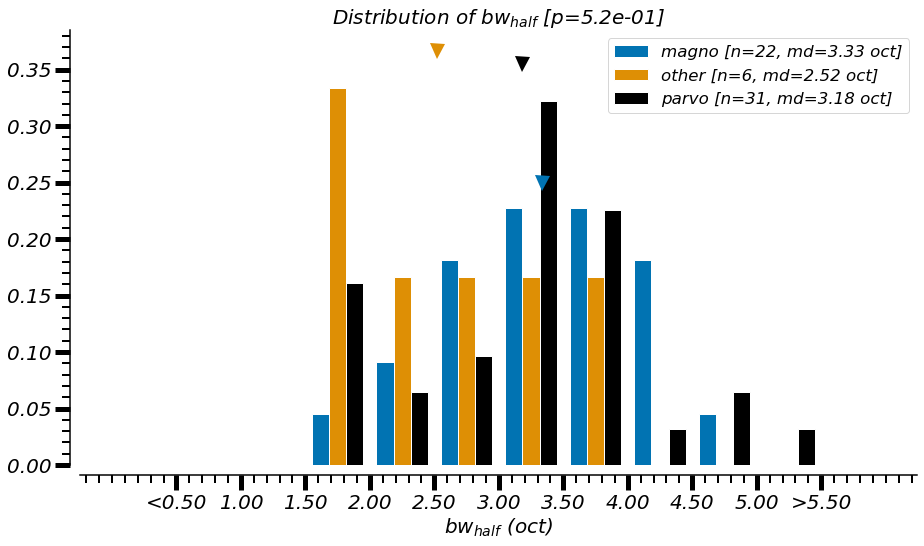

In [1921]:
maxCon = 1; # max con...
# maxCon = 0; # then we do 1/3 of max

lbl = '' if maxCon else '_third'

saveName = '00_02_bwHalf%s%s.pdf' % (lbl, dog_suffix_sv)

non_nan = ~np.isnan(pSf);

plt.figure(figsize=(15, 8));

grouped = mega.groupby(toGroup)

# gather and calculate
bins = bwHalfbins
stepSize = (bins[-1] - bins[0])/(len(bins)-1);
binPlotLocs = bins[1:] - 0.5*stepSize;
clipLow, clipHigh = bins[1]-0.5*stepSize, bins[-2]+0.5*stepSize;

tickVals = np.linspace(bins[1], bins[-2], len(bins)-2)

to_comp = [];

width = 0.8*stepSize/cnt;
offsets = bin_offsets(cnt, width);

for (name, group), clr, widOffset in zip(grouped, colors, offsets):
    clipped = [np.clip(x, clipLow, clipHigh) for x in hf.nan_rm(group['bwHalf_mn%s' % lbl])];
    vals, _ = np.histogram(clipped, bins=bins)
    vals_norm = vals/np.sum(vals)

    # calculate
    # nSF = [len(x) for x in psfs_clipped]
    mdn = np.nanmedian(group['bwHalf_mn%s' % lbl]);
    # mnSF = [np.nanmean(x) for x in psfs];
    # gmnSF = [gmean(hf.nan_rm(x)) for x in psfs];

    plt.plot(mdn, 1.1*np.max(vals_norm), 'v', color=clr, markersize=15)
    
    plt.bar(binPlotLocs+widOffset, vals_norm, width=width, align='center', color=clr,
            label='%s [n=%d, md=%.2f oct]' % (name, np.sum(vals), mdn), alpha=alphHist);
    tickStrs = ['%.2f' % x for x in tickVals];
    tickStrs[0] = '<%s' % tickStrs[0];
    tickStrs[-1] = '>%s' % tickStrs[-1];
    plt.xticks(tickVals, tickStrs);

    if len(grouped) > 2: # i.e. it's LGN...
        if name == 'other':
            continue;
        to_comp.append(hf.nan_rm(group['bwHalf_mn%s' % lbl]))
    else:
        to_comp.append(hf.nan_rm(group['bwHalf_mn%s' % lbl]))

ttest = ss.ttest_ind(*to_comp);
    
plt.xlabel(r'$bw_{half}$ (oct)');
plt.title(r'Distribution of $bw_{half}$ [p=%.1e]' % ttest.pvalue)#' [%s] (%s, n=%d, median=%.2f, mn=%.2f, gmn=%.2f)' % (fitStr[i], whichArea, nSF[i], medianSF[i], mnSF[i], gmnSF[i]));
plt.legend(fontsize='small')

sns.despine(offset=10);

# now save
if not os.path.exists(save_loc):
    os.makedirs(save_loc)
pdfSv = pltSave.PdfPages(save_loc + saveName);
f = plt.gcf()
pdfSv.savefig(f) # only one figure here...
pdfSv.close()


##### Ask if sf70 and bwHalf are correlated?

Beta: [ 0.25141314 -0.5084117 ]
Beta Std Error: [0.04140335 0.15212932]
Beta Covariance: [[ 0.00012758 -0.00045426]
 [-0.00045426  0.00172241]]
Residual Variance: 13.436605852346766
Inverse Condition #: 0.05583572960782422
Reason(s) for Halting:
  Sum of squares convergence


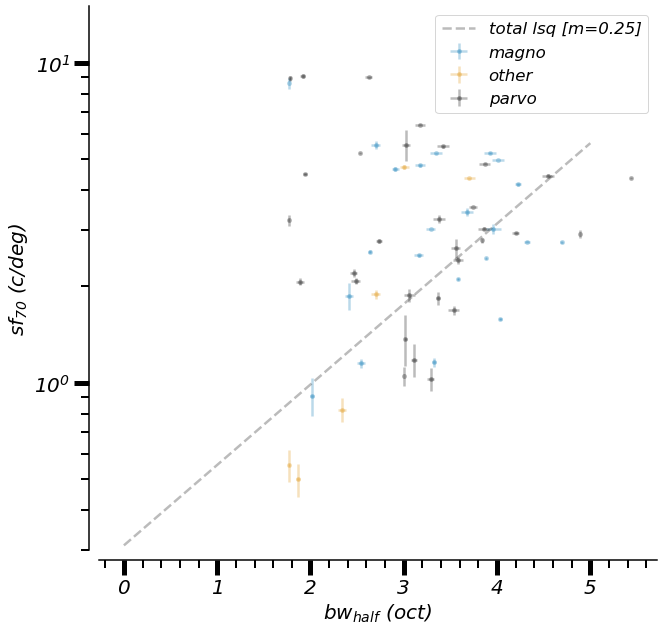

In [1922]:
saveName = '00_03a_bwHalf_sf70%s.pdf' % dog_suffix_sv

non_nan = np.logical_and(~np.isnan(bwHalf), ~np.isnan(sf70));

sf70[sf70_stdLog==0] = 1e-3
bwHalf_std[bwHalf_std==0] = 1e-3

mydata = odrpack.RealData(bwHalf[non_nan], np.log10(sf70[non_nan]), 
                          sx=bwHalf_std[non_nan], sy=sf70_stdLog[non_nan])

# initial guess via simple correlation (ignoring errors)
init_guess = np.polyfit(bwHalf[non_nan], np.log10(sf70[non_nan]), deg=1)

myodr = odrpack.ODR(mydata, linear, beta0=np.flip(init_guess), iprint=2)
myodr.set_iprint(init=2, iter=2, final=2)
myoutput = myodr.run()
myoutput.pprint()


plt.figure(figsize=(10, 10));

grouped = mega.groupby(toGroup)

for (name, group), clr in zip(grouped, colors):
    plt.errorbar(group['bwHalf_mn'], group['sf70_mn'], yerr=group['sf70_stdLog'], xerr=0.1*group['bwHalf_std'], 
                 fmt='o', alpha=alph, label=name, color=clr)

### Plot unity line, model; set up legend
# plt.xscale('log')
plt.yscale('log')
plt.ylim([3e-1, 1.5e1])
# plt.plot([2e-1, 1.5e1], [2e-1, 1.5e1], 'k--', alpha=0.3, label='unity');

xvals = np.linspace(0, 5, 100)
plt.plot(xvals, np.power(10, fn(myoutput.beta, xvals)), 
         'k--', label=r'total lsq [m=%.2f]' % (myoutput.beta[0]), alpha=alph);
plt.legend(fontsize='small')
plt.xlabel(r'$bw_{half}$ (oct)')
plt.ylabel(r'$sf_{70}$ (c/deg)')
# plt.plot(xvals, np.power(10, f(init_guess, np.log10(xvals))), 'r--', label='1d reg', alpha=0.3);

sns.despine(offset=10);

# now save
if not os.path.exists(save_loc):
    os.makedirs(save_loc)
pdfSv = pltSave.PdfPages(save_loc + saveName);
f = plt.gcf()
pdfSv.savefig(f) # only one figure here...
pdfSv.close()


Beta: [2.11308535 2.90208801]
Beta Std Error: [0.8457012 0.3087229]
Beta Covariance: [[ 0.09912405 -0.03272437]
 [-0.03272437  0.01320939]]
Residual Variance: 7.215307939504162
Inverse Condition #: 0.08349270926421956
Reason(s) for Halting:
  Sum of squares convergence
Beta: [1.61654972 2.26428297]
Beta Std Error: [0.25340415 0.08250976]
Beta Covariance: [[0.17315241 0.02422894]
 [0.02422894 0.01835742]]
Residual Variance: 0.37085055178754717
Inverse Condition #: 0.3042000869822621
Reason(s) for Halting:
  Sum of squares convergence
Beta: [ 3.38721809 -0.39564827]
Beta Std Error: [0. 0.]
Beta Covariance: [[0. 0.]
 [0. 0.]]
Residual Variance: 0.0
Inverse Condition #: 0.0
Reason(s) for Halting:
  Numerical error detected


/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/scipy/odr/odrpack.py:393: RuntimeWarning: divide by zero encountered in true_divide
  return 1./numpy.power(sd, 2)


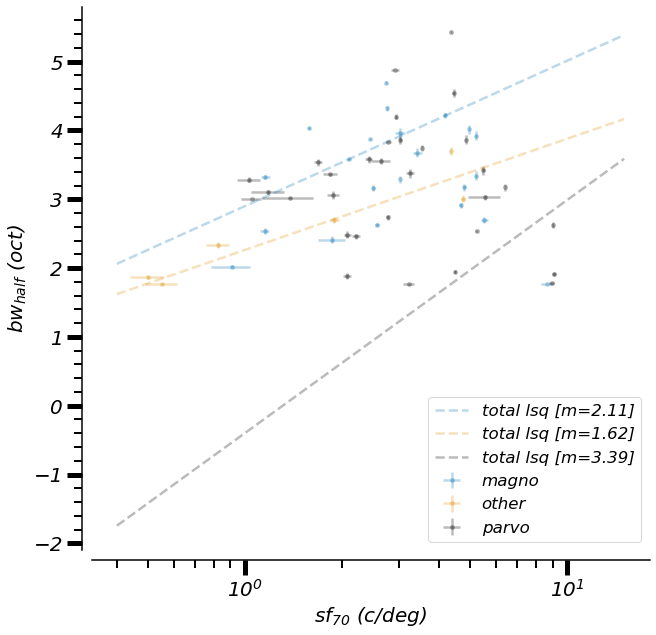

In [1923]:
saveName = '00_03b_sf70_bwHalf%s.pdf' % dog_suffix_sv

non_nan = np.logical_and(~np.isnan(bwHalf), ~np.isnan(sf70));

pSf_stdLog[pSf_stdLog==0] = 1e-3


plt.figure(figsize=(10, 10));

grouped = mega.groupby(toGroup)

for (name, group), clr in zip(grouped, colors):
    plt.errorbar(group['sf70_mn'], group['bwHalf_mn'], xerr=group['sf70_stdLog'], yerr=0.1*group['bwHalf_std'], 
                 fmt='o', alpha=alph, label=name, color=clr)
    
    nn = np.logical_and(~np.isnan(group['sf70_mn']), ~np.isnan(group['bwHalf_mn']));
    
    
    mydata = odrpack.RealData(np.log10(group['sf70_mn'][nn]), group['bwHalf_mn'][nn], 
                              sy=group['bwHalf_std'][nn], sx=group['sf70_stdLog'][nn])

    # initial guess via simple correlation (ignoring errors)
    init_guess = np.polyfit(np.log10(group['sf70_mn'][nn]), group['bwHalf_mn'][nn], deg=1)

    myodr = odrpack.ODR(mydata, linear, beta0=np.flip(init_guess), iprint=2)
    myodr.set_iprint(init=2, iter=2, final=2)
    myoutput = myodr.run()
    myoutput.pprint()

    xvals = np.geomspace(4e-1, 1.5e1, 100)
    plt.plot(xvals, fn(myoutput.beta, np.log10(xvals)), 
             '--', color=clr, label=r'total lsq [m=%.2f]' % (myoutput.beta[0]), alpha=alph);
    

### Plot unity line, model; set up legend
plt.xscale('log')
# plt.yscale('log')
# plt.plot([2e-1, 1.5e1], [2e-1, 1.5e1], 'k--', alpha=0.3, label='unity');

plt.legend(fontsize='small')
plt.ylabel(r'$bw_{half}$ (oct)')
plt.xlabel(r'$sf_{70}$ (c/deg)')
# plt.plot(xvals, np.power(10, f(init_guess, np.log10(xvals))), 'r--', label='1d reg', alpha=0.3);

sns.despine(offset=10);

# now save
if not os.path.exists(save_loc):
    os.makedirs(save_loc)
pdfSv = pltSave.PdfPages(save_loc + saveName);
f = plt.gcf()
pdfSv.savefig(f) # only one figure here...
pdfSv.close()


## 1. Tuning shifts with contrast

##### First, let's compute the ratios (and std. of ratios)

In [1924]:
def match_lengths(x):
    # fill with NaN to make sure that all lists in the array have the same length
    max_len = np.max([len(xp) for xp in x])
    for i, xp in enumerate(x):
        if len(xp) < max_len:
            tmp = np.nan * np.zeros((max_len, ));
            tmp[0:len(xp)] = xp
            x[i] = tmp
            
    return np.stack(x)

In [1925]:
### First, ratios/diffs at one-third contrast

cf, cf_third, hiCon, loCon = hf.jl_get_metric_highComp(jointList, 'boot_%scharFreq_values' % dog_suffix, whichMod=isDog, atLowest=0, returnBothCons=True)
sf70, sf70_third, hiCon, loCon = hf.jl_get_metric_highComp(jointList, 'boot_%sbwHalf_values' % dog_suffix, whichMod=isDog, atLowest=0, returnBothCons=True)
bwHalf, bwHalf_third, hiCon, loCon = hf.jl_get_metric_highComp(jointList, 'boot_%sbwHalf_values' % dog_suffix, whichMod=isDog, atLowest=0, returnBothCons=True)

cf = match_lengths(cf)
cf_third = match_lengths(cf_third)
sf70 = match_lengths(sf70)
sf70_third = match_lengths(sf70_third)
bwHalf = match_lengths(bwHalf)
bwHalf_third = match_lengths(bwHalf_third)

for i, lbl in enumerate(['', '_norm']):
    
    if i == 0:
        conRat = 1;
    else:
        conRat = np.log2(np.divide(hiCon, loCon))

        
    cf_rats = np.divide(np.nanmean(np.log2(np.divide(cf, cf_third)), axis=1), conRat)
    cf_rats_std = np.divide(np.nanstd(np.log2(np.divide(cf, cf_third)), axis=1), conRat)
    sf70_rats = np.divide(np.nanmean(np.log2(np.divide(sf70, sf70_third)), axis=1), conRat)
    sf70_rats_std = np.divide(np.nanstd(np.log2(np.divide(sf70, sf70_third)), axis=1), conRat)
    bwHalf_diffs = np.divide(np.nanmean(np.subtract(bwHalf, bwHalf_third), axis=1), conRat)
    bwHalf_diffs_std = np.divide(np.nanstd(np.subtract(bwHalf, bwHalf_third), axis=1), conRat)

    mega['boot_cf_rats_third%s' % lbl] = cf_rats
    mega['boot_cf_rats_std_third%s' % lbl] = cf_rats_std
    mega['boot_sf70_rats_third%s' % lbl] = sf70_rats
    mega['boot_sf70_rats_std_third%s' % lbl] = sf70_rats_std
    mega['boot_bwHalf_diffs_third%s' % lbl] = bwHalf_diffs
    mega['boot_bwHalf_diffs_std_third%s' % lbl] = bwHalf_diffs_std

### Then, ratios/diffs at lowest valid

cf, cf_lo, hiCon, loCon = hf.jl_get_metric_highComp(jointList, 'boot_dog_charFreq_values', whichMod=isDog, atLowest=1, returnBothCons=True)
sf70, sf70_lo, hiCon, loCon = hf.jl_get_metric_highComp(jointList, 'boot_sf70_values', whichMod=isDog, atLowest=1, returnBothCons=True)
bwHalf, bwHalf_lo, hiCon, loCon = hf.jl_get_metric_highComp(jointList, 'boot_%sbwHalf_values' % dog_suffix, whichMod=isDog, atLowest=1, returnBothCons=True)

cf = match_lengths(cf)
cf_lo = match_lengths(cf_lo)
sf70 = match_lengths(sf70)
sf70_lo = match_lengths(sf70_lo)
bwHalf = match_lengths(bwHalf)
bwHalf_lo = match_lengths(bwHalf_lo)

for i, lbl in enumerate(['', '_norm']):
    
    if i == 0:
        conRat = 1;
    else:
        conRat = np.log2(np.divide(hiCon, loCon))

    cf_rats = np.divide(np.nanmean(np.log2(np.divide(cf, cf_lo)), axis=1), conRat)
    cf_rats_std = np.divide(np.nanstd(np.log2(np.divide(cf, cf_lo)), axis=1), conRat)
    sf70_rats = np.divide(np.nanmean(np.log2(np.divide(sf70, sf70_lo)), axis=1), conRat)
    sf70_rats_std = np.divide(np.nanstd(np.log2(np.divide(sf70, sf70_lo)), axis=1), conRat)
    bwHalf_diffs = np.divide(np.nanmean(np.subtract(bwHalf, bwHalf_lo), axis=1), conRat)
    bwHalf_diffs_std = np.divide(np.nanstd(np.subtract(bwHalf, bwHalf_lo), axis=1), conRat)

    mega['boot_cf_rats_lowest%s' % lbl] = cf_rats
    mega['boot_cf_rats_std_lowest%s' % lbl] = cf_rats_std
    mega['boot_sf70_rats_lowest%s' % lbl] = sf70_rats
    mega['boot_sf70_rats_std_lowest%s' % lbl] = sf70_rats_std
    mega['boot_bwHalf_diffs_lowest%s' % lbl] = bwHalf_diffs
    mega['boot_bwHalf_diffs_std_lowest%s' % lbl] = bwHalf_diffs_std

/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: Mean of empty slice
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/arc/2.2/p1/plevy/SF_diversity/sfDiv-OriModel/sfDiv-python/helper_fcns.py:4355: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  ''' Given cell structure (and opt model responses), returns the following:
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in true_divide


#### 1.01 - $f_c$ across contrast (ratio, as hist)

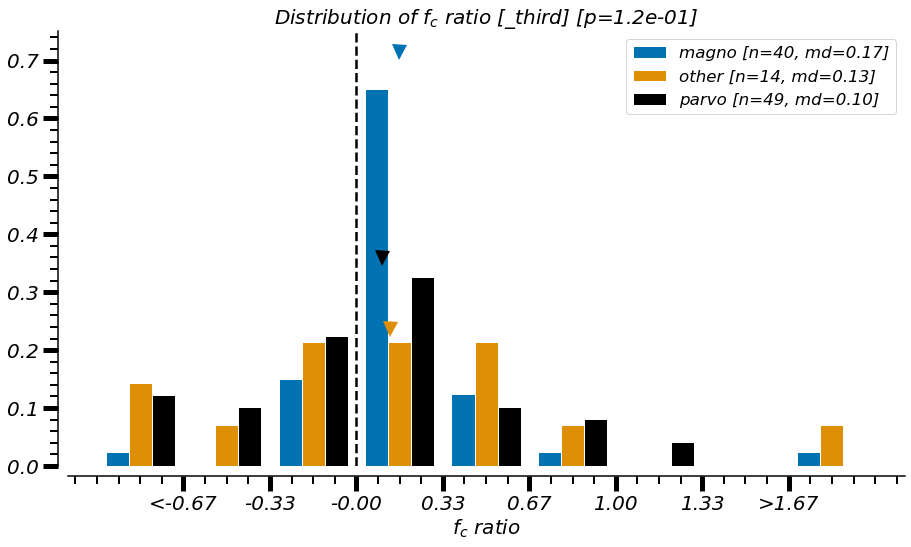

In [1926]:
# fixedCon = 0; # if fixed con., then eval. at one third; otherwise, lowest valid con.
fixedCon = 1; # if fixed con., then eval. at one third; otherwise, lowest valid con.
norm = 0; # normalize?

lbl = '_third' if fixedCon else '_lowest'
lbl = '%s_norm' % lbl if norm else '%s' % lbl

saveName = '01_01_cf_rat%s%s.pdf' % (lbl, dog_suffix_sv)

if norm:
    sf70bins_ratio = np.linspace(-0.5,1,10)
else:
    sf70bins_ratio = np.linspace(-1,2,10)

plt.figure(figsize=(15, 8));

grouped = mega.groupby(toGroup)

# gather and calculate
bins = sf70bins_ratio
stepSize = (bins[-1] - bins[0])/(len(bins)-1);
binPlotLocs = bins[1:] - 0.5*stepSize;
clipLow, clipHigh = bins[1]-0.5*stepSize, bins[-2]+0.5*stepSize;

tickVals = np.linspace(bins[1], bins[-2], len(bins)-2)

to_comp = [];

width = 0.8*stepSize/cnt;
offsets = bin_offsets(cnt, width);

for (name, group), clr, widOffset in zip(grouped, colors, offsets):
    clipped = [np.clip(x, clipLow, clipHigh) for x in hf.nan_rm(group['boot_cf_rats%s' % lbl])];
    vals, _ = np.histogram(clipped, bins=bins)
    vals_norm = vals/np.sum(vals)

    # calculate
    # nSF = [len(x) for x in psfs_clipped]
    mdn = np.nanmedian(group['boot_cf_rats%s' % lbl]);
    # mnSF = [np.nanmean(x) for x in psfs];
    # gmnSF = [gmean(hf.nan_rm(x)) for x in psfs];

    plt.plot(mdn, 1.1*np.max(vals_norm), 'v', color=clr, markersize=15)
    
    plt.bar(binPlotLocs+widOffset, vals_norm, width=width, align='center', color=clr,
            label='%s [n=%d, md=%.2f]' % (name, np.sum(vals), mdn), alpha=alphHist);
    tickStrs = ['%.2f' % x for x in tickVals];
#     tickStrs = ['%.2f' % np.power(2, x) for x in tickVals];
    tickStrs[0] = '<%s' % tickStrs[0];
    tickStrs[-1] = '>%s' % tickStrs[-1];
    plt.xticks(tickVals, tickStrs);
    
    if len(grouped) > 2: # i.e. it's LGN...
        if name == 'other':
            continue;
        to_comp.append(hf.nan_rm(group['boot_cf_rats%s' % lbl]))
    else:
        to_comp.append(hf.nan_rm(group['boot_cf_rats%s' % lbl]))

    
plt.xlabel(r'$f_c$ ratio');
ttest = ss.ttest_ind(*to_comp);
plt.title(r'Distribution of $f_c$ ratio [%s] [p=%.01e]' % (lbl, ttest.pvalue))
#' [%s] (%s, n=%d, median=%.2f, mn=%.2f, gmn=%.2f)' % (fitStr[i], whichArea, nSF[i], medianSF[i], mnSF[i], gmnSF[i]));
plt.legend(fontsize='small')
plt.axvline(0, color='k', linestyle='--')

sns.despine(offset=10);

# now save
if not os.path.exists(save_loc):
    os.makedirs(save_loc)
pdfSv = pltSave.PdfPages(save_loc + saveName);
f = plt.gcf()
pdfSv.savefig(f) # only one figure here...
pdfSv.close()


In [1927]:
[print('%d: %.3f' % (x,y)) for x,y in zip(mega['cellNum'], mega['boot_cf_rats%s' % lbl])]

1: -0.026
2: nan
3: 0.128
4: 0.235
5: -0.275
6: -0.952
7: -0.137
8: -0.375
9: 0.243
10: -0.783
11: -0.140
12: 0.442
13: 0.174
14: 0.048
15: 0.189
16: -0.132
17: -0.200
18: 0.067
19: 0.093
20: -0.073
21: 0.304
22: 0.167
23: 0.288
24: 0.077
26: -0.019
27: -0.221
28: 0.836
29: 0.203
30: 0.267
31: 0.110
32: 0.157
34: -0.487
36: -2.135
37: -0.745
38: -0.171
40: 0.271
41: 0.738
42: -1.023
43: 1.001
44: 0.844
45: -0.506
46: nan
47: 0.264
48: -0.519
49: -0.044
50: -0.742
51: 0.545
52: 0.577
53: -0.562
54: 0.099
55: 0.204
57: -0.111
58: -0.851
59: 0.817
60: -0.053
61: 1.321
62: 0.195
63: -0.135
64: 2.015
65: 0.236
66: 0.501
67: 0.258
69: 0.221
70: 0.068
71: -0.170
72: -0.481
73: 0.467
74: 0.053
75: 0.246
76: 0.382
77: 0.454
79: 0.217
80: 0.046
1: 0.389
2: 0.052
3: 0.107
4: -0.022
5: 0.015
6: nan
8: 0.811
9: 2.935
10: 0.263
11: 0.343
12: -0.006
13: 0.362
14: 0.611
15: 0.001
16: 0.307
17: 0.506
18: 0.174
19: -0.191
20: -0.935
21: 0.474
22: 0.184
23: -0.116
24: 0.153
25: 0.800
26: -1.361
27: -0.20

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

#### 1.02 bandwidth across contrast (diff, as hist)

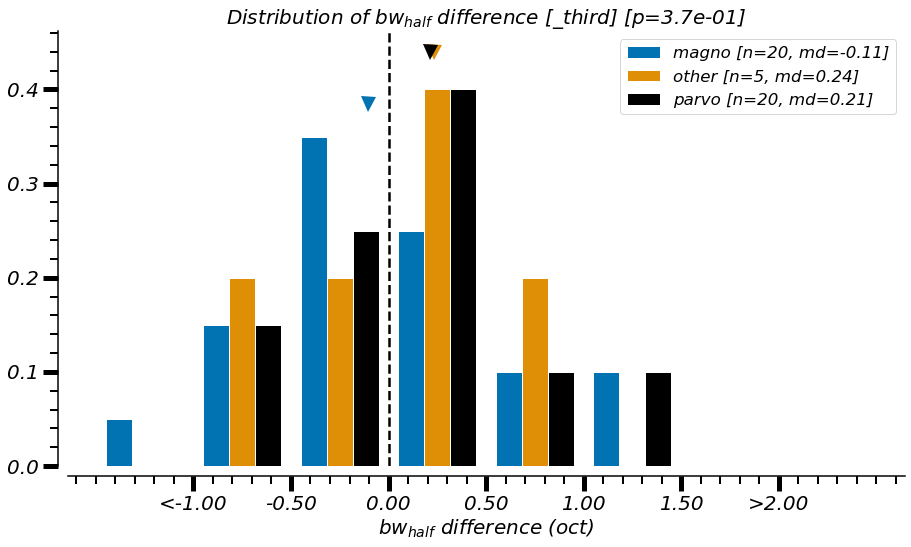

In [1928]:
fixedCon = 1; # if fixed con., then eval. at one third; otherwise, lowest valid con.
norm = 0; # normalize?

lbl = '_third' if fixedCon else '_lowest'
lbl = '%s_norm' % lbl if norm else '%s' % lbl

saveName = '01_02_bwHalf_diff%s%s.pdf' % (lbl, dog_suffix_sv)

if norm:
    bwHalfbins_ratio = np.linspace(-0.5, 0.7, 13);
else:
    bwHalfbins_ratio = np.linspace(-1.5, 2.5, 9);

plt.figure(figsize=(15, 8));

bins = bwHalfbins_ratio
stepSize = (bins[-1] - bins[0])/(len(bins)-1);
binPlotLocs = bins[1:] - 0.5*stepSize;
tickVals = np.linspace(bins[1], bins[-2], len(bins)-2);
clipLow, clipHigh = bins[1]-0.5*stepSize, bins[-2]+0.5*stepSize;

to_comp = [];

width = 0.8*stepSize/cnt;
offsets = bin_offsets(cnt, width);

for (name, group), clr, widOffset in zip(grouped, colors, offsets):
    clipped = [np.clip(x, clipLow, clipHigh) for x in hf.nan_rm(group['boot_bwHalf_diffs%s' % lbl])];
    vals, _ = np.histogram(clipped, bins=bins)
    vals_norm = vals/np.sum(vals)

    # calculate
    # nSF = [len(x) for x in psfs_clipped]
    mdn = np.nanmedian(group['boot_bwHalf_diffs%s' % lbl]);
    # mnSF = [np.nanmean(x) for x in psfs];
    # gmnSF = [gmean(hf.nan_rm(x)) for x in psfs];

    plt.plot(mdn, 1.1*np.max(vals_norm), 'v', color=clr, markersize=15)
    
    plt.bar(binPlotLocs+widOffset, vals_norm, width=width, align='center', color=clr,
            label='%s [n=%d, md=%.2f]' % (name, np.sum(vals), mdn), alpha=alphHist);
    tickStrs = ['%.2f' % x for x in tickVals];
    tickStrs[0] = '<%s' % tickStrs[0];
    tickStrs[-1] = '>%s' % tickStrs[-1];
    plt.xticks(tickVals, tickStrs);
    
    if len(grouped) > 2: # i.e. it's LGN...
        if name == 'other':
            continue;
        to_comp.append(hf.nan_rm(group['boot_bwHalf_diffs%s' % lbl]))
    else:
        to_comp.append(hf.nan_rm(group['boot_bwHalf_diffs%s' % lbl]))
    
plt.xlabel(r'$bw_{half}$ difference (oct)');
ttest = ss.ttest_ind(*to_comp);
plt.title(r'Distribution of $bw_{half}$ difference [%s] [p=%.01e]' % (lbl, ttest.pvalue))
#' [%s] (%s, n=%d, median=%.2f, mn=%.2f, gmn=%.2f)' % (fitStr[i], whichArea, nSF[i], medianSF[i], mnSF[i], gmnSF[i]));
plt.legend(fontsize='small')
plt.axvline(0, color='k', linestyle='--')

sns.despine(offset=10);

# now save
if not os.path.exists(save_loc):
    os.makedirs(save_loc)
pdfSv = pltSave.PdfPages(save_loc + saveName);
f = plt.gcf()
pdfSv.savefig(f) # only one figure here...
pdfSv.close()


#### 1.03 sf70 against sf70 across contrast

/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/users/plevy/miniconda

Beta: [0.09985652 0.09323863]
Beta Std Error: [0.0264199  0.01245874]
Beta Covariance: [[ 0.00046896 -0.00011436]
 [-0.00011436  0.00010429]]
Residual Variance: 1.488408806667216
Inverse Condition #: 0.38883973569353625
Reason(s) for Halting:
  Sum of squares convergence
Beta: [-0.05745389  0.08482676]
Beta Std Error: [0.02843057 0.02222102]
Beta Covariance: [[0.00065165 0.00050587]
 [0.00050587 0.00039808]]
Residual Variance: 1.2403773856861982
Inverse Condition #: 0.05361288760473133
Reason(s) for Halting:
  Sum of squares convergence
Beta: [0.1764816  0.03330969]
Beta Std Error: [0.0760403 0.0323079]
Beta Covariance: [[ 0.00455374 -0.00158751]
 [-0.00158751  0.00082205]]
Residual Variance: 1.2697539400769429
Inverse Condition #: 0.01659591086378271
Reason(s) for Halting:
  Sum of squares convergence


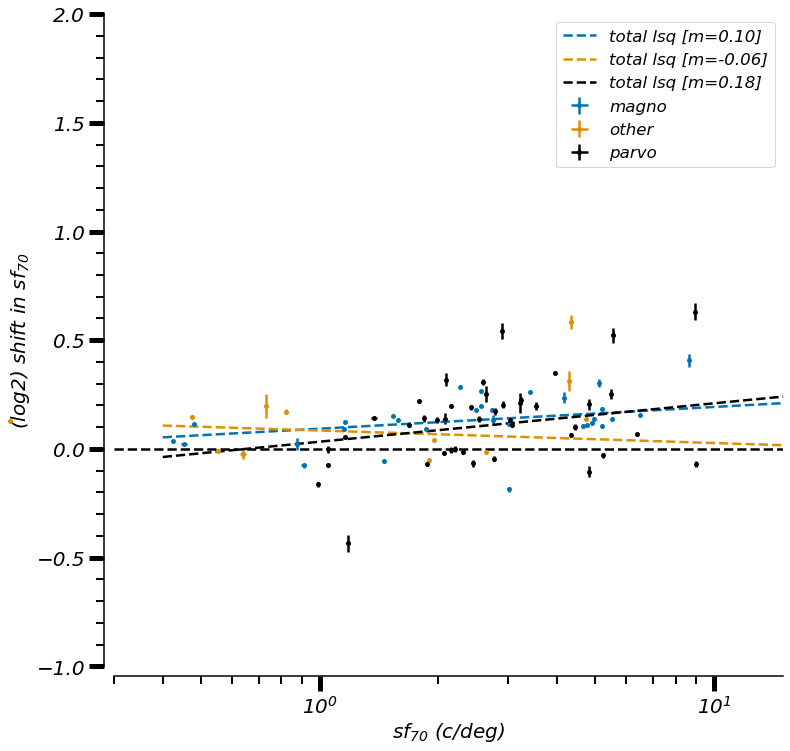

In [1929]:
fixedCon = 0; # if fixed con., then eval. at one third; otherwise, lowest valid con.
norm = 1; # normalize?

lbl = '_third' if fixedCon else '_lowest'
lbl = '%s_norm' % lbl if norm else '%s' % lbl

saveName = '01_03_sf70_v_sf70_rats%s%s.pdf' % (lbl, dog_suffix_sv)

plt.figure(figsize=(12,12))

grouped = mega.groupby(toGroup)

for (name, group), clr in zip(grouped, colors):

    plt.errorbar(group['sf70_mn'], group['boot_sf70_rats%s' % lbl],
            xerr=0.1*group['sf70_stdLog'], yerr=0.1*group['boot_sf70_rats_std%s' % lbl], fmt='o',
                 color=clr, clip_on=False,
                 label=name, alpha=1)
    
    nn = np.logical_and(~np.isnan(group['sf70_mn']), ~np.isnan(group['boot_sf70_rats%s' % lbl]));
    
    ### HACKY!! Manually setting any
    ky = 'sf70_stdLog'
    group[ky][group[ky]==0] = 1e-3;
    ky = 'boot_sf70_rats_std%s' % lbl
    group[ky][group[ky]==0] = 1e-3;
    
    mydata = odrpack.RealData(np.log10(group['sf70_mn'][nn]), group['boot_sf70_rats%s' % lbl][nn], 
                              sy=group['boot_sf70_rats_std%s' % lbl][nn], sx=group['sf70_stdLog'][nn])

    # initial guess via simple correlation (ignoring errors)
    init_guess = np.polyfit(np.log10(group['sf70_mn'][nn]), group['boot_sf70_rats%s' % lbl][nn], deg=1)

    myodr = odrpack.ODR(mydata, linear, beta0=np.flip(init_guess), iprint=2)
    myodr.set_iprint(init=2, iter=2, final=2)
    myoutput = myodr.run()
    myoutput.pprint()

    xvals = np.geomspace(4e-1, 1.5e1, 100)
    plt.plot(xvals, fn(myoutput.beta, np.log10(xvals)),
             '--', color=clr, clip_on=False, label=r'total lsq [m=%.2f]' % (myoutput.beta[0]), alpha=1);
    
    
plt.xlabel(r'$sf_{70}$ (c/deg)')
plt.ylabel(r'(log2) shift in $sf_{70}$')
    
plt.xscale('log')
plt.axhline(0, color='k', linestyle='--');
plt.xlim([3e-1, 1.5e1]);
plt.ylim([-1, 2]);
plt.legend(fontsize='small');

sns.despine(offset=10)

# now save
if not os.path.exists(save_loc):
    os.makedirs(save_loc)
pdfSv = pltSave.PdfPages(save_loc + saveName);
f = plt.gcf()
pdfSv.savefig(f) # only one figure here...
pdfSv.close()

## 2. Shifts with contrast, refined view
Per discussion in VNL, we should try (or rather, revive) to consider the whole trajectory of sf70 (or bandwidth, or else) with contrast

### 01. Plot metric (e.g. sf70) against contrast - for all cells separately and then together

In [1935]:
import scipy.optimize as opt

In [1936]:
def fn(x, a, b):
    return b + a*x;
#     return b + np.log10(a)*np.log10(x);


In [1937]:
# For below plots...

incl_slopeMod_slope = True;
slp_date = '220531';
isHPC = 1;
phAdv = 1; # phAdv or no?
loss_type = 2; # sqrt
DoGmodel = 1; # sach DoG
slps = [];
# first, LGN
data_dir = 'LGN/structures/'
descrBase = 'descrFits%s_%s' % ('HPC' if isHPC else '', slp_date)
slp_mod = hf.np_smart_load('%s%s' % (data_dir, hf.descrFit_name(loss_type, descrBase=descrBase, 
                                          modelName=hf.descrMod_name(DoGmodel), joint=7, phAdj=phAdv)))
slps_lgn = [-slp_mod[x]['paramList'][0][1] for x in range(len(slp_mod.keys()))];
intrs_lgn = [slp_mod[x]['paramList'][0][0] for x in range(len(slp_mod.keys()))];
slps.extend(slps_lgn)

# then, Sach
data_dir = 'LGN/sach/structures/'
descrBase = 'descrFits%s_s%s' % ('HPC' if isHPC else '', slp_date)
slp_mod = hf.np_smart_load('%s%s' % (data_dir, hf.descrFit_name(loss_type, descrBase=descrBase, 
                                          modelName=hf.descrMod_name(DoGmodel), joint=7, phAdj=phAdv)))
slps_sach = [-slp_mod[x]['paramList'][1] for x in range(len(slp_mod.keys()))];
intrs_sach = [-slp_mod[x]['paramList'][0] for x in range(len(slp_mod.keys()))];
slps.extend(slps_sach)


/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1390: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1390: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1390: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1390: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1390: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1390: RuntimeWarning

/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1390: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1390: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1390: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1390: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1390: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1390: RuntimeWarning

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

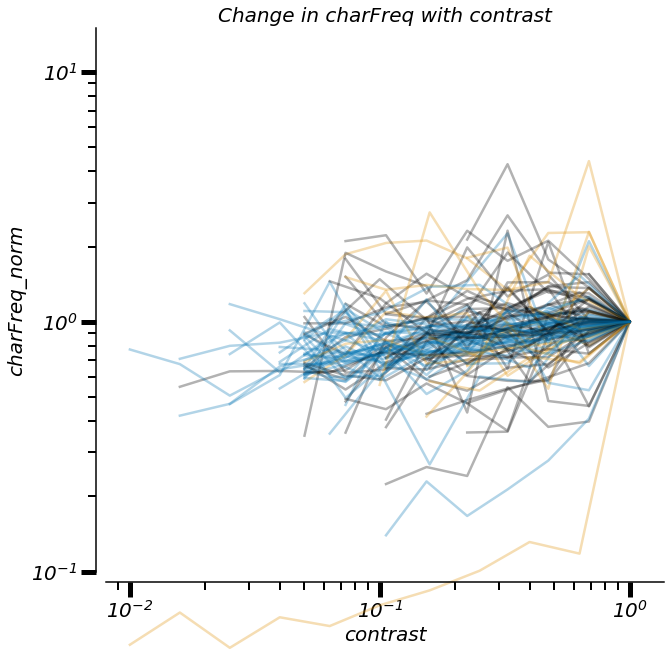

In [1933]:
# metr = 'sf70'
metr = 'charFreq'
metrIsLog = 1; # is this metric log?
var_suffix = 'stdLog' if metrIsLog else 'std';

norm = 1; # normalized?
norm_suffix = '_norm' if norm else '';

ylim = [1e-1, 1.5e1];

isDog = 1;
dog_suffix = 'dog_' if isDog else ''

# Mostly unchanged
disp = 0; # unchanged!
xlim = [1e-2, 1.1]; # contrast
low, ctr, high = 50-34.1, 50, 50+34.1; # get median, and bounds for 68% C.I.
# low, ctr, high = 2.5, 50, 97.5; # get median, and bounds for 95% C.I.

mega_figure = plt.figure(figsize=(10,10));

# names for savig
save_loc_indiv = save_loc + '02_01_trajIndiv_%s%s/' % (dog_suffix, metr)
# -- individual name will be made within the loop
saveName = '02_01_traj_%s%s%s.pdf' % (dog_suffix, metr, norm_suffix)

reg_slopes = np.nan * np.zeros((len(mega['cellType']), 2)); # we'll store the param. and it's std.
reg_slopes_odr = np.copy(reg_slopes);

reg_slopes_boot = np.nan * np.zeros((len(mega['cellType']), 3)); # median slope with 95% C.I.
reg_slopes_boot_summary = np.nan * np.zeros((len(mega['cellType']), 3)); # median, mean slopes, std. of slopes
reg_slopes_boot_all = [];

# --- for each fit, let's also keep a list of the errors per data point and their associated contrasts
reg_slopes_errs = np.nan * np.zeros((len(mega['cellType']), ), dtype='O'); # we'll store the param. and it's std.
reg_slopes_cons = np.nan * np.zeros((len(mega['cellType']), ), dtype='O'); # we'll store the param. and it's std.

for ky in range(len(mega['cellType'])):
    
    plt.figure(figsize=(12, 12));
    
    curr_dir = mega['fullPath'][ky].split('/')[-3]
    curr_num = mega['cellNum'][ky];
    curr_isSach = True if 'sach' in curr_dir else False;
    curr_name = '' if curr_isSach else mega['expName'][ky];
    curr_type = mega['triType'][ky] if whichArea=='LGN' else mega['simple'][ky];
    title = '%s #%02d:%s [%s]' % (curr_dir, curr_num, curr_name, curr_type)
    
    # get which contrasts will be plotting, corresponding indices
    curr_cons = mega['stimVals'][ky][1]; # 1 is for contrast values
    val_inds = mega['val_con_by_disp'][ky][disp]; # should always be zero disp
    
    mtr = 'boot_%s%s_values' % (dog_suffix, metr)
           
    # then get the metric of interest
    curr_ref = mega['%s%s' % (dog_suffix,metr)][ky][disp, val_inds] # i.e. values not from bootstrapping
    curr_vals = mega[mtr][ky][disp, val_inds]
    curr_low, curr_med, curr_high = np.nanpercentile(curr_vals, [low, ctr, high], axis=1)
    curr_errs = np.abs([curr_low, curr_high] - curr_med); # -/+ is inferred in plt.errorbar call

    # -- get the right color
    clr = colors[grp_names.index(curr_type)];
    
    # and plot!
    plt.scatter(curr_cons[val_inds], curr_med, color=clr,clip_on=False);
#     sns.violinplot(np.repeat(curr_cons[val_inds], curr_vals.shape[1],axis=0), curr_vals.flatten(), color=clr, clip_on=False);
    plt.errorbar(curr_cons[val_inds], curr_med, yerr=curr_errs, color=clr, clip_on=False);
    # -- with linear regression (on log-log, assuming both dims are log)
    ok_for_reg = np.where(~np.isnan(curr_med))[0];
    if len(ok_for_reg) >= need_for_slope:
        mtr_var = 'boot_%s%s_%s' % (dog_suffix, metr, var_suffix)
        curr_var = mega[mtr_var][ky][disp, val_inds]
        if np.any(np.isnan(curr_var[ok_for_reg])): # then just set curr_var equal to ones...
            curr_var = np.ones_like(curr_var); # i.e. equal variability...

        fine = opt.curve_fit(fn, np.log10(curr_cons[val_inds][ok_for_reg]), np.log10(curr_med[ok_for_reg]), 
                             sigma=(curr_var[ok_for_reg]))
        pmz = fine[0];
        perr = np.sqrt(np.diag(fine[1])); # per https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html
        conz = np.geomspace(curr_cons[val_inds][ok_for_reg][0], curr_cons[val_inds][ok_for_reg][-1], 50);
        reg_slopes[ky] = [pmz[0], perr[0]];
        plt.plot(conz, np.power(10, fn(np.log10(conz), *pmz)), 'k--', label=r'$m=%.2f \pm %.2f$' % (pmz[0], perr[0]))
        if incl_slopeMod_slope:
            curr_slope = slps_sach[curr_num-1] if curr_isSach else slps_lgn[curr_num-1];
            plt.plot(conz, np.power(10, fn(np.log10(conz), curr_slope, pmz[1])), 'r--', alpha=0.5, label=r'$mod_m=%.2f$' % (curr_slope))
        # --- let's also store the associated contrasts, errors
        reg_slopes_errs[ky] = np.log10(curr_med[ok_for_reg]) - fn(np.log10(curr_cons[val_inds][ok_for_reg]), *pmz); # data - model
        reg_slopes_cons[ky] = curr_cons[val_inds][ok_for_reg]
        
        ### Also do slopes per-boot
        curr_slopes = [];
        for bt_i in range(curr_vals.shape[-1]): # that's the boot value
            try:
                curr_slopes.append(opt.curve_fit(fn, np.log10(curr_cons[val_inds][ok_for_reg]), np.log10(curr_vals[ok_for_reg, bt_i]))[0][0]);
            except:
                curr_slopes.append(np.nan);
        reg_slopes_boot[ky] = [np.nanpercentile(curr_slopes, x) for x in [low, ctr, high]];
        reg_slopes_boot_summary[ky] = [reg_slopes_boot[ky,1], np.nanmean(curr_slopes), np.nanstd(curr_slopes)];
        reg_slopes_boot_all.append(curr_slopes);
        
        # and also do ODR?       
#         mydata = odrpack.Data(x=np.log10(curr_cons[val_inds][ok_for_reg]), 
#                                   y=np.log10(curr_med[ok_for_reg]), wd=None, we=curr_var[ok_for_reg])
        mydata = odrpack.RealData(x=np.log10(curr_cons[val_inds][ok_for_reg]), 
                                  y=np.log10(curr_med[ok_for_reg]), sx=None, sy=curr_var[ok_for_reg])
        myodr = odrpack.ODR(mydata, linear, beta0=pmz, iprint=2)
        myoutput = myodr.run()
        pmz_odr = myoutput.beta
        reg_slopes_odr[ky] = [pmz_odr[0], myoutput.sd_beta[0]]
#         plt.plot(conz, np.power(10, fn(np.log10(conz), *pmz_odr)), 'k:', label=r'$m_{odr}=%.2f$' % (pmz_odr[0]))
    else:
        reg_slopes_boot_all.append([]);
    
    # --- and first, plot the reference values (i.e. those from the best fit)
    plt.scatter(1.00*curr_cons[val_inds], curr_ref, facecolors='none', s=50, edgecolors='r', alpha=0.75, clip_on=False, marker='o', label='ref. values');
    # adjust figure
    plt.xscale('log');
    plt.xlabel('contrast');
    if metrIsLog:
        plt.yscale('log');
        plt.axis('equal');
    plt.ylim(ylim);
    plt.xlim(xlim);
    plt.ylabel('%s' % metr);

    plt.legend(fontsize='x-small')
    
    plt.title('%s' % title);
    sns.despine(offset=10);
    
    # Save the current one
    saveName_indiv = '%s_%02d.pdf' % (curr_dir, curr_num)
    
    if not os.path.exists(save_loc_indiv):
        os.makedirs(save_loc_indiv)
    pdfSv = pltSave.PdfPages(save_loc_indiv + saveName_indiv);
    f = plt.gcf();
    pdfSv.savefig(f); # only one figure here...
    pdfSv.close();
    plt.clf(); # close the plot
    
    # replot on the first one, too
    plt.figure(1);
    if norm:
        try:
            # normalize by the metric value at the highest valid contrast
            norm_ind = np.where(~np.isnan(curr_med))[0][-1];
            curr_med_norm = np.divide(curr_med, curr_med[norm_ind])
            plt.plot(curr_cons[val_inds], curr_med_norm, color=clr, clip_on=False, alpha=0.3)
#             plt.errorbar(curr_cons[val_inds], curr_med_norm, curr_errs, color=clr, clip_on=False, alpha=0.3)
        except:
            pass
    else:
        plt.plot(curr_cons[val_inds], curr_med, color=clr, clip_on=False, alpha=0.3)
#         plt.errorbar(curr_cons[val_inds], curr_med, curr_errs, color=clr, clip_on=False, alpha=0.3)

# at the end, fix up the overall figure
plt.figure(1);

plt.xscale('log');
plt.xlabel('contrast')
if metrIsLog:
    plt.yscale('log')
    plt.axis('equal')
plt.ylim(ylim);
plt.xlim(xlim);
plt.ylabel('%s%s' % (metr, norm_suffix))
plt.title('Change in %s with contrast' % metr)

sns.despine(offset=10)

# Save the overall plot
if not os.path.exists(save_loc):
    os.makedirs(save_loc)
pdfSv = pltSave.PdfPages(save_loc + saveName);
f = plt.gcf()
pdfSv.savefig(f) # only one figure here...
pdfSv.close()
# plt.clf() # close the plot


# And save the slopes in the overall structure
mega['conSlope_%s%s' % (dog_suffix, metr)] = reg_slopes[:,0]
mega['conSlope_%s%s_odr' % (dog_suffix, metr)] = reg_slopes_odr[:,0]
mega['conSlope_%s%s_std' % (dog_suffix, metr)] = reg_slopes[:,1]

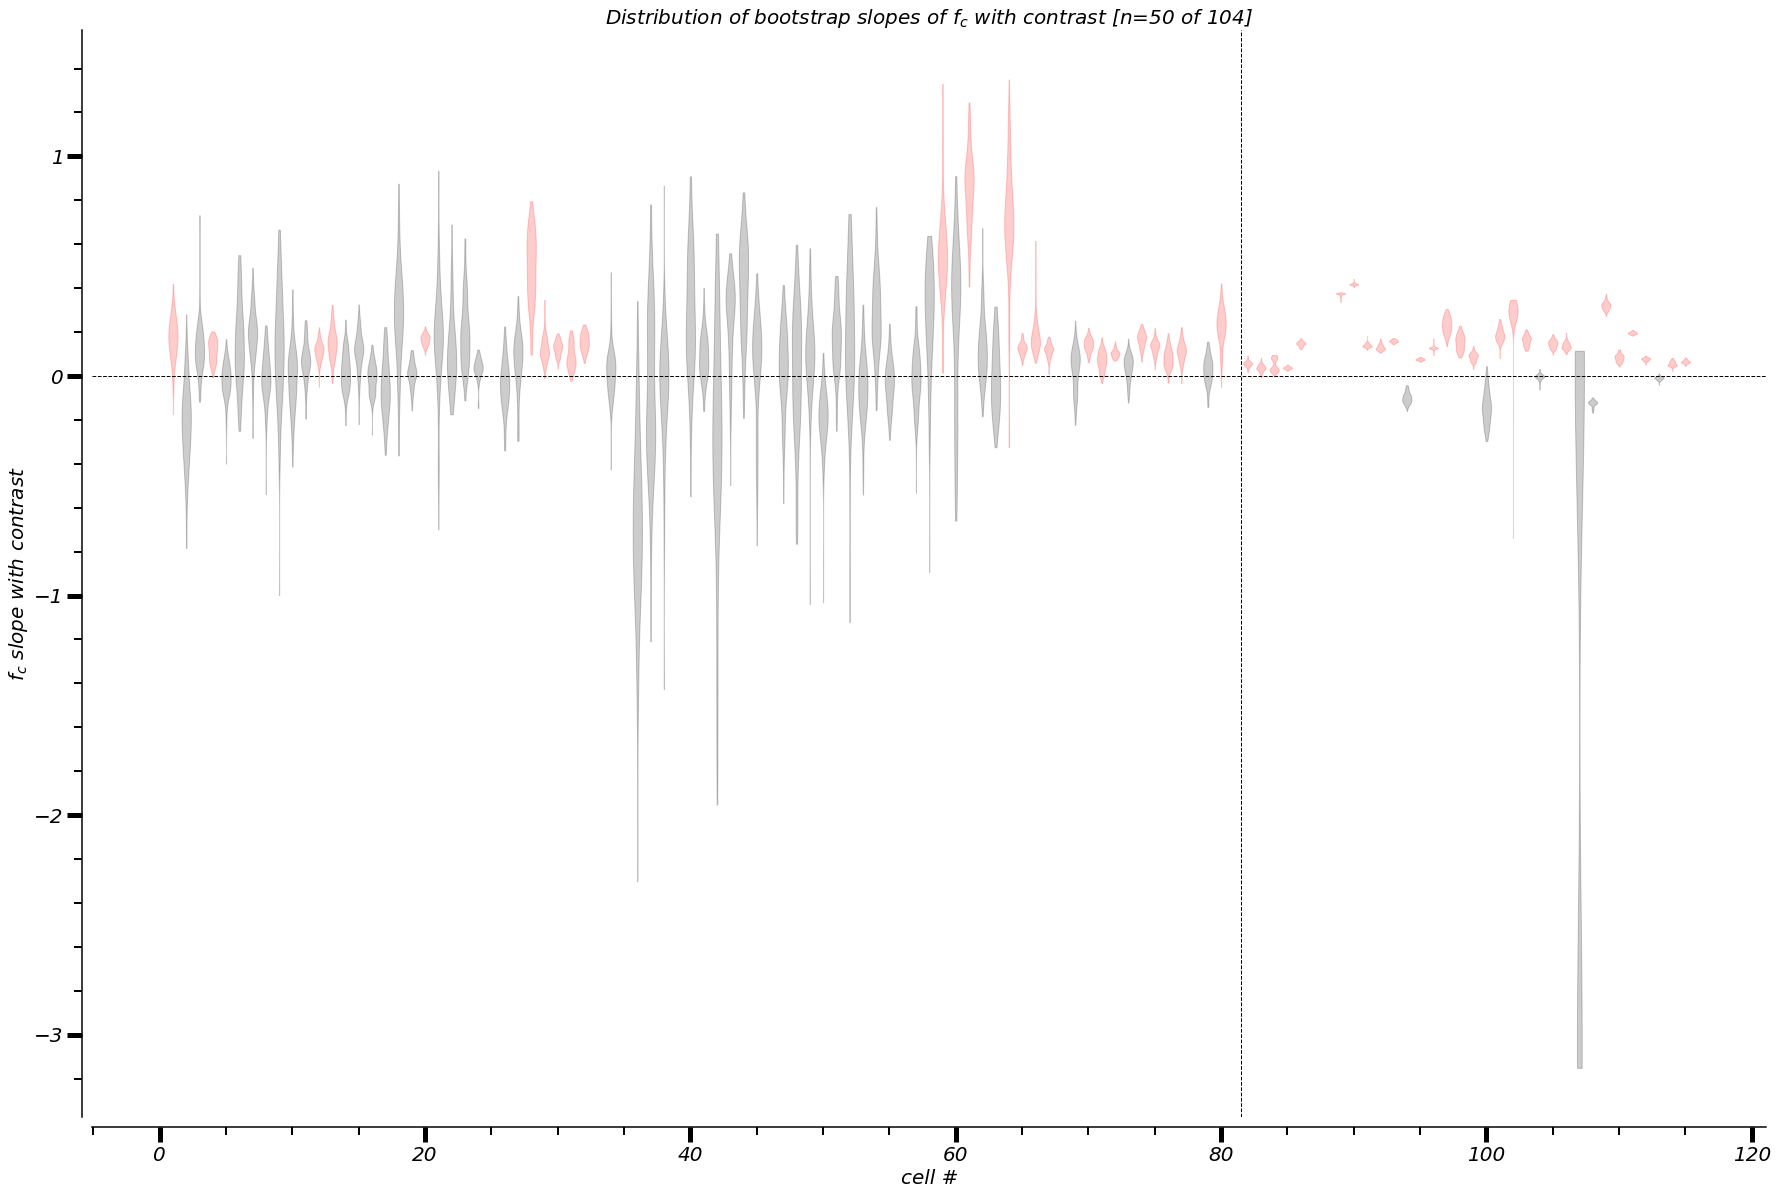

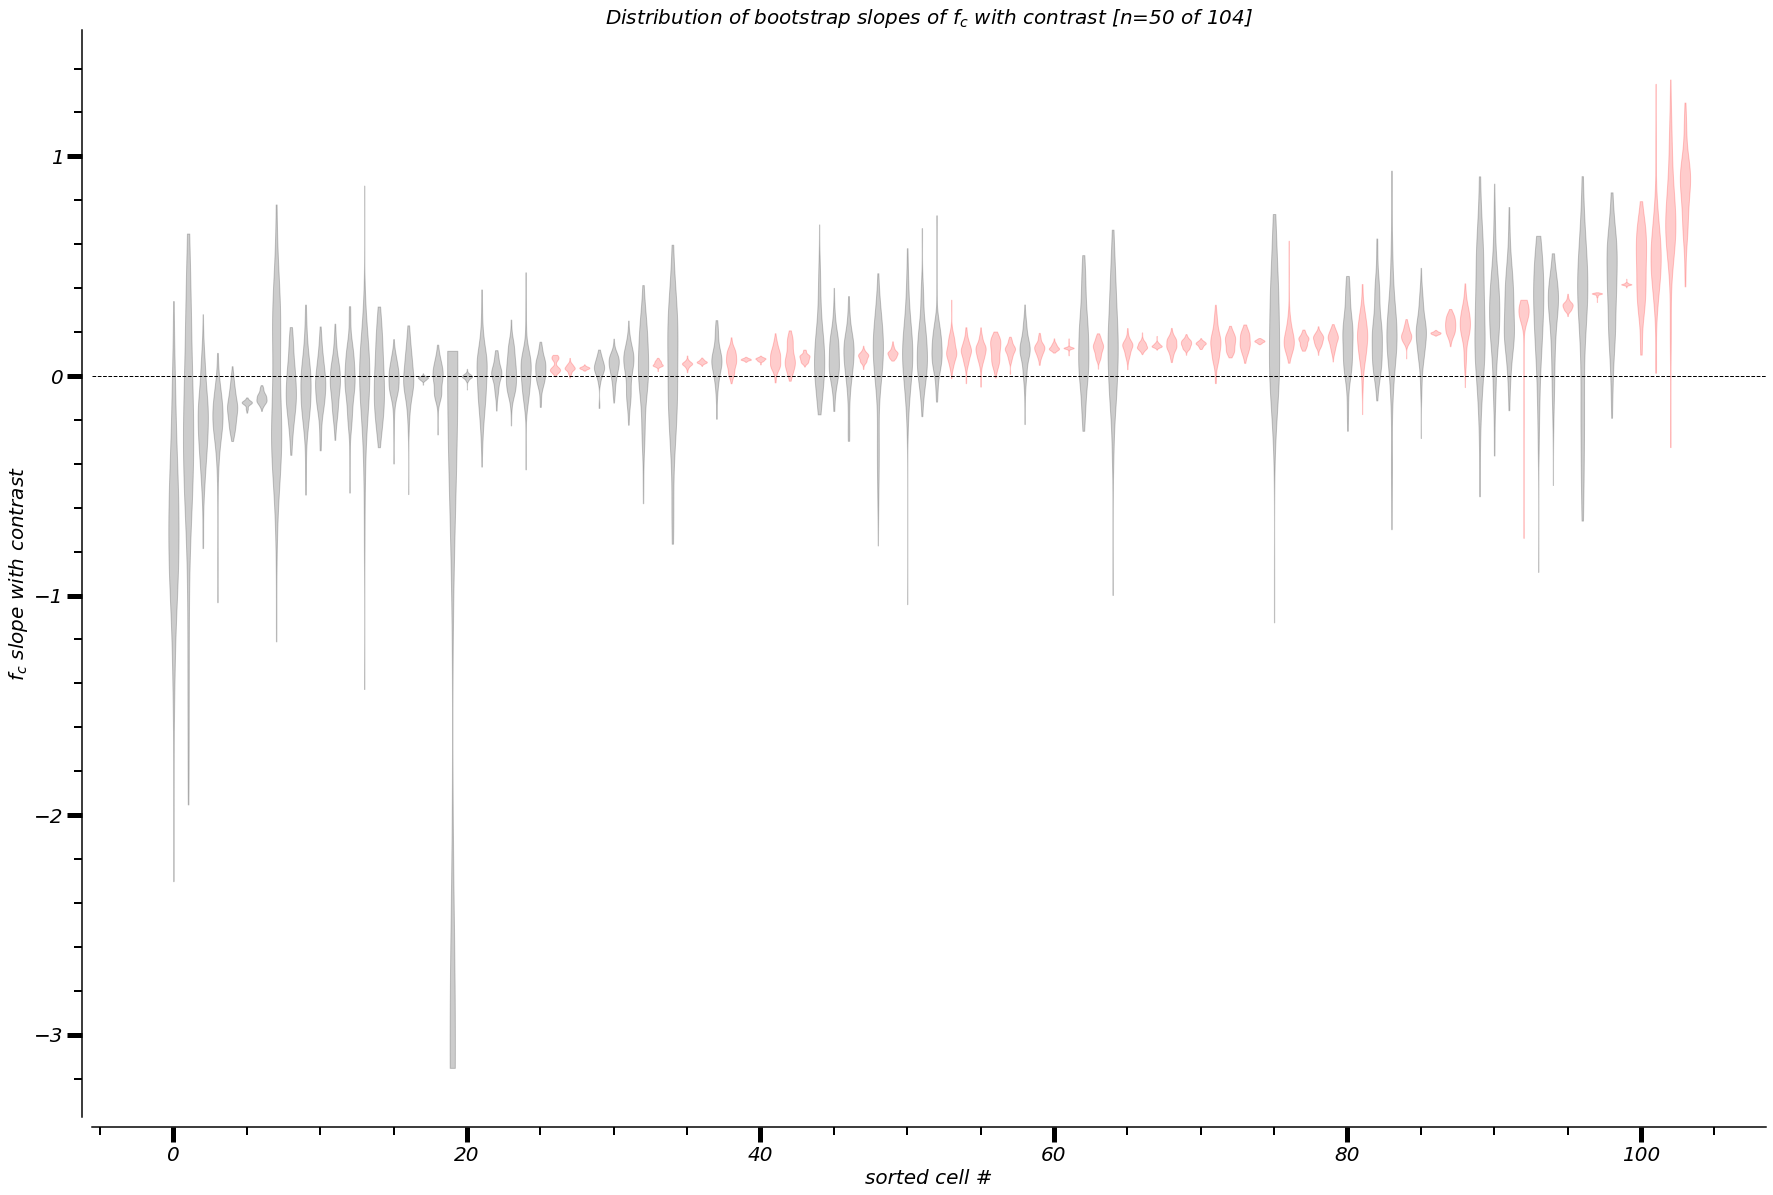

In [1938]:
for to_sort in [0, 1]:

    sort_suffix = '_sorted' if to_sort else ''
    sort_label = 'sorted ' if to_sort else '';

    if not to_sort: # only create/update this if we aren't sorting...
        sig_cells = np.zeros((len(jointList.keys()), ), dtype=np.bool_); 

    non_nan = np.where(~np.isnan(reg_slopes_boot[:,1]))[0]
    sort_by_median = np.argsort(reg_slopes_boot[non_nan,1]);

    if whichArea == 'LGN':
        for ky in jointList.keys():
            # assumes all keys are ordered
            if 'sach' in jointList[ky]['metadata']['fullPath']:
                sach_start = ky; 
                break;
    else: # find the breaks in experiment type
        prevPath = None; newPaths = [];
        for ky in jointList.keys():
            # assumes all keys are ordered
            if prevPath is None:
                prevPath = jointList[ky]['metadata']['fullPath'];
            if prevPath != jointList[ky]['metadata']['fullPath']:
                prevPath = jointList[ky]['metadata']['fullPath'];
                newPaths.append(ky);

    if to_sort:
        rgba_vals = [reg_slopes_boot_all[non_nan[x]] for x in sort_by_median];
        ci_vals = reg_slopes_boot[non_nan[sort_by_median]];
    else:
        rgba_vals = [reg_slopes_boot_all[x] for x in non_nan];
        ci_vals = reg_slopes_boot[non_nan];

    plt.figure(figsize=(30, 20))

    gt0_count = 0;

    if not to_sort and whichArea !='LGN':
        [plt.axvline(j+0.5, color='k', linestyle='--', linewidth=1) for j in newPaths]
    
    for (i, vals), ci in zip(enumerate(rgba_vals), ci_vals):

        pos_curr = i if to_sort else 1+keysAsInts[non_nan[i]];
        viol = plt.violinplot(dataset=vals, positions=[pos_curr], showextrema=False, widths=0.7);

        if not to_sort and i == sach_start and whichArea=='LGN':
            plt.axvline(i+0.5, color='k', linestyle='--', linewidth=1)
#         if not to_sort and whichArea=='V1':
#             if i in newPaths:
#                 plt.axvline(i+0.5, color='k', linestyle='--', linewidth=1)

        # make all the violin stuff black and transparent
        for vp in viol['bodies']:
            is_gt0 = np.sum(np.array(vals)<0)/len(vals) <= .05 # are less than 5% of slopes less than 0?
#             is_gt0 = ci[0] > 0; # is even the 95% lower bound above 0?
            if is_gt0 and not to_sort:
                sig_cells[non_nan[i]] = True;
            clr = 'red' if is_gt0 else 'black';
            gt0_count += is_gt0
    #         plt.text(i, reg_slopes_boot[i,2], s='%02d' )
            vp.set_color(clr)
            vp.set_alpha(0.2);

    plt.axhline(0, color='k', linestyle='--', linewidth=1);
    sns.despine(offset=10)

    plt.xlabel('%scell #' % sort_label);
    plt.ylabel(r'$f_c$ slope with contrast');
    plt.title(r'Distribution of bootstrap slopes of $f_c$ with contrast [n=%d of %d]' % (gt0_count, len(ci_vals)))

    # now save
    saveName = '02_00_%scFreq_bootSlopes%s.pdf' % (dog_suffix, sort_suffix)
    if not os.path.exists(save_loc):
        os.makedirs(save_loc)
    pdfSv = pltSave.PdfPages(save_loc + saveName);
    f = plt.gcf()
    pdfSv.savefig(f) # only one figure here...
    pdfSv.close()

#### Quick look into the significant cells

In [1942]:
verbose = 1; # print cell slopes here?

mega['is_sig'] = sig_cells
mega['boot_slope_median'] = reg_slopes_boot_summary[:,0];
mega['boot_slope_mean'] = reg_slopes_boot_summary[:,1];
mega['boot_slope_std'] = reg_slopes_boot_summary[:,2];
# grouped = mega.groupby('is_sig')

f = open('%s02_00_%scFreq_slope_summary.txt' % (save_loc, dog_suffix), "w")

type_key = 'cellType' if whichArea == 'LGN' else 'simple';

# what percentage of m/p are significant?
grouped = mega.groupby(type_key)
f.write('***Significance by type***\n')
print('***Significance by type***')
for name, group in grouped:
    f.write('%.2f%% of %s have significant shifts/slopes\n' % (100*np.sum(group['is_sig']) / len(group['is_sig']), name))
    print('%.2f%% of %s have significant shifts/slopes' % (100*np.sum(group['is_sig']) / len(group['is_sig']), name))
    
# what percentage of mine/sach are significant?
grouped = mega.groupby('fullPath')
f.write('\n***Significance by era of experiment***\n')
print('\n***Significance by era of experiment***')
for name, group in grouped:
    f.write('%.2f%% of %s have significant shifts/slopes\n' % (100*np.sum(group['is_sig']) / len(group['is_sig']), name.split('/')[-3]))
    print('%.2f%% of %s have significant shifts/slopes' % (100*np.sum(group['is_sig']) / len(group['is_sig']), name.split('/')[-3]))
    
# what percentage of mine/sach are significant?
grouped = mega.groupby('mInd')
f.write('\n***Significance by exp #***\n')
print('\n***Significance by exp #***')
for name, group in grouped:
    f.write('%.2f%% of m%s (%02d of %02d) have significant shifts/slopes\n' % (100*np.sum(group['is_sig']) / len(group['is_sig']), name, np.sum(group['is_sig']), len(group['is_sig'])))
    print('%.2f%% of m%s (%02d of %02d) have significant shifts/slopes' % (100*np.sum(group['is_sig']) / len(group['is_sig']), name, np.sum(group['is_sig']), len(group['is_sig'])))
    
# what percentage by mine/sach AND cell type are significant
f.write('\n***Significance, median slope by exp AND %s #***\n' % type_key)
print('\n***Significance, median slope by exp AND %s #***' % type_key)
for name,group in mega.groupby(['fullPath', type_key]):
    nm = name[0].split('/')[-3];
    n_sig = np.sum(group['is_sig'])
    n_tot = len(group['is_sig']);
    mdn_slope = np.nanmedian(group['conSlope_dog_charFreq'])
    print('%s --> %s: %02d of %02d (%.2f%%) --> mdn slope %.2f' % (nm, name[1], n_sig, n_tot, 100*n_sig/n_tot, mdn_slope))
    f.write('%s --> %s: %02d of %02d (%.2f%%) --> mdn slope %.2f\n' % (nm, name[1], n_sig, n_tot, 100*n_sig/n_tot, mdn_slope))
    
f.close()

### --- also print out every slope value (best for diagnostic purposes)
f = open('%s02_00_%scFreq_slope_values.txt' % (save_loc, dog_suffix), "w")
if verbose:
    print('\n\nAll slope values')
f.write('\n\nAll slope values\n')
if whichArea == 'LGN':
    if verbose:
        [print('%02d [%s]: %.2f%s' % (mega['cellNum'][i], typ, x, '*' if sg else '')) for (i, x), sg, typ in zip(enumerate(mega['conSlope_dog_charFreq']), mega['is_sig'], mega['cellType'])]
    [f.write('%02d [%s]: %.2f%s\n' % (mega['cellNum'][i], typ, x, '*' if sg else '')) for (i, x), sg, typ in zip(enumerate(mega['conSlope_dog_charFreq']), mega['is_sig'], mega['cellType'])]
else:
    expDirs = [x.split('/')[-3] for x in mega['fullPath']]
    if verbose:
        [print('%02d [%s, %s]: %.2f%s' % (mega['cellNum'][i], typ, smp, x, '*' if sg else '')) for (i, x), sg, smp,typ in zip(enumerate(mega['conSlope_dog_charFreq']), mega['is_sig'], mega['simple'], expDirs)]
    [f.write('%02d [%s, %s]: %.2f%s\n' % (mega['cellNum'][i], typ, smp, x, '*' if sg else '')) for (i, x), sg, smp,typ in zip(enumerate(mega['conSlope_dog_charFreq']), mega['is_sig'], mega['simple'], expDirs)]
f.close()

***Significance by type***
72.50% of magno have significant shifts/slopes
35.71% of other have significant shifts/slopes
30.77% of parvo have significant shifts/slopes

***Significance by era of experiment***
78.79% of sach have significant shifts/slopes
32.88% of LGN have significant shifts/slopes

***Significance by exp #***
100.00% of m595 (06 of 06) have significant shifts/slopes
77.78% of m597 (07 of 09) have significant shifts/slopes
72.22% of m599 (13 of 18) have significant shifts/slopes
31.25% of m675 (10 of 32) have significant shifts/slopes
31.58% of m680 (12 of 38) have significant shifts/slopes
66.67% of m682 (02 of 03) have significant shifts/slopes

***Significance, median slope by exp AND cellType #***
sach --> magno: 14 of 15 (93.33%) --> mdn slope 0.08
sach --> other: 03 of 05 (60.00%) --> mdn slope 0.15
sach --> parvo: 09 of 13 (69.23%) --> mdn slope 0.14
LGN --> magno: 15 of 25 (60.00%) --> mdn slope 0.14
LGN --> other: 02 of 09 (22.22%) --> mdn slope 0.08
LGN --> p

/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/ipykernel_launcher.py:9: ResourceWarning: unclosed file <_io.TextIOWrapper name='/arc/2.2/p1/plevy/SF_diversity/sfDiv-OriModel/sfDiv-python/figures/reports/ch1/LGN_220531_vT65_dvT65/02_00_dog_cFreq_slope_summary.txt' mode='w' encoding='UTF-8'>
  if __name__ == '__main__':


In [1843]:
# print('***Proportion of significant cells split by experiment, cell type***\n')
# print(mega.groupby(['fullPath', 'cellType'])['is_sig'].value_counts(normalize=True))
# print('------------\n------------')
# print('***Mean slope, split by experiment, cell type***\n')
# print(mega.groupby(['fullPath', 'cellType'])['conSlope_dog_charFreq'].mean())

##### Let's also validate the model of assuming linear shift on log-log coordinates
i.e. are the errors normally distributed across contrast?

In [1844]:
# plt.figure(figsize=(15, 10))
# [plt.scatter(x,y, color='k', alpha=0.3) for x,y in zip(reg_slopes_cons, reg_slopes_errs)];
# # --- and fit a 1d poly to it?
# all_cons_flat = np.hstack(reg_slopes_cons.flatten())
# all_errs_flat = np.hstack(reg_slopes_errs.flatten())
# no_nan = np.logical_and(~np.isnan(all_errs_flat), ~np.isnan(all_cons_flat))
# all_errs_flat = all_errs_flat[no_nan]
# all_cons_flat = all_cons_flat[no_nan]
# fine = opt.curve_fit(fn, np.log10(all_cons_flat), all_errs_flat)
# pmz = fine[0];
# cons_to_plot = np.geomspace(np.min(all_cons_flat), np.max(all_cons_flat), 100);
# plt.semilogx(cons_to_plot, fn(np.log10(cons_to_plot), *pmz), 'r--', linewidth=1, label='%.2e+x*%.2e' % (*pmz, ))
# plt.xscale('log');
# plt.xlabel('Contrast');
# plt.legend();
# plt.ylabel('Error of fit to slope of f_c');
# plt.title('Distribution of errors by contrast')

# # now save
# saveName = '02_00c_%scFreq_errors.pdf' % (dog_suffix)
# if not os.path.exists(save_loc):
#     os.makedirs(save_loc)
# pdfSv = pltSave.PdfPages(save_loc + saveName);
# f = plt.gcf()
# pdfSv.savefig(f) # only one figure here...
# pdfSv.close()

# # group into bins, see if (a) error is significantly different from 0; (b) distribution is lopsided above/below zero
# nBins = 10;
# _, bin_edges = np.histogram(np.log10(all_cons_flat), bins=nBins)
# indz = np.digitize(np.log10(all_cons_flat), bin_edges[1:-1], right=False);
# for ii, ind in enumerate(np.unique(indz)):
#     distr = all_errs_flat[np.where(indz==ii)];
#     distr_mean, distr_std = np.mean(distr), np.std(distr)
#     distr_rescale = (distr-distr_mean)/distr_std;
#     ks_pval = ss.ks_1samp(distr_rescale, ss.norm.cdf).pvalue;
#     print('[con: %03d-%03d] mean(std) = %.03f(%.02f) --> mean0{tt}||isGauss{ks}: p = %.2f||%.2f [n=%03d]' % (100*np.power(10, bin_edges[ii]), 100*np.power(10, bin_edges[ii+1]), 
#                                                                                                         distr_mean, distr_std, 
#                                                                                                         ss.ttest_1samp(distr, popmean=0).pvalue, 
#                                                                                                         ks_pval, len(distr)))
#     plt.figure(figsize=(12,8));
#     plt.plot(sorted(distr), 'k-', label='orig');
#     plt.plot(sorted(distr_rescale), 'k--', label='z-scored [ks pval=%.2e]' % ks_pval);
#     samps = np.random.randn(len(distr_rescale));
#     plt.plot(sorted(samps), 'r--', label='norm.');
#     plt.legend();
#     plt.xlabel('sorted sample #')
#     plt.ylabel('error');
#     plt.title('Distribution of errors for contrasts between %03d%%-%03d%%' % (100*np.power(10, bin_edges[ii]), 100*np.power(10, bin_edges[ii+1])))
#     saveName = '02_00d_%scFreq_errorsDistr_bin%02d.pdf' % (dog_suffix, ii)
#     pdfSv = pltSave.PdfPages(save_loc + saveName);
#     f = plt.gcf()
#     pdfSv.savefig(f) # only one figure here...
#     pdfSv.close()
#     plt.close(f)

In [1845]:
# ok_comps = np.where([np.all(~np.isnan(x)) for x in reg_slopes_errs])[0];

# pvs = np.array([ss.ks_1samp(ss.zscore(errs), ss.norm.cdf).pvalue for errs in reg_slopes_errs[ok_comps]])
# print('%02d of %02d errors are not normally distributed after z-scoring' % (np.sum(pvs<0.05), len(pvs)))
# pvs = np.array([ss.ttest_1samp(errs, 0).pvalue for errs in reg_slopes_errs[ok_comps]])
# print('%02d of %02d errors have non-zero mean (ttest)' % (np.sum(pvs<0.05), len(pvs)))

##### Alternative version which uses mean + std (as opposed to confidence intervals)

In [1846]:
# metr = 'sf70'
# metrIsLog = 1; # is this metric log?
# var_suffix = 'stdLog' if metrIsLog else 'std';

# norm = 0; # normalized?
# norm_suffix = '_norm' if norm else '';

# ylim = [0.25, 4] if norm else [1e-1, 1.5e1]

# isDog = 1;
# dog_suffix = 'dog_' if isDog else ''

# # Mostly unchanged
# disp = 0; # unchanged!
# xlim = [1e-2, 1.1]; # contrast

# mega_figure = plt.figure(figsize=(10,10));

# errMult = 1.96; # 1.96 _should_ be 95% CI; otherwise, just use 1

# # names for savig
# save_loc_indiv = save_loc + '02_01alt_trajIndiv_%s%s/' % (dog_suffix, metr)
# # -- individual name will be made within the loop
# saveName = '02_01alt_traj_%s%s%s.pdf' % (dog_suffix, metr, norm_suffix)

# for ky in range(len(mega['cellType'])):
    
#     plt.figure(figsize=(10, 10));
    
#     curr_dir = mega['fullPath'][ky].split('/')[-3]
#     curr_num = mega['cellNum'][ky];
#     curr_name = '' if 'sach' in curr_dir else mega['expName'][ky];
#     curr_type = mega['triType'][ky] if whichArea=='LGN' else mega['simple'][ky];
#     title = '%s #%02d:%s [%s]' % (curr_dir, curr_num, curr_name, curr_type)

#     # get which contrasts will be plotting, corresponding indices
#     curr_cons = mega['stimVals'][ky][1]; # 1 is for contrast values
#     val_inds = mega['val_con_by_disp'][ky][disp]; # should always zero disp
    
#     mtr_mn = 'boot_%s%s_mn' % (dog_suffix, metr)
    
#     mtr_var = 'boot_%s%s_%s' % (dog_suffix, metr, var_suffix)
        
#     # then get the metric of interest
#     curr_vals = mega[mtr_mn][ky][disp, val_inds];
#     curr_errs = mega[mtr_var][ky][disp, val_inds];
    
#     clr = colors[grp_names.index(curr_type)];
    
#     plt.scatter(curr_cons[val_inds], curr_vals, color=clr, clip_on=False);
#     plt.errorbar(curr_cons[val_inds], curr_vals, errMult*curr_errs, color=clr, clip_on=False);
        
#     plt.xscale('log');
#     plt.xlabel('contrast');
#     if metrIsLog:
#         plt.yscale('log');
#         plt.axis('equal');
#     plt.ylim(ylim);
#     plt.xlim(xlim);
#     plt.ylabel('%s' % metr);

#     plt.title('%s' % title);
#     sns.despine(offset=5);
    
#     # Save the current one
#     saveName_indiv = '%s_%02d.pdf' % (curr_dir, curr_num)
    
#     if not os.path.exists(save_loc_indiv):
#         os.makedirs(save_loc_indiv);
#     pdfSv = pltSave.PdfPages(save_loc_indiv + saveName_indiv);
#     f = plt.gcf();
#     pdfSv.savefig(f); # only one figure here...
#     pdfSv.close();
#     plt.clf(); # close the plot
    
#     # replot on the first one, too
#     plt.figure(1);
#     if norm:
#         try:
#             # normalize by the metric value at the highest valid contrast
#             norm_ind = np.where(~np.isnan(curr_vals))[0][-1];
#             curr_vals_norm = np.divide(curr_vals, curr_vals[norm_ind])
#             plt.plot(curr_cons[val_inds], curr_vals_norm, color=clr, clip_on=False, alpha=0.3);
#         except:
#             pass
#     else:
#         plt.plot(curr_cons[val_inds], curr_vals, color=clr, clip_on=False, alpha=0.3);

# # at the end, fix up the overall figure
# plt.figure(1);

# plt.xscale('log');
# plt.xlabel('contrast');
# if metrIsLog:
#     plt.yscale('log');
#     plt.axis('equal');
# plt.ylim(ylim);
# plt.xlim(xlim);
# plt.ylabel('%s%s' % (metr, norm_suffix));
# plt.title('Change in %s with contrast' % metr);

# sns.despine(offset=5);

# # Save the overall plot
# if not os.path.exists(save_loc):
#     os.makedirs(save_loc);
# pdfSv = pltSave.PdfPages(save_loc + saveName);
# f = plt.gcf();
# pdfSv.savefig(f); # only one figure here...
# pdfSv.close();
# # plt.clf() # close the plot


##### Plot the regression slopes we fit above

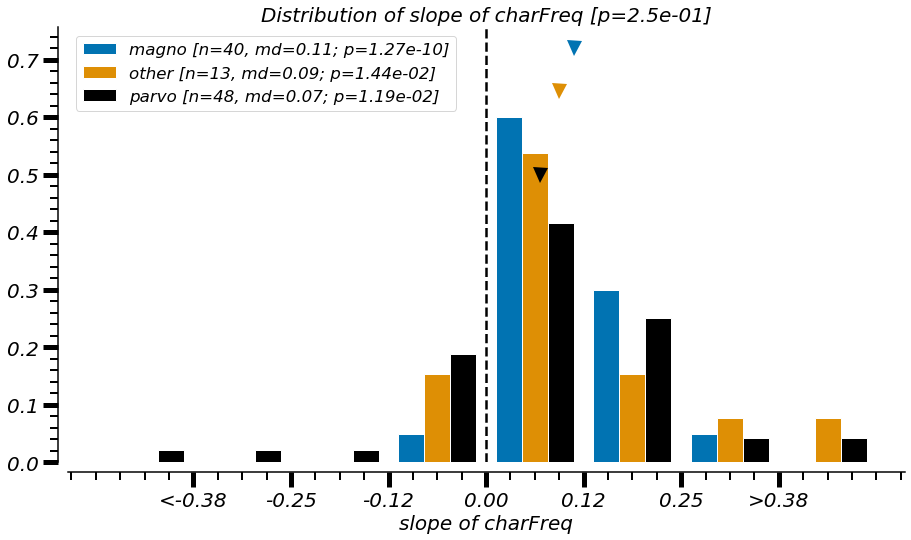

In [1847]:
odrSlopes = 0; # 1 if odr, 0 of least squares
odr_suffix = '_odr' if odrSlopes else ''

saveName = '02_01_%s%s_slopes%s.pdf' % (dog_suffix, metr, odr_suffix)

no_effect = 0; # i.e. if the slope is 0, then there's no effect

plt.figure(figsize=(15, 8));

grouped = mega.groupby(toGroup)

# gather and calculate
bins = np.linspace(-0.5, 0.5, 9);
stepSize = (bins[-1] - bins[0])/(len(bins)-1);
binPlotLocs = bins[1:] - 0.5*stepSize;
clipLow, clipHigh = bins[1]-0.5*stepSize, bins[-2]+0.5*stepSize;

tickVals = np.linspace(bins[1], bins[-2], len(bins)-2)

to_comp = [];

width = 0.8*stepSize/cnt;
offsets = bin_offsets(cnt, width);

for (name, group), clr, widOffset in zip(grouped, colors, offsets):
    
    vals_no_nan = hf.nan_rm(group['conSlope_%s%s%s' % (dog_suffix, metr, odr_suffix)])
    
    clipped = [np.clip(x, clipLow, clipHigh) for x in vals_no_nan];
    vals, _ = np.histogram(clipped, bins=bins)
    vals_norm = vals/np.sum(vals)

    # calculate
    # nSF = [len(x) for x in psfs_clipped]
    mdn = np.nanmedian(vals_no_nan);
    # mnSF = [np.nanmean(x) for x in psfs];
    # gmnSF = [gmean(hf.nan_rm(x)) for x in psfs];

    plt.plot(mdn, 1.2*np.max(vals_norm), 'v', color=clr, markersize=15)
    
    pval_curr = ss.ttest_1samp(vals_no_nan, no_effect) # check if the slopes are diff. from, e.g. 0
    
    plt.bar(binPlotLocs+widOffset, vals_norm, width=width, align='center', color=clr,
            label='%s [n=%d, md=%.2f; p=%.2e]' % (name, np.sum(vals), mdn, pval_curr.pvalue), alpha=alphHist);
    tickStrs = ['%.2f' % x for x in tickVals];
#     tickStrs = ['%.2f' % np.power(2, x) for x in tickVals];
    tickStrs[0] = '<%s' % tickStrs[0];
    tickStrs[-1] = '>%s' % tickStrs[-1];
    plt.xticks(tickVals, tickStrs);
        
    if len(grouped) > 2: # i.e. it's LGN...
        if name == 'other':
            continue;
        to_comp.append(hf.nan_rm(group['conSlope_%s%s%s' % (dog_suffix, metr, odr_suffix)]))
    else:
        to_comp.append(hf.nan_rm(group['conSlope_%s%s%s' % (dog_suffix, metr, odr_suffix)]))
    
# unity/no effect line
plt.axvline(no_effect, color='k', linestyle='--')

plt.xlabel(r'slope of %s' % metr);
ttest = ss.ttest_ind(*to_comp);
plt.title(r'Distribution of slope of %s [p=%.1e]' % (metr, ttest.pvalue))
plt.legend(fontsize='small')

sns.despine(offset=10);

# now save
if not os.path.exists(save_loc):
    os.makedirs(save_loc)
pdfSv = pltSave.PdfPages(save_loc + saveName);
f = plt.gcf()
pdfSv.savefig(f) # only one figure here...
pdfSv.close()


#### Let's also plot the slope size vs. variability --- let's make sure that it's not just high variability conditions with large slopes!

/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


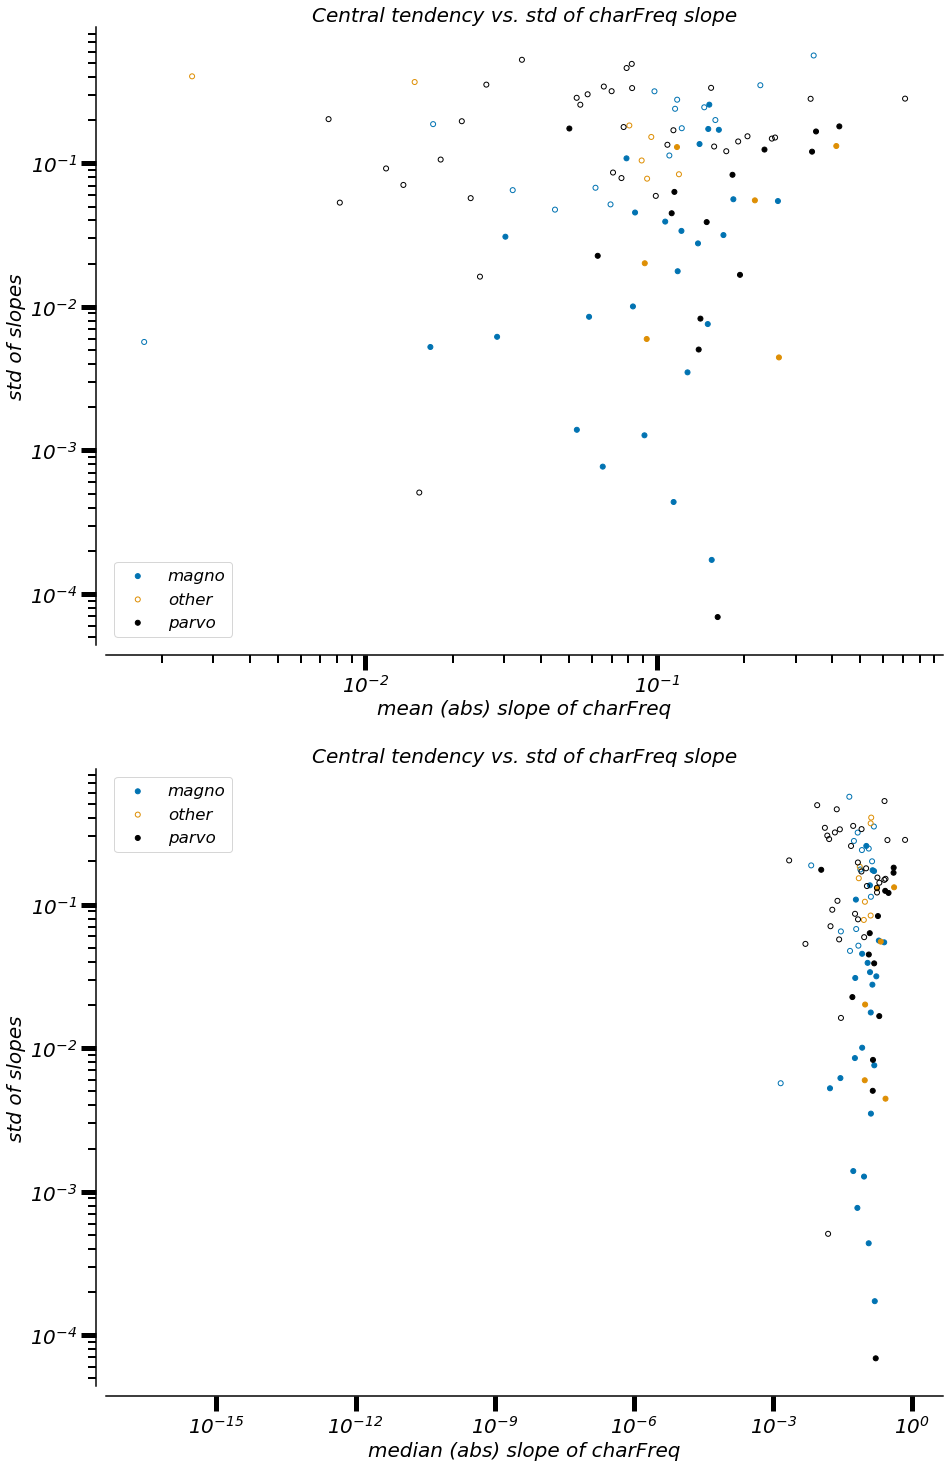

In [1839]:
which_metr = 1; # 0 for median, 1 for mean

fold = 1; # fold negative slopes to positive?
fold_str = '(abs) ' if fold else '';

saveName = '02_01var_%s%s_slopes%s.pdf' % (dog_suffix, metr, odr_suffix)

no_effect = 0; # i.e. if the slope is 0, then there's no effect

f, ax = plt.subplots(2, 1, figsize=(15, 25));

grouped = mega.groupby(toGroup)

for i,summary in enumerate(['mean', 'median']):

    for (name, group), clr, widOffset in zip(grouped, colors, offsets):
        
        sig_clr = [clr if x else 'None' for x in group['is_sig']];
        
        if i==1:
            vals = np.abs(group['boot_slope_mean']) if fold else group['boot_slope_mean']
        elif i==0:
            vals = np.abs(group['boot_slope_median']) if fold else group['boot_slope_median']
            
        ax[i].scatter(vals, group['boot_slope_std'], label='%s' % name, color=sig_clr, edgecolor=clr)
        
    # unity/no effect line
    ax[i].axvline(no_effect, color='k', linestyle='--', alpha=0.3)
    if fold:
        ax[i].set_xscale('log');
        ax[i].set_yscale('log');
    else:
        ax[i].set_xscale('symlog', linthreshx=0.1)
    ax[i].set_xlabel(r'%s %sslope of %s' % (summary,fold_str,metr));
    ax[i].set_ylabel('std of slopes');
    ax[i].set_title(r'Central tendency vs. std of %s slope' % (metr))
    ax[i].legend(fontsize='small')

sns.despine(offset=10);

# now save
if not os.path.exists(save_loc):
    os.makedirs(save_loc)
pdfSv = pltSave.PdfPages(save_loc + saveName);
f = plt.gcf()
pdfSv.savefig(f) # only one figure here...
pdfSv.close()


### 02. Scatter plots!

#### 02.02a sf70 with contrast from data (1:.33 contrast and 1:lowestValid contrast)

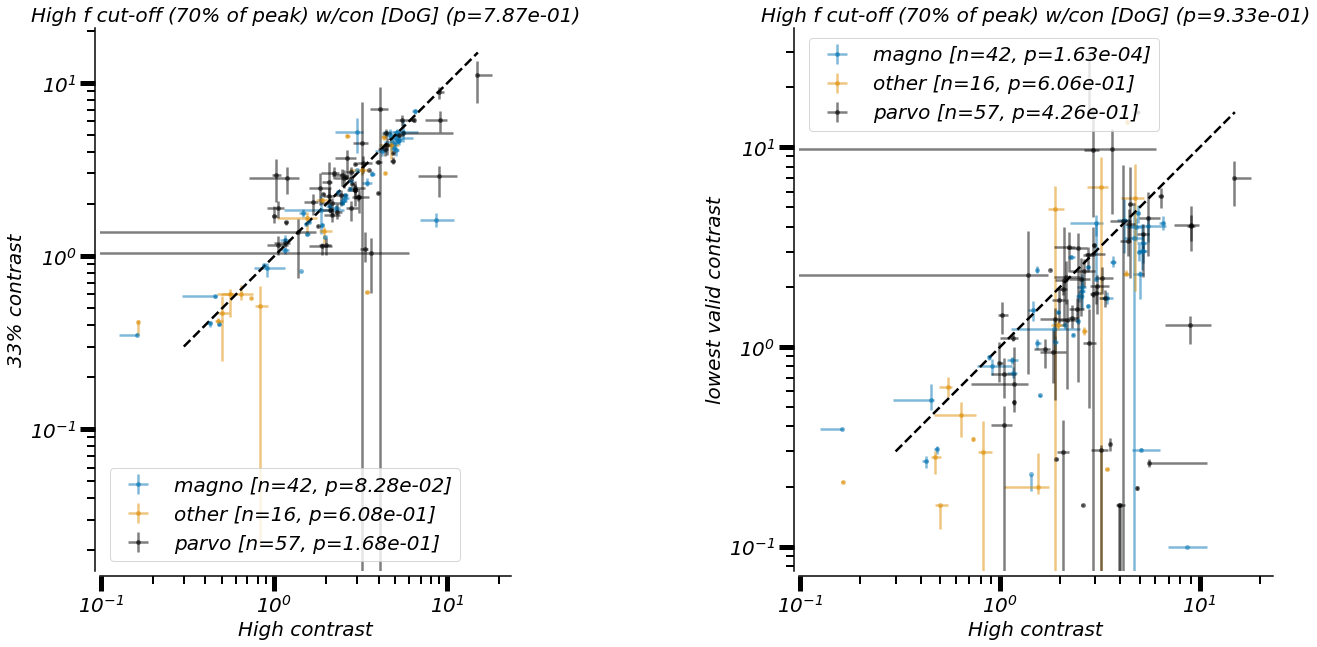

In [1740]:
whichFit = 1; # 0 for non-DoG, 1 for DoG
excludeOneThirds = 0; # if 1, then we don't count include cells which have a lowest valid contrast GTE to 1/3
exclStr = '_excl33' if excludeOneThirds else ''
normCon = 0; # normalize by the contrast ratio ()

# are we getting the values from the bootstrap estimates or no?
bootEst = 1;
bootStr= '_boot' if bootEst else '';

normStr = '_norm' if normCon else ''

prefix = 'dog_' if whichFit==1 else ''
suffix = '[DoG] ' if whichFit==1 else ''

saveName = '02_02a_sf70_%sscatter_%s%s%s.pdf' % (prefix, fitBase, exclStr, bootStr);

nrow, ncol = 1,2
f, ax = plt.subplots(nrow,ncol, figsize=(ncol*12, nrow*10))

# Likely unchanged...
low, ctr, high = 25, 50, 75; # get median, and bounds for X% C.I. (e.g. 95%)
disp=0 
yLabels = ['33% contrast', 'lowest valid contrast']
alphScatter = 0.5

# first one will be 1:.33 (i.e. raw values); second will be 1:lowest
for i,ylbl in enumerate(yLabels):
    
    to_comp = [];
    
    ### Gather the data, put into "mega"
    if bootEst:
        highSf, compSf, compCons = hf.jl_get_metric_highComp(jointList, 'boot_%ssf70_values' % prefix, whichFit, i)
        highSplits = np.array([np.nanpercentile(x, [ctr, low, high]) for x in highSf])
        compSplits = np.array([np.nanpercentile(x, [ctr, low, high]) for x in compSf])

        if i == 0:
            mega['%ssf70_high' % prefix] = highSplits[:,0];
            mega['%ssf70_high_CI_lo' % prefix] = highSplits[:,1];
            mega['%ssf70_high_CI_hi' % prefix] = highSplits[:,2];
            mega['%ssf70_third' % prefix] = compSplits[:,0];
            mega['%ssf70_third_CI_lo' % prefix] = compSplits[:,1];
            mega['%ssf70_third_CI_hi' % prefix] = compSplits[:,2];
            mega['%ssf70_cons_third' % prefix] = compCons;
        elif i == 1:
            mega['%ssf70_low' % prefix] = compSplits[:,0];
            mega['%ssf70_low_CI_lo' % prefix] = compSplits[:,1];
            mega['%ssf70_low_CI_hi' % prefix] = compSplits[:,2];
            mega['%ssf70_cons_low' % prefix] = compCons;
        
    else:
        highSf, compSf, compCons = hf.jl_get_metric_highComp(jointList, '%ssf70' % prefix, whichFit, i)
        if i == 0:
            mega['%ssf70_high' % prefix] = highSf;
            mega['%ssf70_third' % prefix] = compSf;
            mega['%ssf70_cons_third' % prefix] = compCons           
        elif i == 1:
            mega['%ssf70_low' % prefix] = compSf;
            mega['%ssf70_cons_low' % prefix] = compCons

    # and add ratio
    highSfs = mega['%ssf70_high' % prefix]
    divFactor = np.log2(np.divide(1, compCons)) if normCon else 1;
    if i == 0:
        mega['%ssf70_ratio_third%s' % (prefix, bootStr)] = np.log2(np.divide(highSfs, mega['%ssf70_third' % prefix])) / divFactor
    elif i == 1:
        mega['%ssf70_ratio_low%s' % (prefix, bootStr)] = np.log2(np.divide(highSfs, mega['%ssf70_low' % prefix])) / divFactor

            
    ### Go through by group to plot
    grouped = mega.groupby(toGroup)
    
    for (name, group), clr, widOffset in zip(grouped, colors, offsets):
    
        compCons = group['%ssf70_cons_third' % prefix] if i == 0 else group['%ssf70_cons_low' % prefix];
        if excludeOneThirds and i == 1:
            validInds = compCons<0.3 #np.where(compCons<0.3)[0];
        else:
            validInds = compCons<0.4 #np.where(compCons<0.4)[0]; # should be at least <40% contrast!

        highSf = group['%ssf70_high' % (prefix)]
        compSf = group['%ssf70_third' % (prefix)] if i==0 else group['%ssf70_low' % prefix]
            
        if bootEst:
            hi_errLow = group['%ssf70_high_CI_lo' % prefix] if i == 0 else group['%ssf70_high_CI_lo' % prefix]
            hi_errHigh = group['%ssf70_high_CI_hi' % prefix] if i == 0 else group['%ssf70_high_CI_hi' % prefix]
            comp_errLow = group['%ssf70_third_CI_lo' % prefix] if i == 0 else group['%ssf70_low_CI_lo' % prefix]
            comp_errHigh = group['%ssf70_third_CI_hi' % prefix] if i == 0 else group['%ssf70_low_CI_hi' % prefix]
            
        non_nan = np.logical_and(~np.isnan(highSf), ~np.isnan(compSf))
        val_inds = np.logical_and(non_nan, validInds)
        
        rats_curr = np.divide(highSf[val_inds], compSf[val_inds]);
        if normCon:
            conRat_log2 = np.log2(np.divide(1, compCons[val_inds]))
            rats_curr = np.divide(rats_curr, conRat_log2);

        paired_t = ss.ttest_rel(highSf[val_inds], compSf[val_inds])
        pval = paired_t.pvalue;
        
        if bootEst: # then we include C.I.!
            ax[i].errorbar(highSf[val_inds], compSf[val_inds], 
                           xerr=[hi_errLow[val_inds] - highSf[val_inds], highSf[val_inds] - hi_errHigh[val_inds]],
                           yerr=[comp_errLow[val_inds] - compSf[val_inds], compSf[val_inds] - comp_errHigh[val_inds]],
                           label='%s [n=%02d, p=%.2e]' % (name, np.sum(val_inds), pval), 
                           alpha=alphScatter, color=clr, fmt='o')#, s=30)
        else:
            ax[i].scatter(highSf[val_inds], compSf[val_inds], alpha=alphScatter, color=clr, 
                          s=30, label='%s [n=%02d, p=%.2e]' % (name, np.sum(val_inds), pval))
            
        if len(grouped) > 2: # i.e. it's LGN...
            if name == 'other':
                continue;
            to_comp.append(rats_curr)
        else:
            to_comp.append(rats_curr)

    # after plotting each group, set the visuals        
    ax[i].loglog([0.3,15], [0.3, 15], 'k--')
    paired_t = ss.ttest_ind(to_comp[0], to_comp[1])
    pval = paired_t.pvalue;
    ax[i].set_title('High f cut-off (70%% of peak) w/con %s(p=%.2e)' % (suffix, pval))
    ax[i].set_xlabel('High contrast')
    ax[i].set_ylabel(ylbl)
    ax[i].set_aspect('equal')
    ax[i].legend()
    
sns.despine(offset=5)

if not os.path.exists(save_loc):
    os.makedirs(save_loc)
pdfSv = pltSave.PdfPages(save_loc + saveName);
pdfSv.savefig(f) # only one figure here...
pdfSv.close()

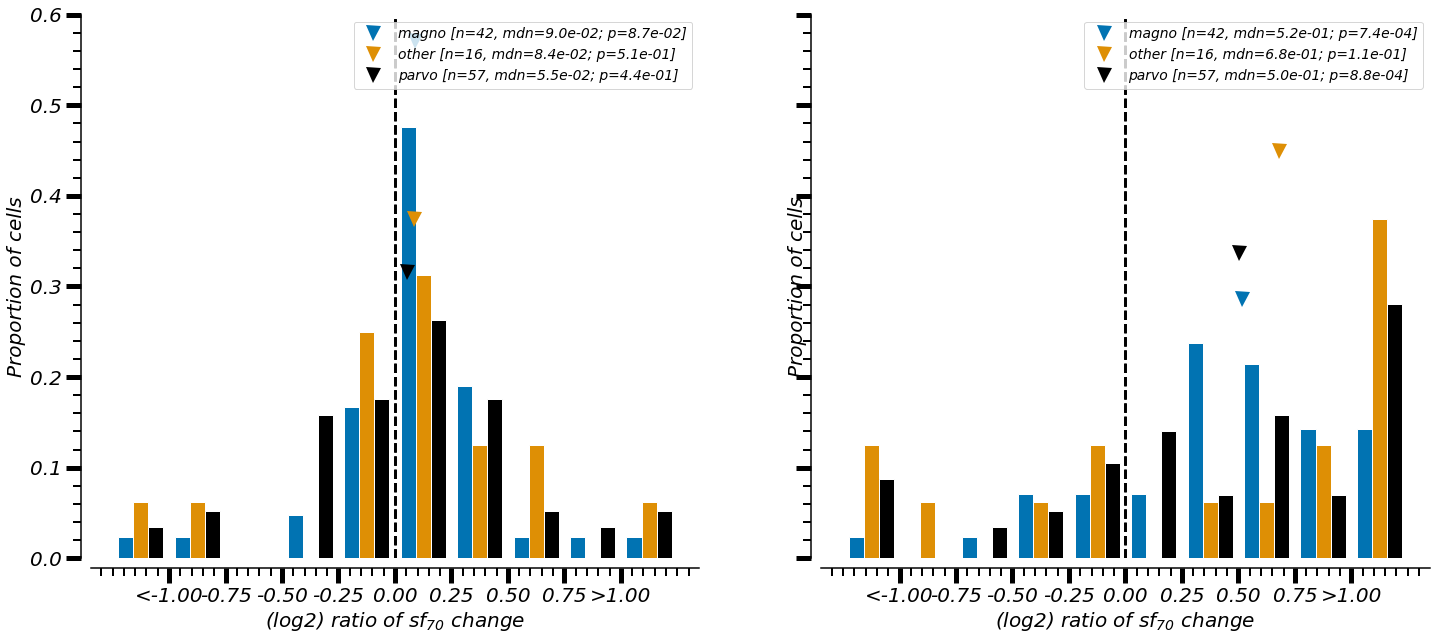

In [1741]:
# Then, the histogram
saveName = saveName.replace('scatter', 'hist%s' % normStr)

f, ax = plt.subplots(nrow,ncol, figsize=(ncol*12, nrow*10), sharey=True)

if normCon:
    bins = np.linspace(-0.5, 0.5, 9);
else:
    bins = np.linspace(-1.25, 1.25, 11);
stepSize = (bins[-1] - bins[0])/(len(bins)-1);
binPlotLocs = bins[1:] - 0.5*stepSize;
tickVals = np.linspace(bins[1], bins[-2], len(bins)-2);

width = 0.8*stepSize/cnt;
offsets = bin_offsets(cnt, width);

normStr = ', con. norm' if normCon==1 else '';

xlabs = ['1:0.33', '1:lowestCon']

grouped = mega.groupby(toGroup)

no_effect = 0;

# first one will be 1:.33 (i.e. raw values); second will be 1:lowest
for (i,ylbl), xlab in zip(enumerate(yLabels), xlabs):

    #########################
    for (name, group), clr, widOffset in zip(grouped, colors, offsets):
    
        key_str = '%ssf70_ratio_third%s' % (prefix, bootStr) if i == 0 else '%ssf70_ratio_low%s' % (prefix, bootStr)
        vals_no_nan = hf.nan_rm(group[key_str]); # log transform the ratios s.t. 0 means no shift

        ratsClipped = np.clip(vals_no_nan, bins[0]+0.5*stepSize, bins[-1]-0.5*stepSize)
        vals, _ = np.histogram(ratsClipped, bins=bins)
        vals_norm = vals/np.sum(vals)

        # compute mean/median, pvalue (i.e. are ratios diff. from 0)
        mn, mdn = np.nanmean(vals_no_nan), np.nanmedian(vals_no_nan);
        pval_curr = ss.ttest_1samp(vals_no_nan, no_effect) # check if the slopes are diff. from, e.g. 0
       
        
        # plot the median, add label
        ax[i].plot(mdn, 1.2*np.max(vals_norm), 'v', color=clr, markersize=15, 
                   label='%s [n=%02d, mdn=%.1e; p=%.1e]' % (name, len(ratsClipped), mdn,  pval_curr.pvalue))

        # plot the histogram
        ax[i].bar(binPlotLocs+widOffset, vals_norm, width=width, align='center', color=clr,
                alpha=alphHist);
        
        # do the ticks
        tickStrs = ['%.2f' % x for x in tickVals];
#         tickStrs = ['%.2f' % np.power(2, x) for x in tickVals];
        tickStrs[0] = '<%s' % tickStrs[0];
        tickStrs[-1] = '>%s' % tickStrs[-1];
        ax[i].set_xticks(tickVals);
        ax[i].set_xticklabels(tickStrs)
        
        # add a no-effect line, legend, axis labels, etc
        ax[i].axvline(0, linestyle='--', color='k')
        ax[i].legend(fontsize='x-small');
        ax[i].set_xlabel(r'(log2%s) ratio of $sf_{70}$ change' % normStr)
        ax[i].set_ylabel('Proportion of cells');
        
        
sns.despine(offset=10)

if not os.path.exists(save_loc):
    os.makedirs(save_loc)
pdfSv = pltSave.PdfPages(save_loc + saveName);
pdfSv.savefig(f) # only one figure here...
pdfSv.close()

## 3. Mechanism (with DoG analysis)

#### Let's get the radius, gain, volume for the center and surround mechanisms

In [1742]:
curr_gc

array([100.        , 114.14700343, 317.80494501, 259.62230786,
       156.92463849, 189.76638794, 210.83514002, 199.58516626,
       147.98220138, 106.65182727,  89.46961975])

In [1743]:
curr_gs

array([116.65388931,  91.79600466, 304.11251503, 118.20698554,
        86.95412571, 124.92422785,  94.59255761,  74.99256545,
        35.07562767,  16.25971694,  11.88837934])

In [1744]:
np.divide(curr_gc,curr_gs)

array([0.85723674, 1.24348553, 1.04502422, 2.19633642, 1.80468307,
       1.51905192, 2.22887662, 2.66139937, 4.21894664, 6.55926716,
       7.52580458])

In [1745]:
curr_gc * np.square(curr_rc)

array([ 6.59352942,  6.64406541, 16.32979821, 11.77642806,  6.28367802,
        6.70800228,  6.57912768,  5.49799522,  3.59862815,  2.28953368,
        1.69553003])

In [1746]:
curr_gs * np.square(curr_rs)

array([143.24208465,  99.5053852 , 291.01001699,  99.85463101,
        64.84349819,  82.23828658,  54.97126339,  38.47226653,
        15.88496981,   6.5004767 ,   4.19571545])

In [1747]:
curr_rc

array([0.25677869, 0.24125965, 0.22667837, 0.21297851, 0.20010659,
       0.1880126 , 0.1766496 , 0.16597323, 0.15594223, 0.14651746,
       0.13766228])

In [1748]:
curr_rs

array([1.10811722, 1.04114544, 0.97822064, 0.91909951, 0.86355126,
       0.81136018, 0.76232362, 0.71625024, 0.67296189, 0.63228971,
       0.59407556])

In [1749]:
curr_vs

array([116.65388931,  91.79600466, 304.11251503, 118.20698554,
        86.95412571, 124.92422785,  94.59255761,  74.99256545,
        35.07562767,  16.25971694,  11.88837934])

In [1750]:
curr_vc

array([ 6.59352913,  6.64406551, 16.32979868, 11.77642796,  6.28367778,
        6.70800261,  6.57912751,  5.49799525,  3.59862819,  2.28953374,
        1.69552999])

/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/ipykernel_launcher.py:157: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/ipykernel_launcher.py:168: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/ipykernel_launcher.py:179: MatplotlibDeprecationWarning: Adding an axes using the s

/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/ipykernel_launcher.py:212: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/ipykernel_launcher.py:223: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/ipykernel_launcher.py:234: MatplotlibDeprecationWarning: Adding an axes using the s

/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/ipykernel_launcher.py:157: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/ipykernel_launcher.py:168: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/ipykernel_launcher.py:179: MatplotlibDeprecationWarning: Adding an axes using the s

/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/ipykernel_launcher.py:157: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/ipykernel_launcher.py:168: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/ipykernel_launcher.py:179: MatplotlibDeprecationWarning: Adding an axes using the s

/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/ipykernel_launcher.py:245: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/ipykernel_launcher.py:157: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/ipykernel_launcher.py:168: MatplotlibDeprecationWarning: Adding an axes using the s

/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/ipykernel_launcher.py:245: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/ipykernel_launcher.py:157: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/ipykernel_launcher.py:168: MatplotlibDeprecationWarning: Adding an axes using the s

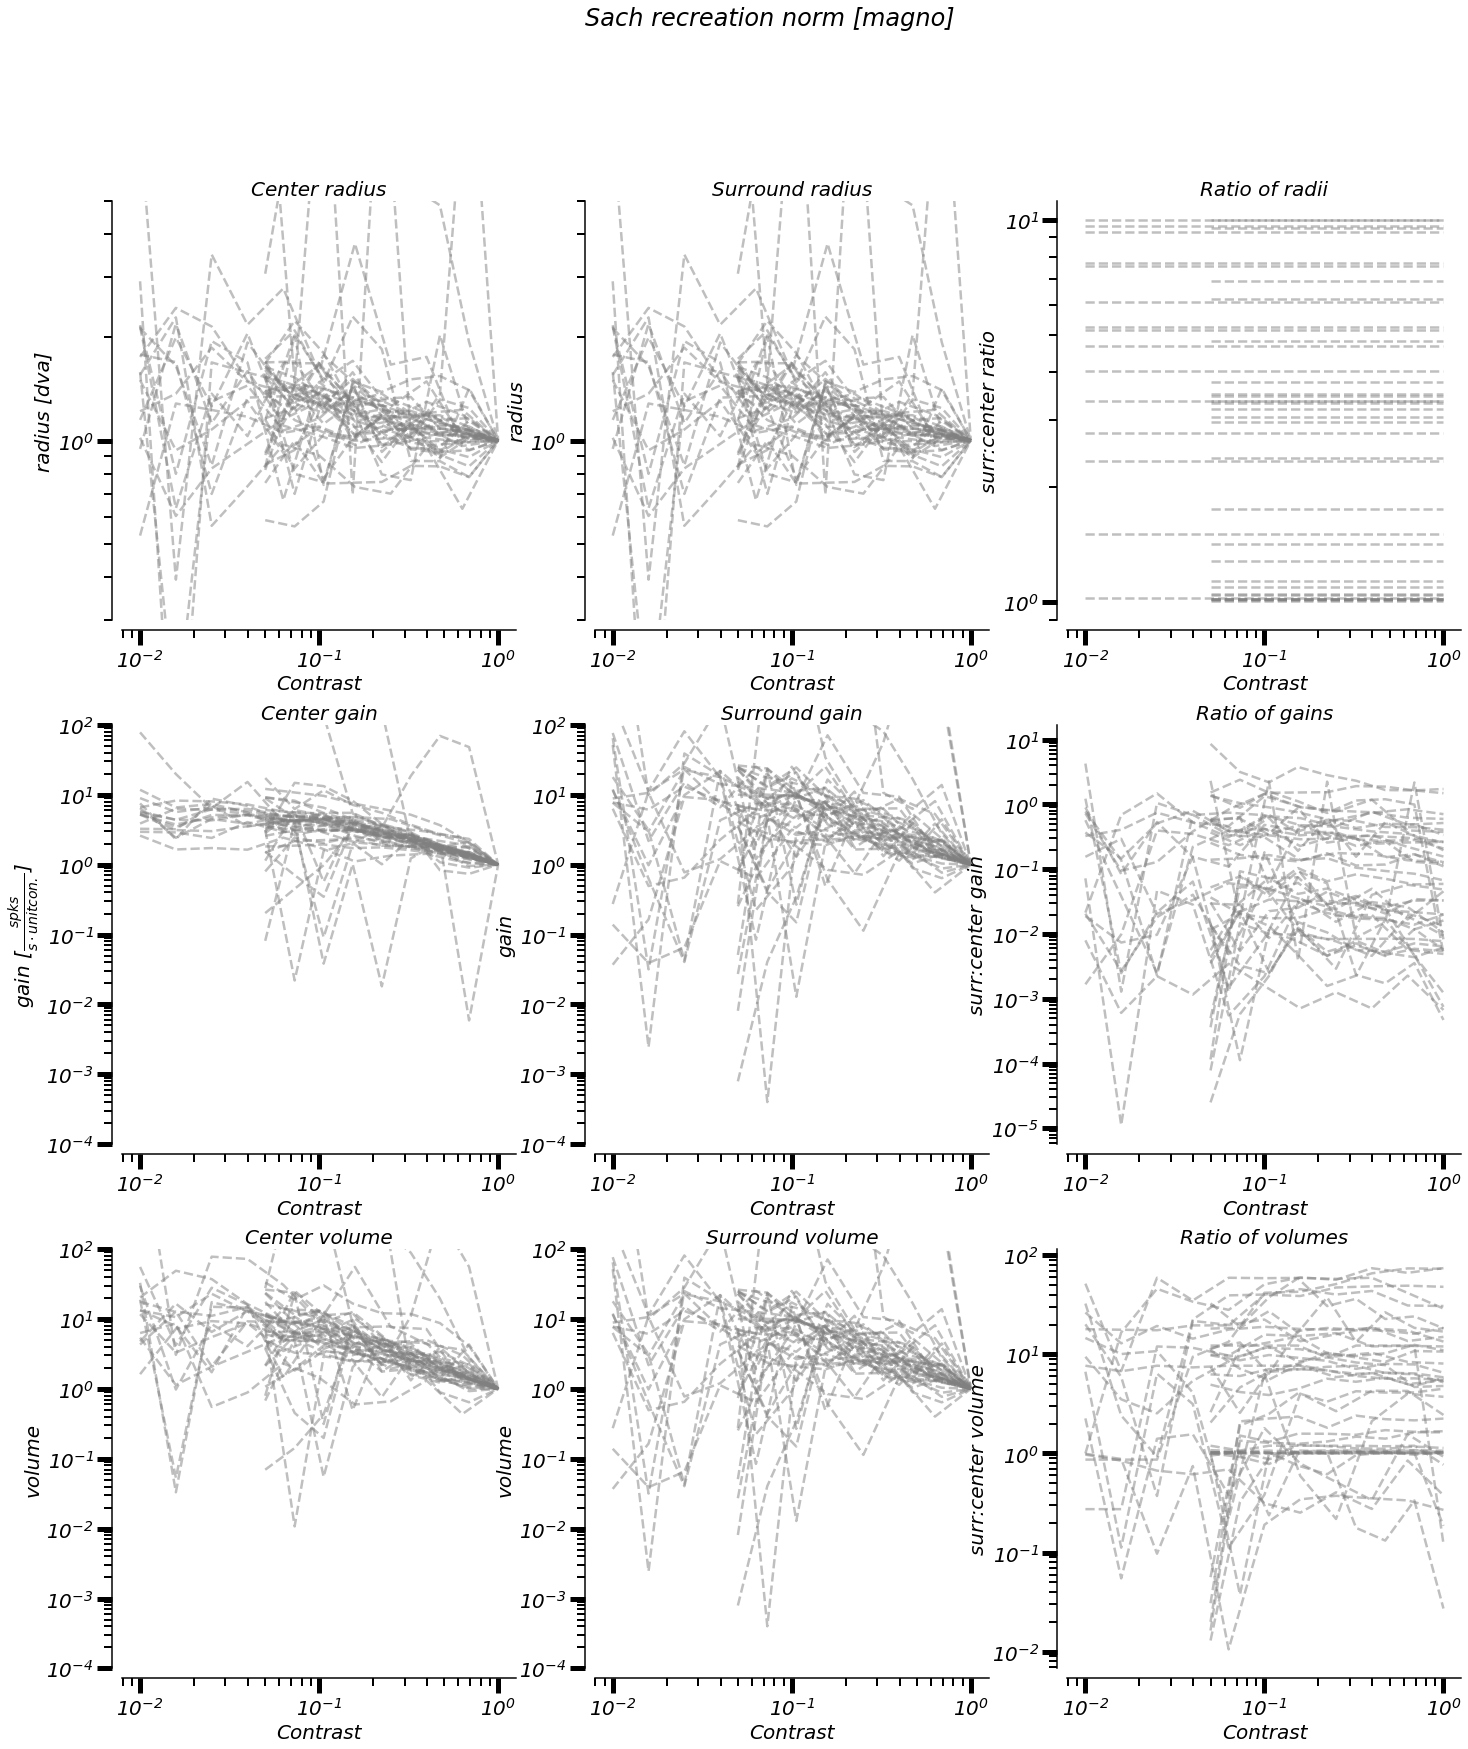

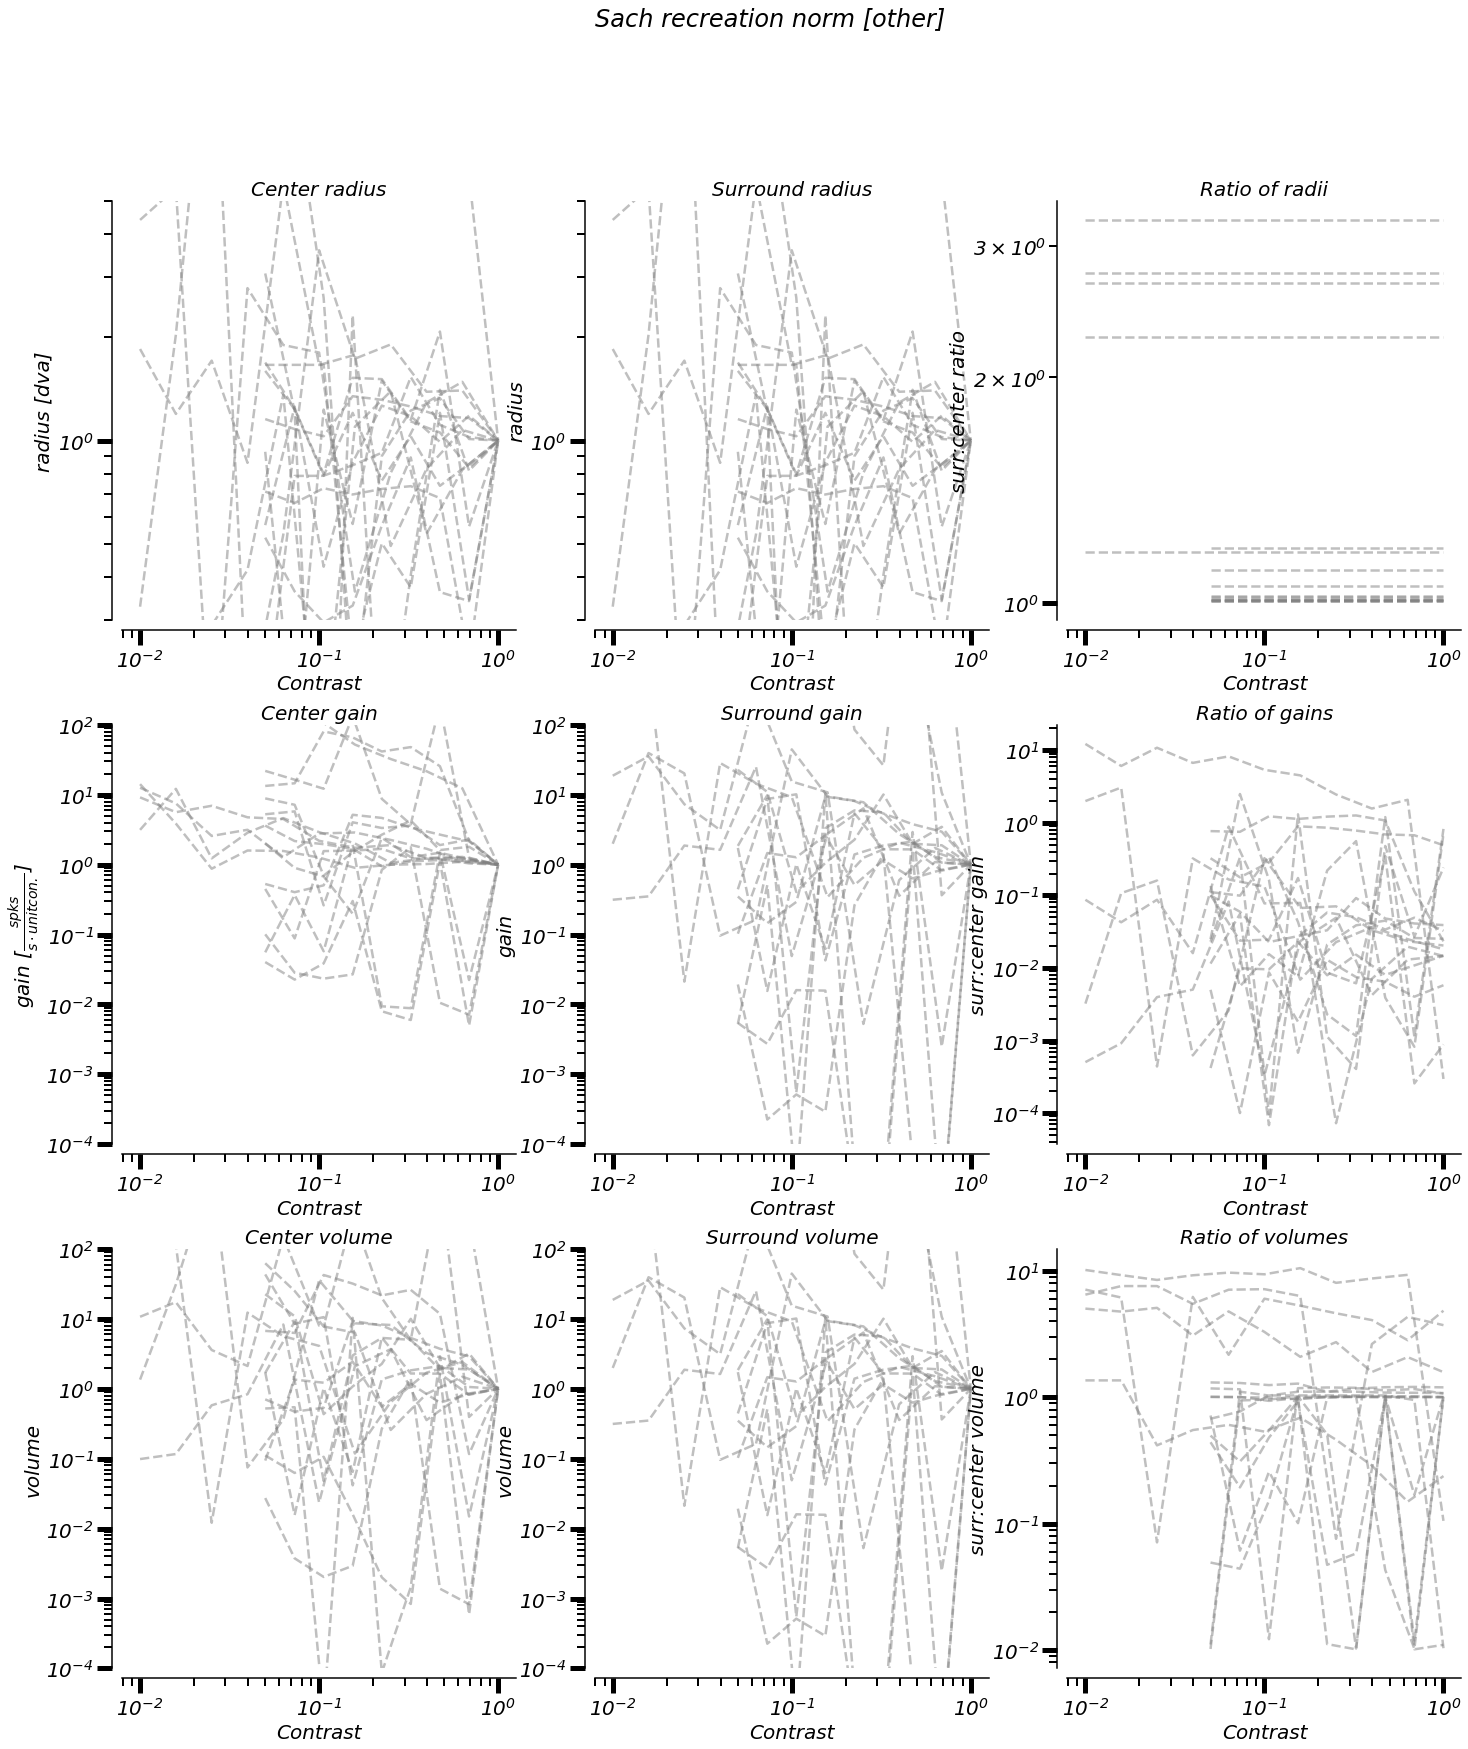

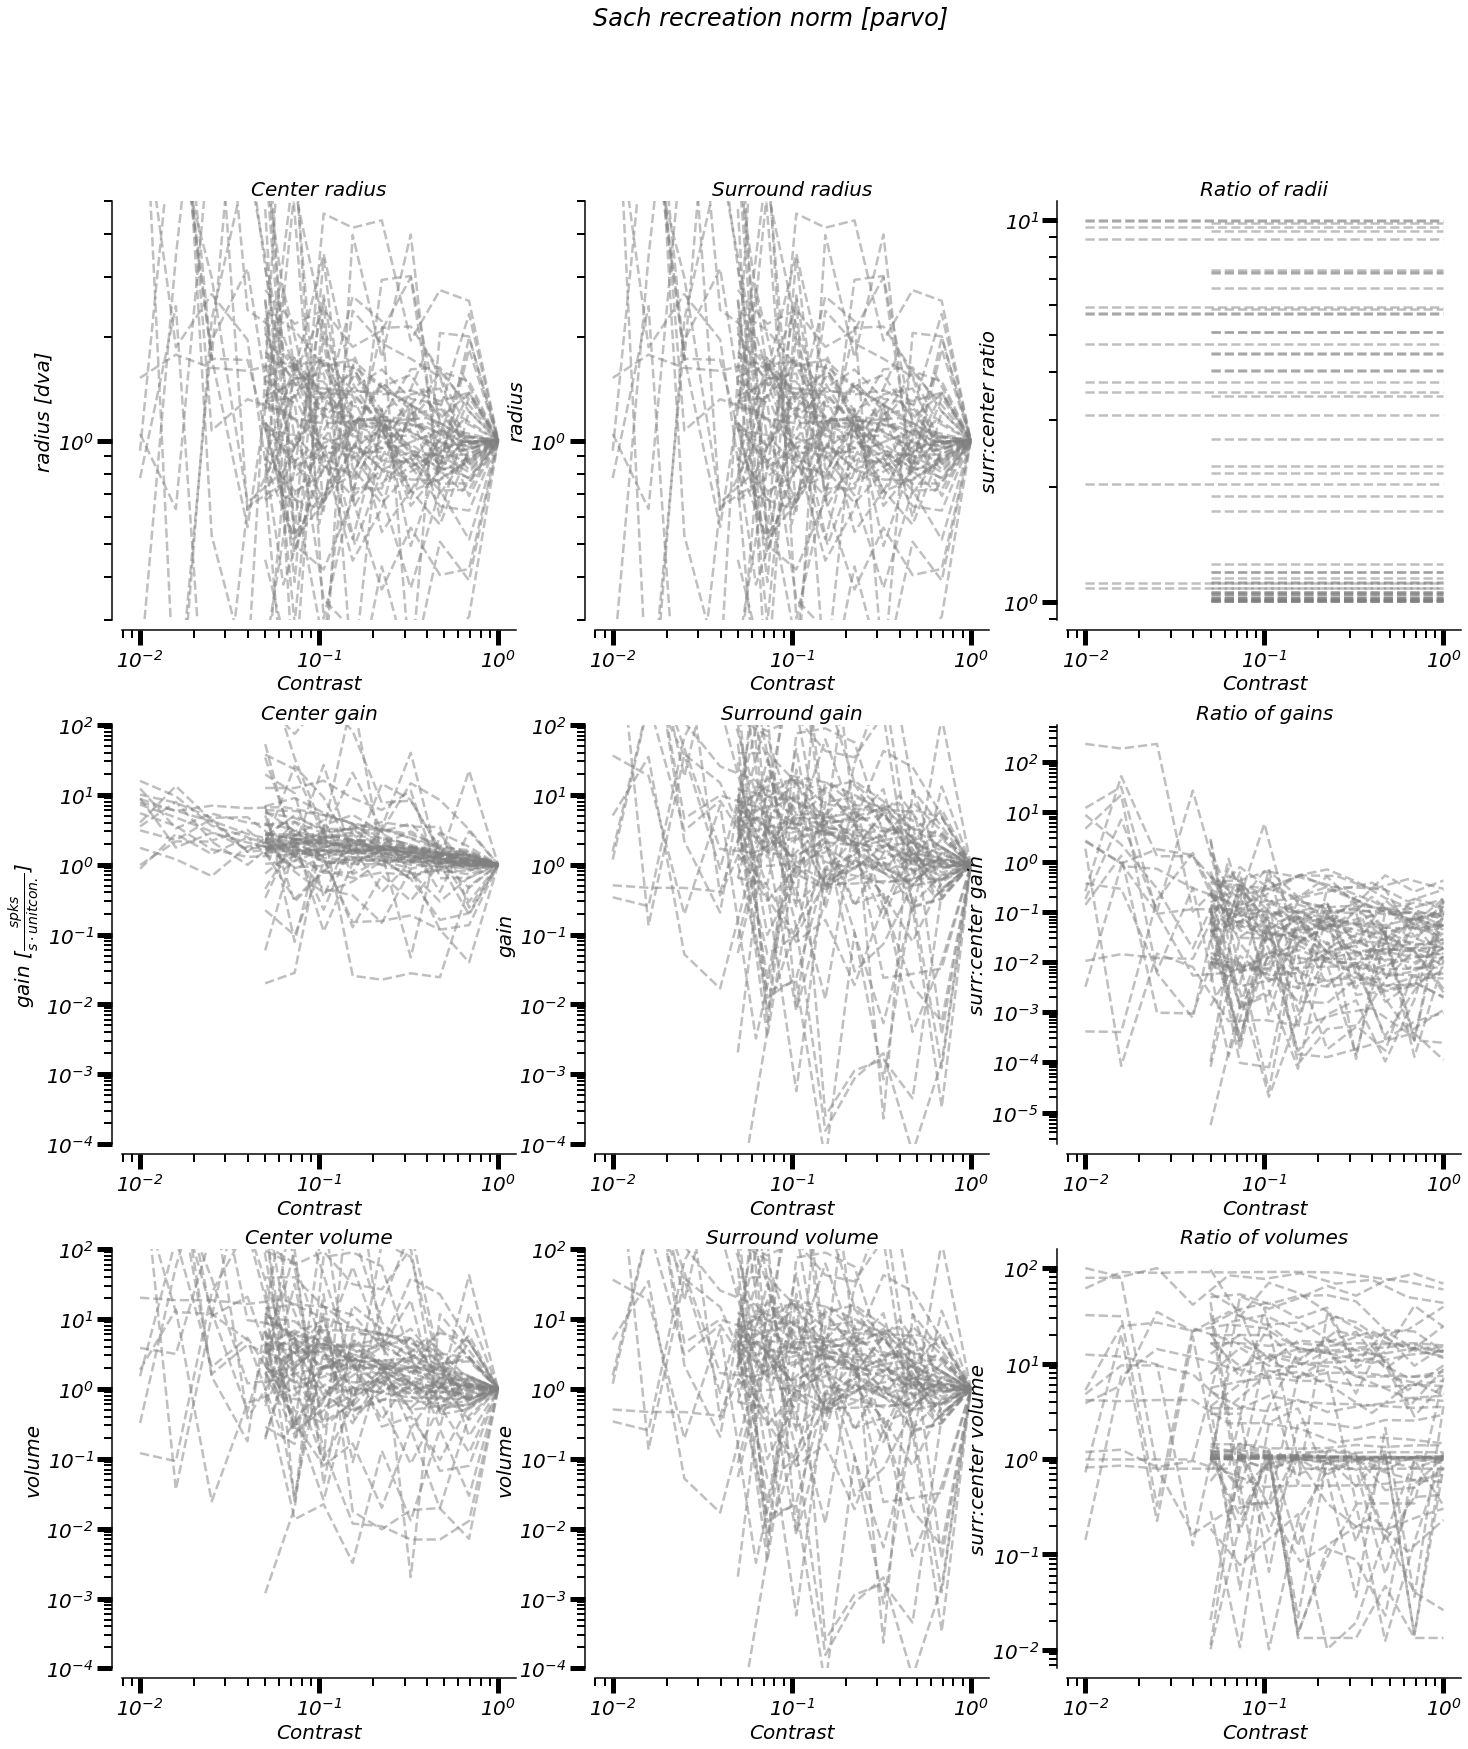

In [1751]:
grouped = mega.groupby(toGroup)

boot = 0;
bootStr = 'boot ' if boot else ' ';

disp = 0;
norm = 1;
normStr = 'norm ' if norm else ' ';

# indices into ['dog_mech']
i_gc, i_rc, i_vc, i_gs, i_rs, i_vs = range(6);
mdn = 50; # we want 50th percentile

nrow, ncol = 3, 3;

for (name, group), clr, widOffset in zip(grouped, colors, offsets):

    f, ax = plt.subplots(nrow, ncol, figsize=(ncol*8, nrow*9))

    # do the visuals, axes, labels, etc
    gray = cm.gray(0.5) # mean gray
    f.suptitle('Sach recreation %s[%s]' % (normStr, name))
    f.subplots_adjust(wspace=0.2, hspace=0.25);

    ##########
    #### RADIUS
    ##########
    
    # center radius
    plt.subplot(3, 3, 1);
    if norm:
        plt.ylim([3e-1, 5]);
    else:
        plt.ylim([1e-1, 1]);
    plt.xlabel('Contrast');
    plt.ylabel(r'radius [dva]')
    plt.title('Center radius')
    plt.xscale('log')
    plt.yscale('log')
    
    # surround radius
    plt.subplot(3, 3, 2);
    if norm:
        plt.ylim([3e-1, 5]);
    else:
        plt.ylim([1e-1, 5]);
    plt.xlabel('Contrast');
    plt.ylabel('radius')
    plt.title('Surround radius')
    plt.xscale('log')
    plt.yscale('log')
    
    # center:surround radius
    plt.subplot(3, 3, 3);
#     if norm:
#         plt.ylim([3e-1, 5]);
#     else:
#         plt.ylim([1e-1, 5]);
    plt.xlabel('Contrast');
    plt.ylabel('surr:center ratio')
    plt.title('Ratio of radii')
    plt.xscale('log')
    plt.yscale('log')

    ##########
    #### GAIN
    ##########

    # center gain
    plt.subplot(3, 3, 4);
    if norm:
        plt.ylim([1e-4, 1e2]);
#     else:
#         plt.ylim([1e-1, 5]);
    plt.xlabel('Contrast');
    plt.ylabel(r'gain [$\frac{spks}{s \cdot unit con.}$]')
    plt.title('Center gain')
    plt.xscale('log')
    plt.yscale('log')
    
    # surround gain
    plt.subplot(3, 3, 5);
    if norm:
        plt.ylim([1e-4, 1e2]);
#     else:
#         plt.ylim([1e-1, 5]);
    plt.xlabel('Contrast');
    plt.ylabel('gain')
    plt.title('Surround gain')
    plt.xscale('log')
    plt.yscale('log')
    
    # center:surround gain
    plt.subplot(3, 3, 6);
#     if norm:
#         plt.ylim([3e-1, 5]);
#     else:
#         plt.ylim([1e-1, 5]);
    plt.xlabel('Contrast');
    plt.ylabel('surr:center gain')
    plt.title('Ratio of gains')
    plt.xscale('log')
    plt.yscale('log')
    
    ##########
    #### VOLUME
    ##########
    
    # center volume
    plt.subplot(3, 3, 7);
    if norm:
        plt.ylim([1e-4, 1e2]);
#     else:
#         plt.ylim([1e-1, 5]);
    plt.xlabel('Contrast');
    plt.ylabel('volume')
    plt.title('Center volume')
    plt.xscale('log')
    plt.yscale('log')
    
    # surround volume
    plt.subplot(3, 3, 8);
    if norm:
        plt.ylim([1e-4, 1e2]);
#     else:
#         plt.ylim([1e-1, 5]);
    plt.xlabel('Contrast');
    plt.ylabel('volume')
    plt.title('Surround volume')
    plt.xscale('log')
    plt.yscale('log')
    
    # center:surround volume
    plt.subplot(3, 3, 9);
#     if norm:
#         plt.ylim([3e-1, 5]);
#     else:
#         plt.ylim([1e-1, 5]);
    plt.xlabel('Contrast');
    plt.ylabel('surr:center volume')
    plt.title('Ratio of volumes')
    plt.xscale('log')
    plt.yscale('log')
    
    for ky in group['cellType'].index:
        
        # Go through each cell in this group
        curr_dir = group['fullPath'][ky].split('/')[-3]
        curr_num = group['cellNum'][ky];
        curr_name = '' if 'sach' in curr_dir else mega['expName'][ky];
        
        # -- get the contrasts that are used
        curr_inds = group['val_con_by_disp'][ky][disp]; # zero dispersion, always?
        curr_cons = group['stimVals'][ky][1][curr_inds]
        
        # center radius
        plt.subplot(3, 3, 1);
        if boot:
            curr_rc = np.nanpercentile(group['boot_dog_mech'][ky][disp, curr_inds, i_rc, :], mdn, axis=1)
        else:
            curr_rc = group['dog_mech'][ky][disp, curr_inds, i_rc]
        non_nan = np.where(~np.isnan(curr_rc))[0]
        if len(non_nan) > 1:
            curr_rc_plt = np.divide(curr_rc, curr_rc[non_nan[-1]]) if norm else curr_rc;
            plt.plot(curr_cons, curr_rc_plt, '--', color=gray, alpha=0.5)

        # surround radius
        plt.subplot(3, 3, 2);
        if boot:
            curr_rs = np.nanpercentile(group['boot_dog_mech'][ky][disp, curr_inds, i_rs, :], mdn, axis=1)
        else:
            curr_rs = group['dog_mech'][ky][disp, curr_inds, i_rs]
        non_nan = np.where(~np.isnan(curr_rs))[0]
        if len(non_nan) > 1:
            curr_rs_plt = np.divide(curr_rs, curr_rs[non_nan[-1]]) if norm else curr_rs;
            plt.plot(curr_cons, curr_rs_plt, '--', color=gray, alpha=0.5)
            
        # center:surr radii
        plt.subplot(3, 3, 3);
        curr_rats = np.divide(curr_rs, curr_rc);
        non_nan = np.where(~np.isnan(curr_rats))[0]
        if len(non_nan) > 1:
            plt.plot(curr_cons, curr_rats, '--', color=gray, alpha=0.5)

        ##########
        #### GAIN
        ##########
    
        # center gain
        plt.subplot(3, 3, 4);
        if boot:
            curr_gc = np.nanpercentile(group['boot_dog_mech'][ky][disp, curr_inds, i_gc, :], mdn, axis=1)
        else:
            curr_gc = group['dog_mech'][ky][disp, curr_inds, i_gc]
        non_nan = np.where(~np.isnan(curr_gc))[0]
        if len(non_nan) > 1:
            curr_gc_plt = np.divide(curr_gc, curr_gc[non_nan[-1]]) if norm else curr_gc;
            plt.plot(curr_cons, curr_gc_plt, '--', color=gray, alpha=0.5)

        # surround volume
        plt.subplot(3, 3, 5);
        if boot:
            curr_gs = np.nanpercentile(group['boot_dog_mech'][ky][disp, curr_inds, i_gs, :], mdn, axis=1)
        else:
            curr_gs = group['dog_mech'][ky][disp, curr_inds, i_vs]
        non_nan = np.where(~np.isnan(curr_gs))[0]
        if len(non_nan) > 1:
            curr_gs_plt = np.divide(curr_gs, curr_gs[non_nan[-1]]) if norm else curr_gs;
            plt.plot(curr_cons, curr_gs_plt, '--', color=gray, alpha=0.5)

        # volume ratio
        plt.subplot(3, 3, 6);
        curr_rats = np.divide(curr_gs, curr_gc);
        non_nan = np.where(~np.isnan(curr_rats))[0]
        if len(non_nan) > 1:
            plt.plot(curr_cons, curr_rats, '--', color=gray, alpha=0.5)
            
        ##########
        #### VOLUME
        ##########
    
        # center volume
        plt.subplot(3, 3, 7);
        if boot:
            curr_vc = np.nanpercentile(group['boot_dog_mech'][ky][disp, curr_inds, i_vc, :], mdn, axis=1)
        else:
            curr_vc = group['dog_mech'][ky][disp, curr_inds, i_vc]
        non_nan = np.where(~np.isnan(curr_vc))[0]
        if len(non_nan) > 1:
            curr_vc_plt = np.divide(curr_vc, curr_vc[non_nan[-1]]) if norm else curr_vc;
            plt.plot(curr_cons, curr_vc_plt, '--', color=gray, alpha=0.5)

        # surround volume
        plt.subplot(3, 3, 8);
        if boot:
            curr_vs = np.nanpercentile(group['boot_dog_mech'][ky][disp, curr_inds, i_vs, :], mdn, axis=1)
        else:
            curr_vs = group['dog_mech'][ky][disp, curr_inds, i_vs]
        non_nan = np.where(~np.isnan(curr_vs))[0]
        if len(non_nan) > 1:
            curr_vs_plt = np.divide(curr_vs, curr_vs[non_nan[-1]]) if norm else curr_vs;
            plt.plot(curr_cons, curr_vs_plt, '--', color=gray, alpha=0.5)

        # volume ratio
        plt.subplot(3, 3, 9);
        curr_rats = np.divide(curr_vs, curr_vc);
        non_nan = np.where(~np.isnan(curr_rats))[0]
        if len(non_nan) > 1:
            plt.plot(curr_cons, curr_rats, '--', color=gray, alpha=0.5)

    # then after all cells, save
    sns.despine(offset=10)
    
    saveName = "/03_01_sach_%s%s%s.pdf" % (normStr.replace(' ', '_'), bootStr.replace(' ', '_'), name)
    full_save = os.path.dirname(save_loc);
    if not os.path.exists(full_save):
        os.makedirs(full_save)
    pdfSv = pltSave.PdfPages(full_save + saveName);
    pdfSv.savefig(f) # only one figure here...
    pdfSv.close()

# END OF UPDATED ANALYSES

#### 02.02b Preferred spatial frequency with contrast from data (1:.33 contrast and 1:lowestValid contrast)

In [1752]:
# whichFit = 0; # 0 for flexible gauss, 1 for DoG
# excludeOneThirds = 0; # if 1, then we don't count include cells which have a lowest valid contrast GTE to 1/3
# exclStr = '_excl33' if excludeOneThirds else ''

# prefix = 'dog_' if whichFit==1 else ''
# suffix = '[DoG] ' if whichFit==1 else ''

# saveName = '02_02b_sfPref_%sscatter_%s%s.pdf' % (prefix, fitBase, exclStr);

# nrow, ncol = 1,2
# f, ax = plt.subplots(nrow,ncol, figsize=(ncol*12, nrow*10))

# disp=0
# yLabels = ['33% contrast', 'lowest valid contrast']

# rats_both = [];

# # first one will be 1:.33 (i.e. raw values); second will be 1:lowest
# for i,ylbl in enumerate(yLabels):

#     highSf, compSf, compCons = hf.jl_get_metric_highComp(jointList, '%spSf' % prefix, whichFit, i)
    
#     if excludeOneThirds and i == 1:
#         validInds = np.where(compCons<0.3)[0];
#     else:
#         validInds = np.where(compCons<0.4)[0]; # obviously, we exclude lowest cons which are the same!
    
#     non_nan = np.logical_and(~np.isnan(highSf), ~np.isnan(compSf))
#     val_inds = np.intersect1d(np.where(non_nan)[0], validInds)
       
#     rats_both.append(np.divide(highSf[val_inds], compSf[val_inds]))
        
#     ax[i].scatter(highSf[val_inds], compSf[val_inds], alpha=0.6, color='k', s=30)
#     ax[i].loglog([0.3,10], [0.3, 10], 'k--')
#     paired_t = ss.ttest_rel(highSf[val_inds], compSf[val_inds])
#     pval = paired_t.pvalue;
#     ax[i].set_title('Preferred SF with contrast %s(n=%d, p=%.2e)' % (suffix, len(val_inds), pval))
#     ax[i].set_xlabel('High contrast')
#     ax[i].set_ylabel(ylbl)
#     ax[i].set_aspect('equal')
    
# sns.despine(offset=5)

# if not os.path.exists(save_loc):
#     os.makedirs(save_loc)
# pdfSv = pltSave.PdfPages(save_loc + saveName);
# pdfSv.savefig(f) # only one figure here...
# pdfSv.close()

In [1753]:
# # Then, the histogram
# saveName = saveName.replace('scatter', 'hist')

# f, ax = plt.subplots(nrow,ncol, figsize=(ncol*12, nrow*10), sharey=True)

# bins = np.linspace(-1.25, 1.25, 10);
# stepSize = (bins[-1] - bins[0])/(len(bins)-1);
# binPlotLocs = bins[1:] - 0.5*stepSize;
# tickVals = np.linspace(bins[1], bins[-2], len(bins)-2);

# xlabs = ['1:0.33', '1:lowestCon']

# # first one will be 1:.33 (i.e. raw values); second will be 1:lowest
# for (i,ylbl), xlab, rats_curr in zip(enumerate(yLabels), xlabs, rats_both):

#     rats = np.log2(rats_curr);
        
#     ratsClipped = np.clip(rats, bins[0]+0.5*stepSize, bins[-1]-0.5*stepSize)
#     vals, _ = np.histogram(ratsClipped, bins=bins)
#     vals_norm = vals/np.sum(vals)
       
#     mean, median = np.nanmean(rats), np.nanmedian(rats);
        
#     ax[i].plot(mean, 1.25*np.max(vals_norm), 'v', label='mean (%.2f)' % np.power(2, mean), markersize=12);
#     ax[i].plot(median, 1.25*np.max(vals_norm), 'v', label='median (%.2f)' % np.power(2, median), markersize=12);
        
#     ax[i].bar(binPlotLocs, vals_norm, width=0.8*stepSize, align='center', color='k');
#     mean, median = [np.nanmean(fracVals), np.nanmedian(fracVals)];
#     ax[i].set_xticks(tickVals)
#     ax[i].set_xticklabels(['%.2f' % np.power(2, x) for x in tickVals]);  
#     ax[i].axvline(0, color='k', linestyle='--')
#     ax[i].set_xlabel('Ratio @ %s' % xlab)
#     ax[i].set_title('Preferred SF with contrast %s(n=%d)' % (suffix, len(rats)))
#     ax[i].legend(fontsize='x-small')

# sns.despine(offset=10)

# if not os.path.exists(save_loc):
#     os.makedirs(save_loc)
# pdfSv = pltSave.PdfPages(save_loc + saveName);
# pdfSv.savefig(f) # only one figure here...
# pdfSv.close()